# Neural Collapse

Code demonstrating Neural Collapse on Cross-Entropy [1] and MSE Loss [2].

### References:

[1] V. Papyan, X.Y. Han, and D.L. Donoho. "[Prevalence of Neural Collapse During the Terminal Phase of Deep Learning Training.](https://www.pnas.org/content/117/40/24652)" *Proceedings of the National Academy of Sciences (PNAS)* 117, no. 40 (2020): 24652-24663.

[2] X.Y. Han, V. Papyan, and D.L. Donoho. [“Neural Collapse Under MSE Loss: Proximity to and Dynamics on the Central Path.”](https://openreview.net/forum?id=w1UbdvWH_R3) *International Conference on Learning Representations (ICLR)*, 2022.


## Imports

In [ ]:
import torch
import gc
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from google.colab import files

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from torchvision import datasets, transforms
from IPython import embed

In [ ]:
import random

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setting the variables

In [ ]:
debug = True # Only runs 20 batches per epoch for debugging=True

# dataset parameters
im_size             = 28
padded_im_size      = 32
C                   = 10
input_ch            = 1

# Optimization Criterion
loss_name = 'CrossEntropyLoss'
# loss_name = 'MSELoss'

# Optimization hyperparameters
lr_decay            = 0.1

# Best lr after hyperparameter tuning
if loss_name == 'CrossEntropyLoss':
  lr = 0.0679
elif loss_name == 'MSELoss':
  lr = 0.0184

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
epoch_list          = [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,
                       12,  13,  14,  16,  17,  19,  20,  22,  24,  27,   29,
                       32,  35,  38,  42,  45,  50,  54,  59,  65,  71,   77,
                       85,  92,  101, 110, 121, 132, 144, 158, 172, 188,  206,
                       225, 245, 268, 293, 320, 350]

## Training Function

In [ ]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        if str(criterion) == 'CrossEntropyLoss()':
          loss = criterion(out, target)
        elif str(criterion) == 'MSELoss()':
          loss = criterion(out, F.one_hot(target, num_classes=num_classes).float())

        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(out,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))

        if debug and batch_idx > 20:
          break
    pbar.close()

## Calculating the global, class means and class, between-class covariance

In [ ]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Cov']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)

            output = model(data)
            h = features.value.data.view(data.shape[0],-1) # B CHW

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()
                elif str(criterion_summed) == 'MSELoss()':
                  loss += criterion_summed(output, F.one_hot(target, num_classes=num_classes).float()).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Cov':
                    # update within-class cov

                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
            loss /= sum(N)
        elif computation == 'Cov':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    W  = classifier.weight
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # Decomposition of MSE #
    if loss_name == 'MSELoss':

      wd = 0.5 * weight_decay # "\lambda" in manuscript, so this is halved
      St = Sw+Sb
      size_last_layer = Sb.shape[0]
      eye_P = torch.eye(size_last_layer).to(device)
      eye_C = torch.eye(C).to(device)

      St_inv = torch.inverse(St + (wd/(wd+1))*(muG @ muG.T) + wd*eye_P)

      w_LS = 1 / C * (M.T - 1 / (1 + wd) * muG.T) @ St_inv
      b_LS = (1/C * torch.ones(C).to(device) - w_LS @ muG.T.squeeze(0)) / (1+wd)
      w_LS_ = torch.cat([w_LS, b_LS.unsqueeze(-1)], dim=1)  # c x n
      b  = classifier.bias
      w_ = torch.cat([W, b.unsqueeze(-1)], dim=1)  # c x n

      LNC1 = 0.5 * (torch.trace(w_LS @ (Sw + wd*eye_P) @ w_LS.T) + wd*torch.norm(b_LS)**2)
      LNC23 = 0.5/C * torch.norm(w_LS @ M + b_LS.unsqueeze(1) - eye_C) ** 2

      A1 = torch.cat([St + muG @ muG.T + wd*eye_P, muG], dim=1)
      A2 = torch.cat([muG.T, torch.ones([1,1]).to(device) + wd], dim=1)
      A = torch.cat([A1, A2], dim=0)
      Lperp = 0.5 * torch.trace((w_ - w_LS_) @ A @ (w_ - w_LS_).T)

      MSE_wd_features = loss + 0.5* weight_decay * (torch.norm(W)**2 + torch.norm(b)**2).item()
      MSE_wd_features *= 0.5

      graphs.MSE_wd_features.append(MSE_wd_features)
      graphs.LNC1.append(LNC1.item())
      graphs.LNC23.append(LNC23.item())
      graphs.Lperp.append(Lperp.item())

    # tr{Sw Sb^-1}
    Sw = Sw.cpu().numpy()
    Sb = Sb.cpu().numpy()
    eigvec, eigval, _ = svds(Sb, k=C-1)
    inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T
    graphs.Sw_invSb.append(np.trace(Sw @ inv_Sb))

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))

## The model

In [ ]:
model = models.resnet18(pretrained=False, num_classes=C)
model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Helper Functions for Analysis

In [ ]:
class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

transform = transforms.Compose([transforms.Pad((padded_im_size - im_size)//2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

if loss_name == 'CrossEntropyLoss':
  criterion = nn.CrossEntropyLoss()
  criterion_summed = nn.CrossEntropyLoss(reduction='sum')
elif loss_name == 'MSELoss':
  criterion = nn.MSELoss()
  criterion_summed = nn.MSELoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)

class graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

    # Decomposition
    self.MSE_wd_features = []
    self.LNC1 = []
    self.LNC23 = []
    self.Lperp = []
graphs = graphs()

100%|██████████| 9912422/9912422 [00:00<00:00, 242405597.50it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111542996.15it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64129256.39it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15413049.17it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Visualize NC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_dir = '/content/drive/My Drive/Colab Notebooks/Plots_NC_CELoss'

Train		Epoch: 1 [21/469 (4%)] 	Batch Loss: 0.772881 	Batch Accuracy: 0.750000:   4%|▍         | 21/469 [00:10<03:53,  1.92it/s]
Analysis Cov	Epoch: 1 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.53it/s]


abc1_1.png
abc2_1.png
abc3_1.png
abc4_1.png
abc5_1.png
abc6_1.png
abc7_1.png


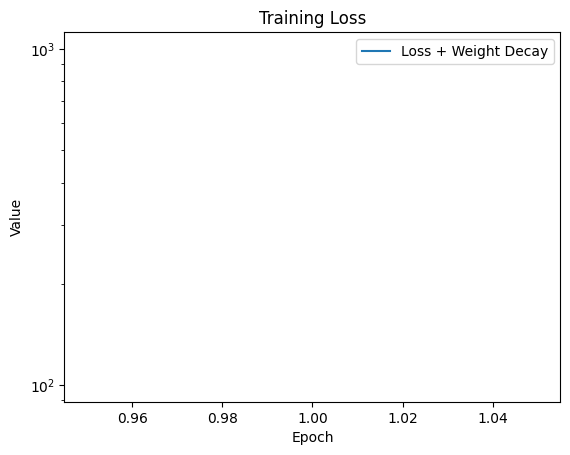

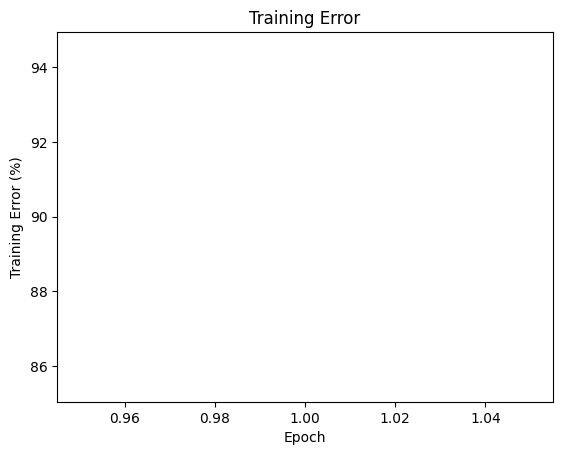

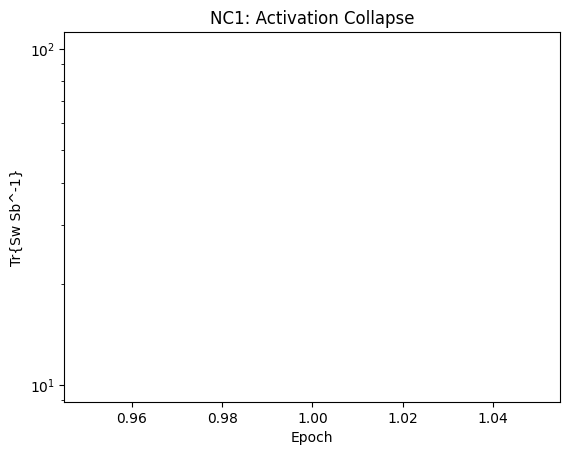

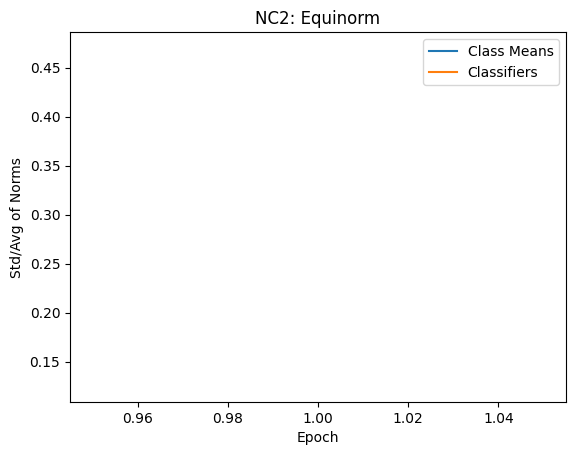

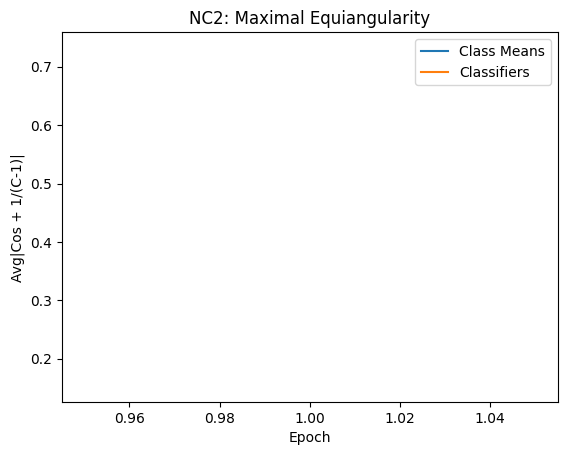

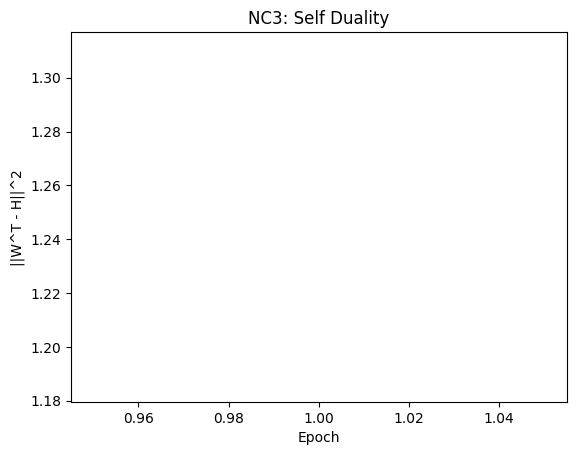

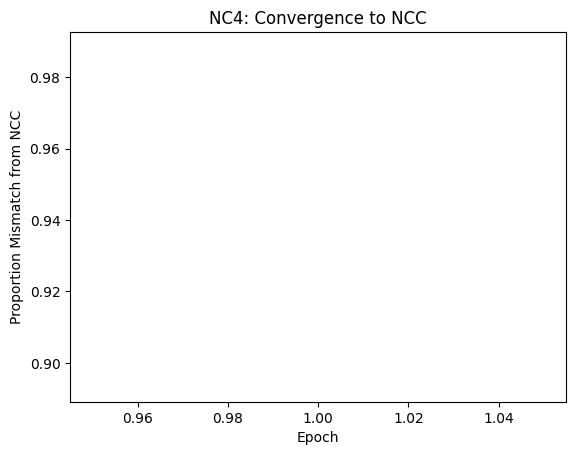

Train		Epoch: 2 [21/469 (4%)] 	Batch Loss: 0.286027 	Batch Accuracy: 0.914062:   4%|▍         | 21/469 [00:02<01:03,  7.00it/s]
Analysis Cov	Epoch: 2 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:34, 12.97it/s]


abc1_2.png
abc2_2.png
abc3_2.png
abc4_2.png
abc5_2.png
abc6_2.png
abc7_2.png


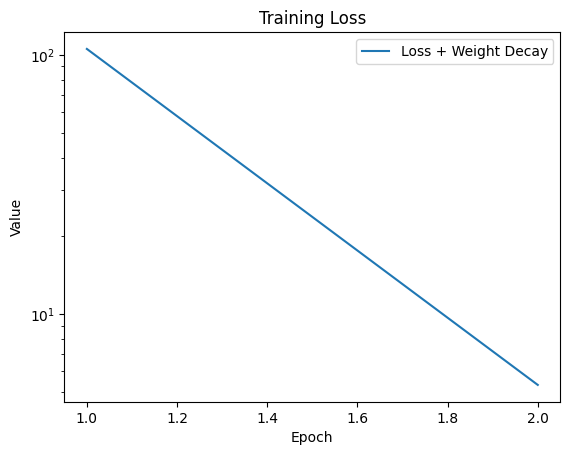

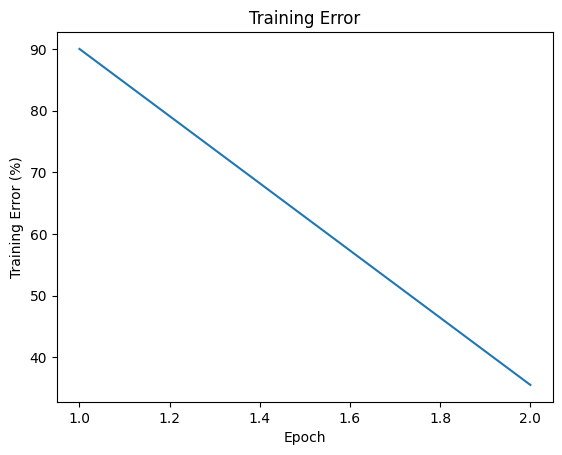

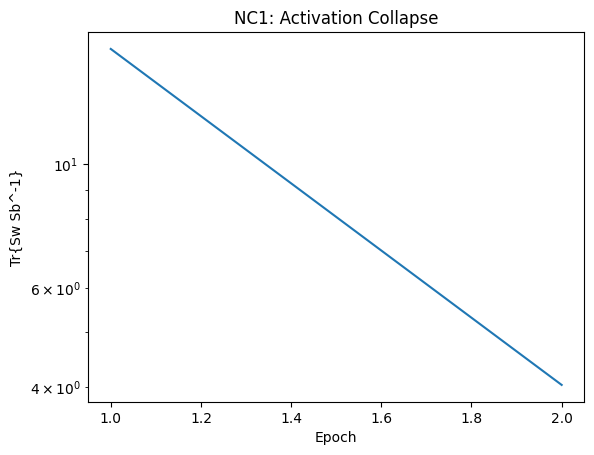

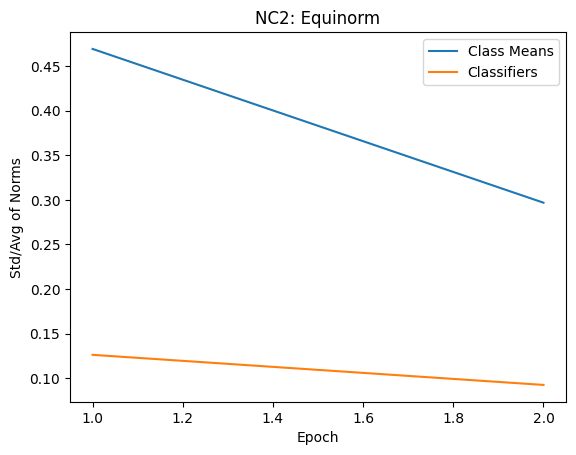

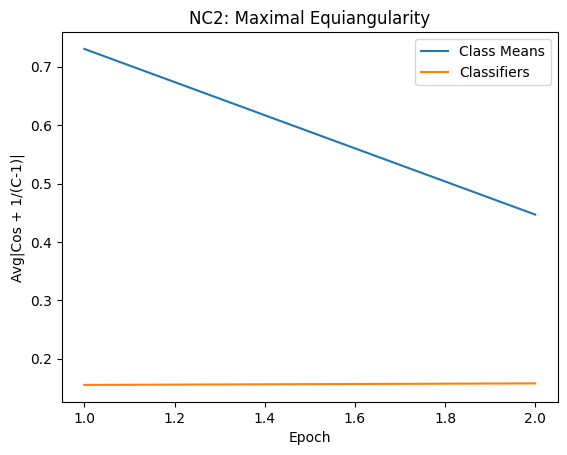

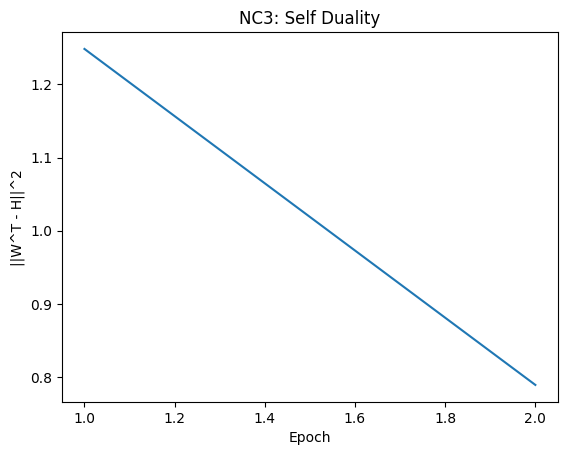

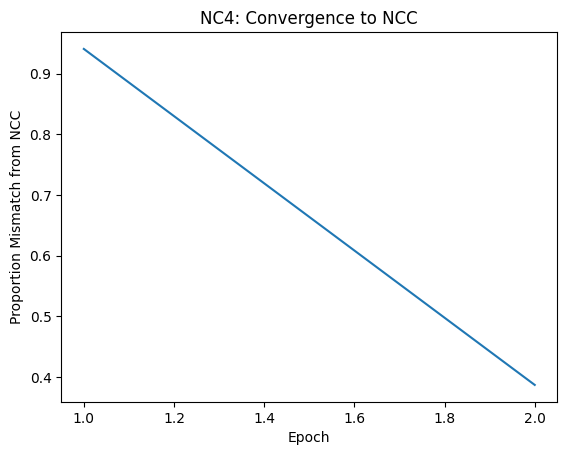

Train		Epoch: 3 [21/469 (4%)] 	Batch Loss: 0.183061 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:03<01:10,  6.38it/s]
Analysis Cov	Epoch: 3 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.53it/s]


abc1_3.png
abc2_3.png
abc3_3.png
abc4_3.png
abc5_3.png
abc6_3.png
abc7_3.png


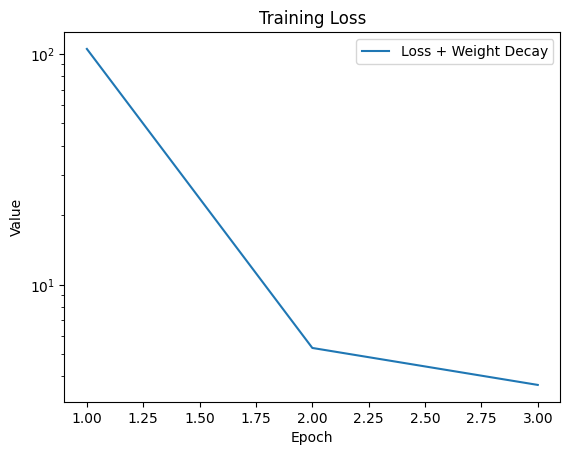

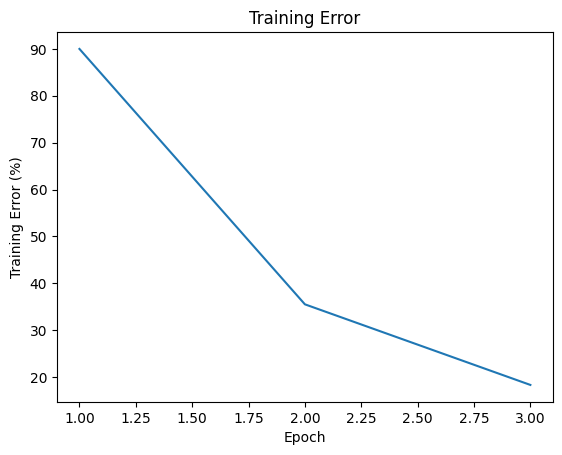

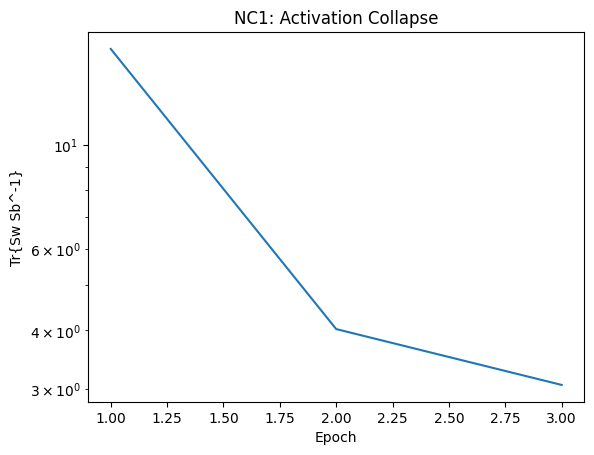

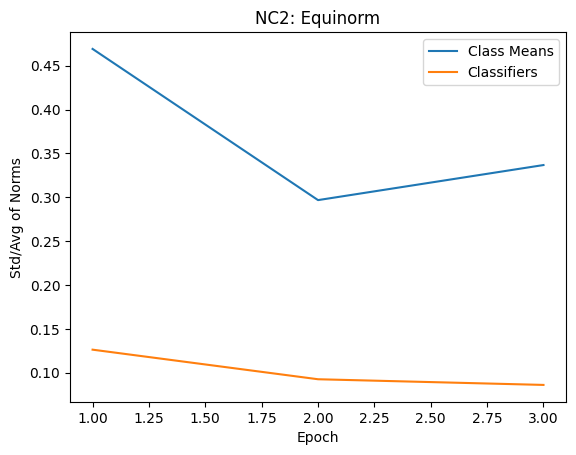

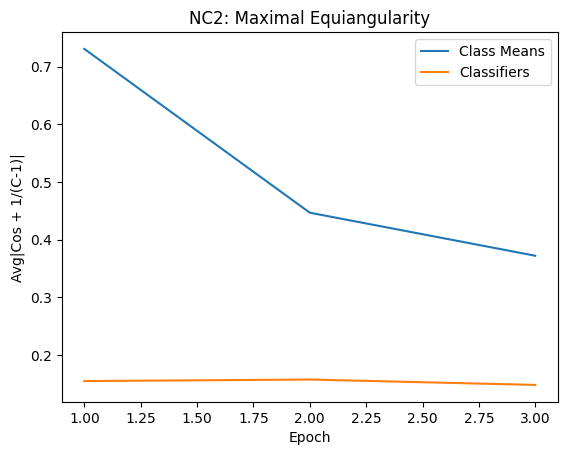

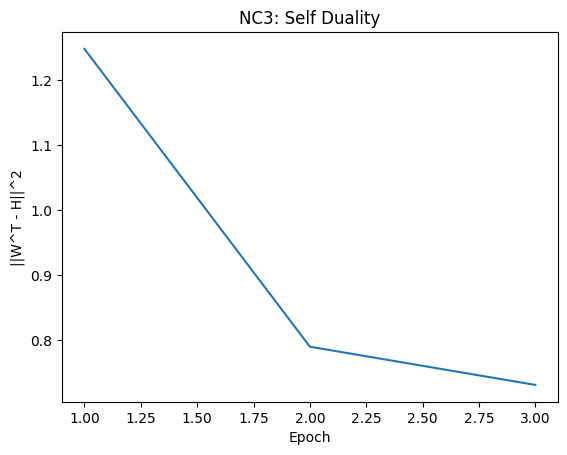

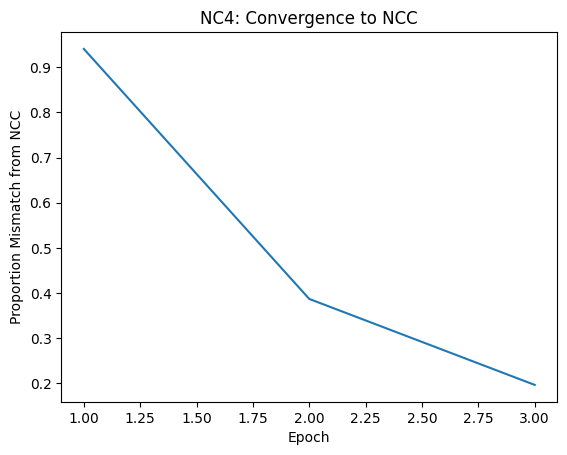

Train		Epoch: 4 [21/469 (4%)] 	Batch Loss: 0.218194 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:03<01:13,  6.10it/s]
Analysis Cov	Epoch: 4 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:37, 11.79it/s]


abc1_4.png
abc2_4.png
abc3_4.png
abc4_4.png
abc5_4.png
abc6_4.png
abc7_4.png


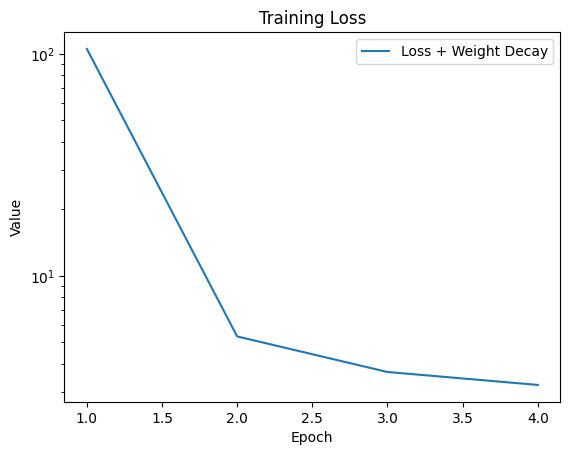

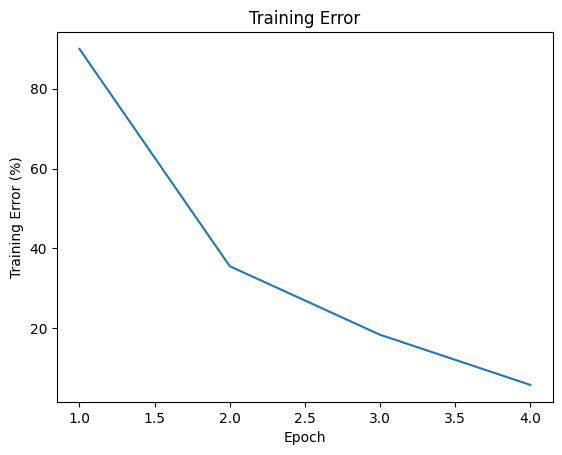

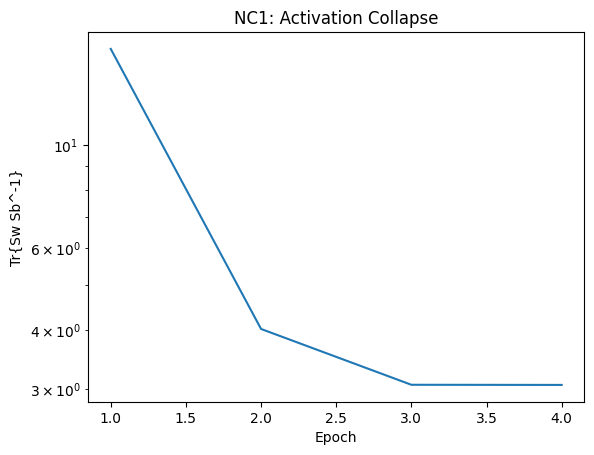

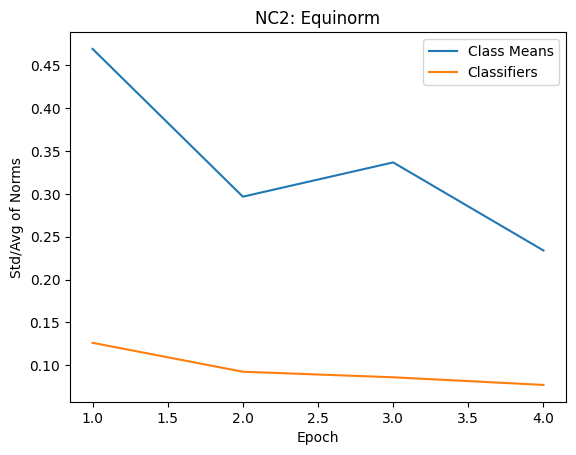

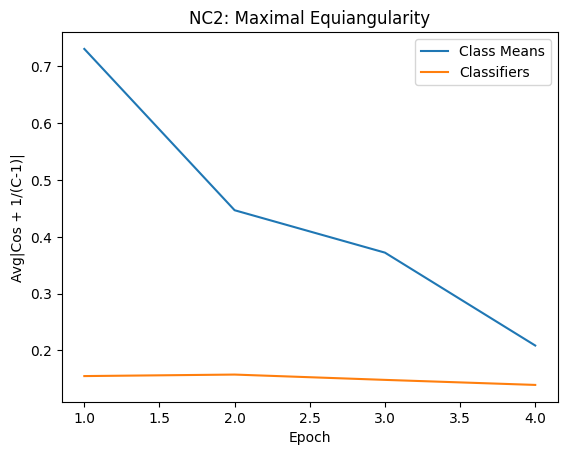

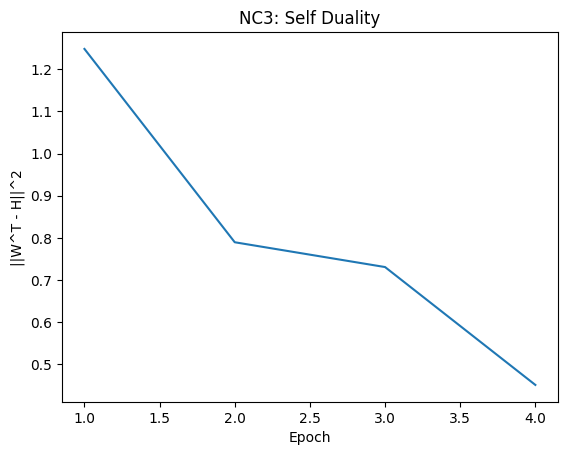

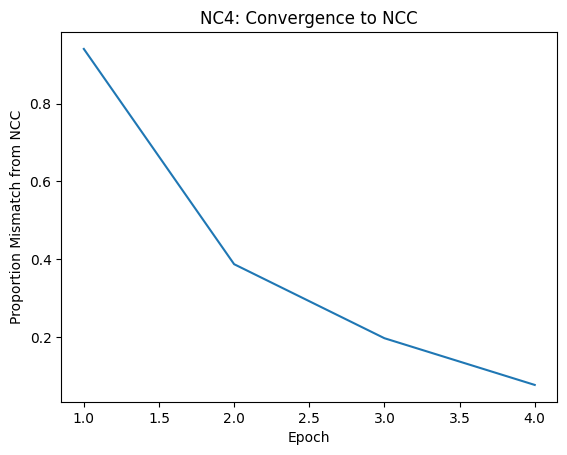

Train		Epoch: 5 [21/469 (4%)] 	Batch Loss: 0.110048 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:11,  6.23it/s]
Analysis Cov	Epoch: 5 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:51,  8.70it/s]


abc1_5.png
abc2_5.png
abc3_5.png
abc4_5.png
abc5_5.png
abc6_5.png
abc7_5.png


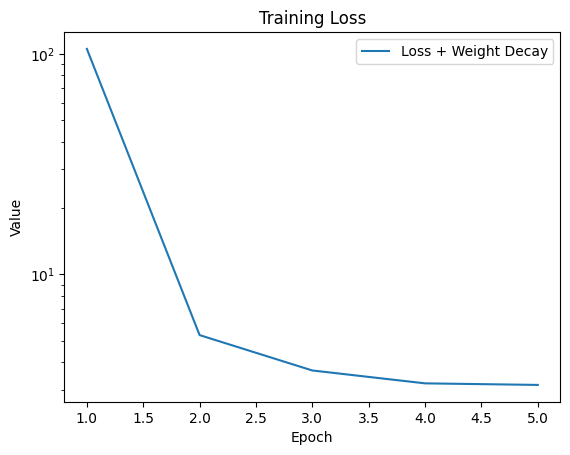

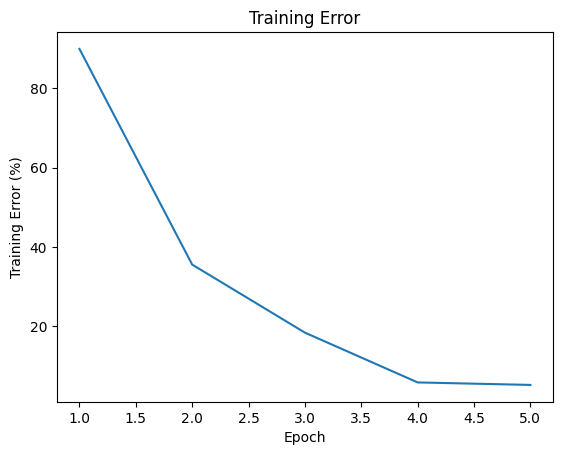

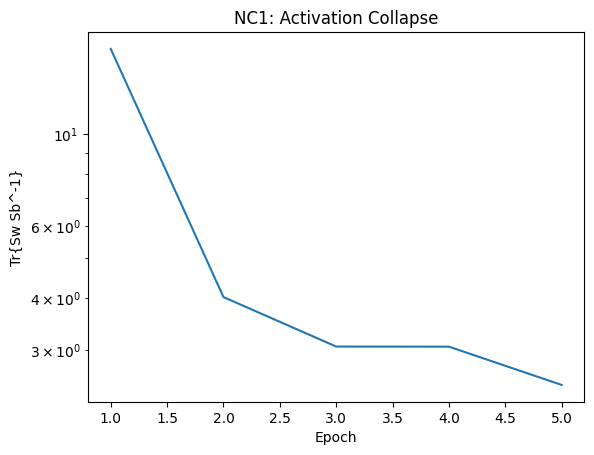

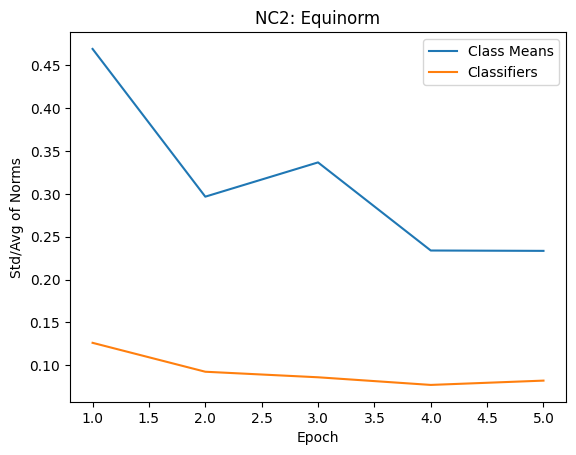

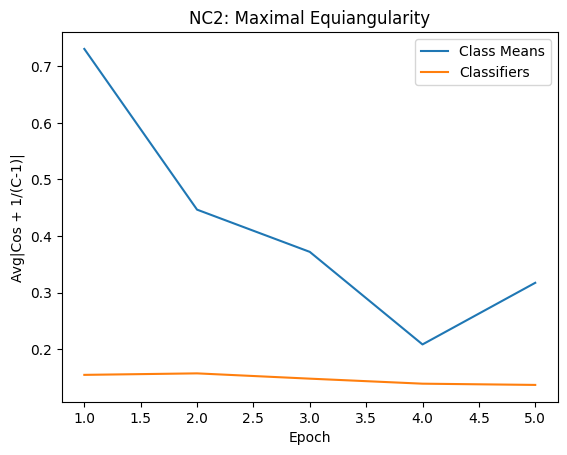

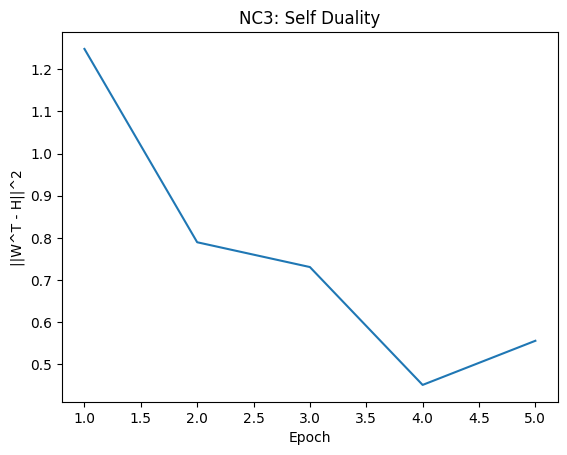

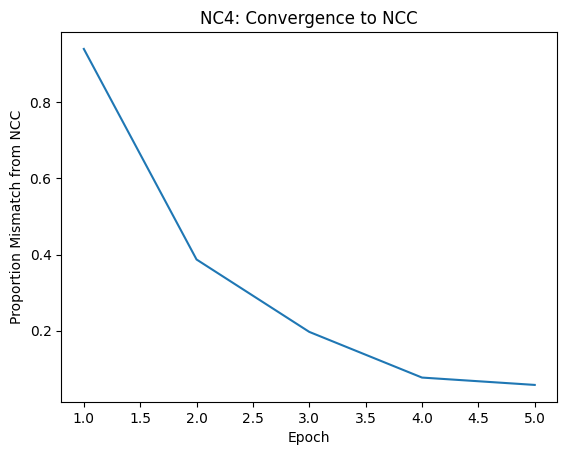

Train		Epoch: 6 [21/469 (4%)] 	Batch Loss: 0.089568 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:03<01:07,  6.64it/s]
Analysis Cov	Epoch: 6 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:42, 10.49it/s]


abc1_6.png
abc2_6.png
abc3_6.png
abc4_6.png
abc5_6.png
abc6_6.png
abc7_6.png


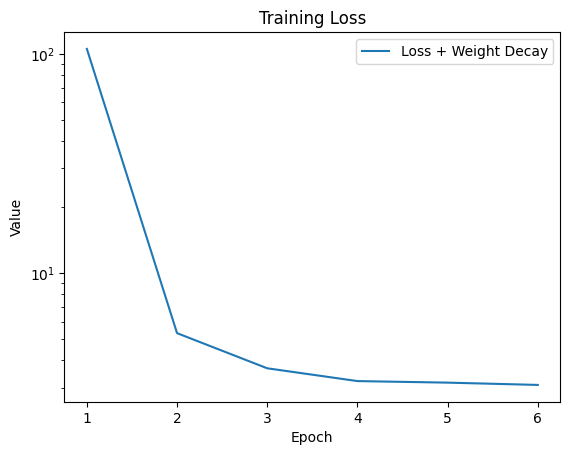

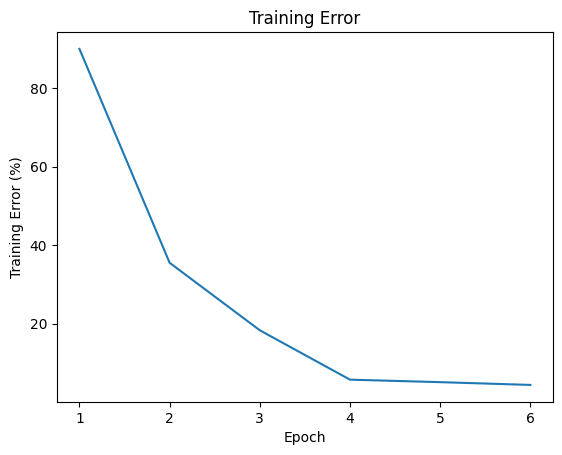

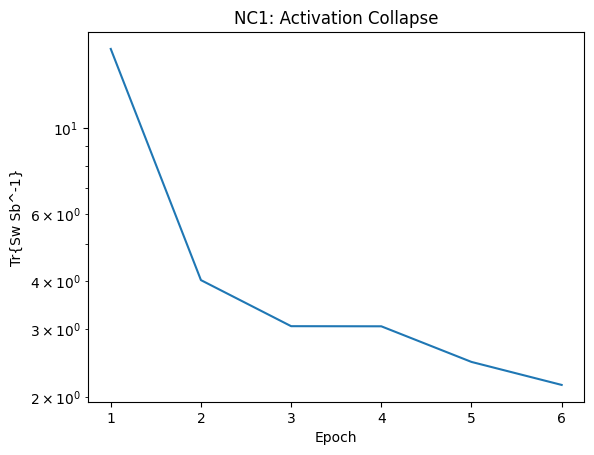

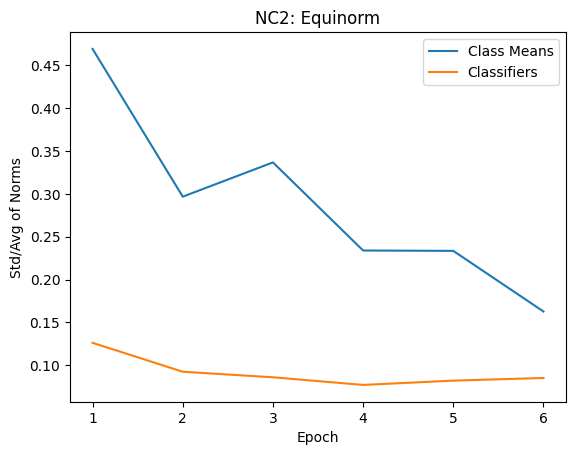

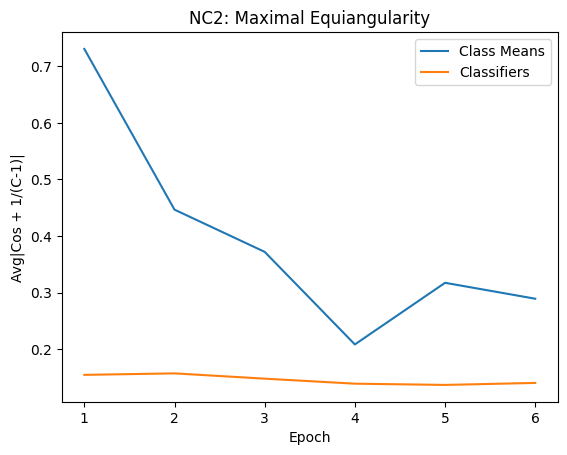

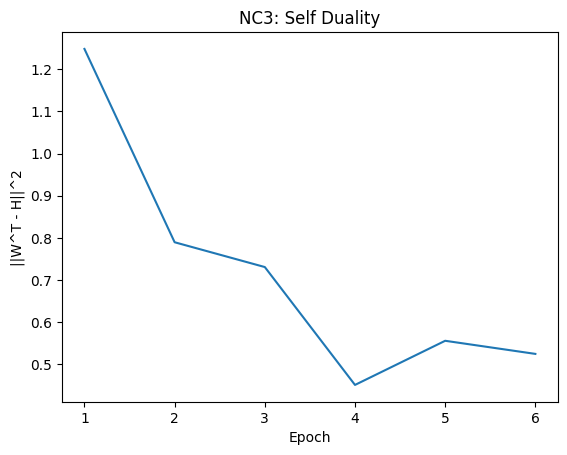

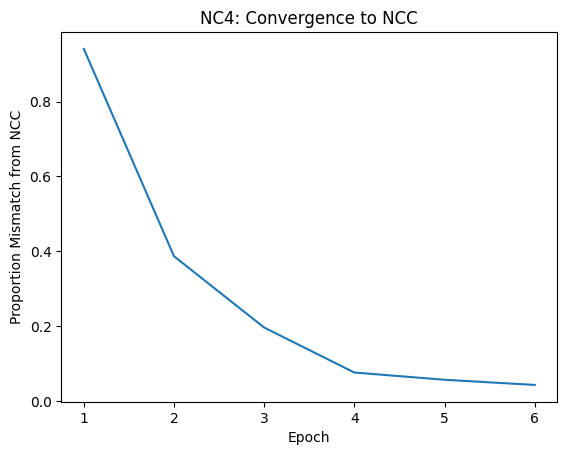

Train		Epoch: 7 [21/469 (4%)] 	Batch Loss: 0.127156 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:03<01:08,  6.57it/s]
Analysis Cov	Epoch: 7 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:37, 11.96it/s]


abc1_7.png
abc2_7.png
abc3_7.png
abc4_7.png
abc5_7.png
abc6_7.png
abc7_7.png


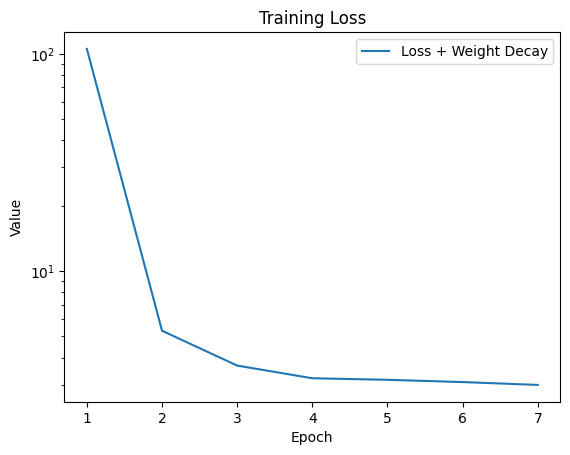

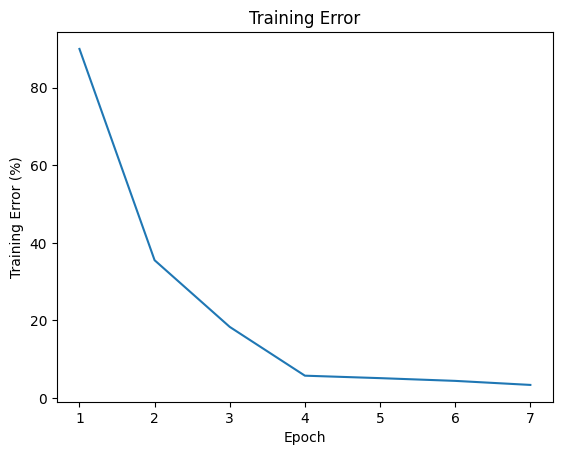

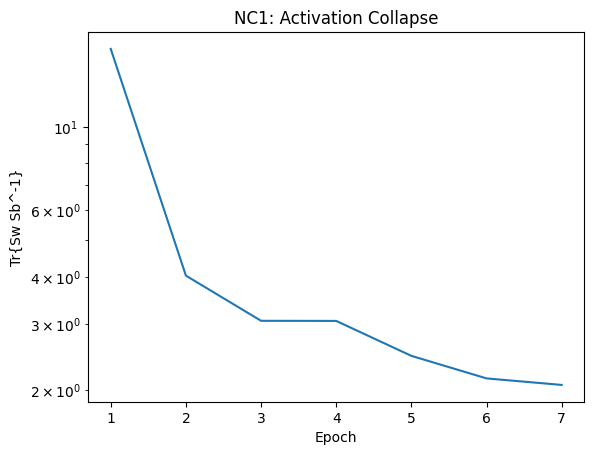

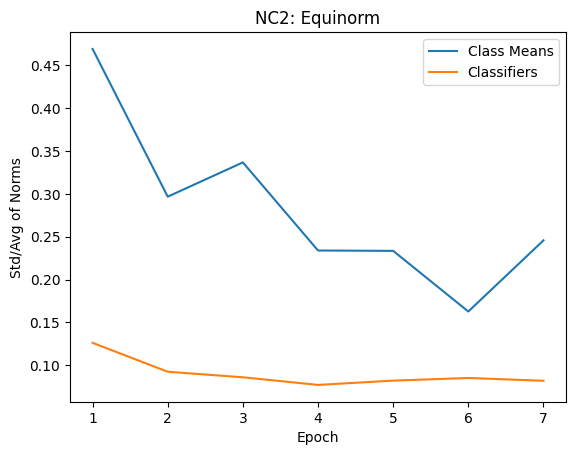

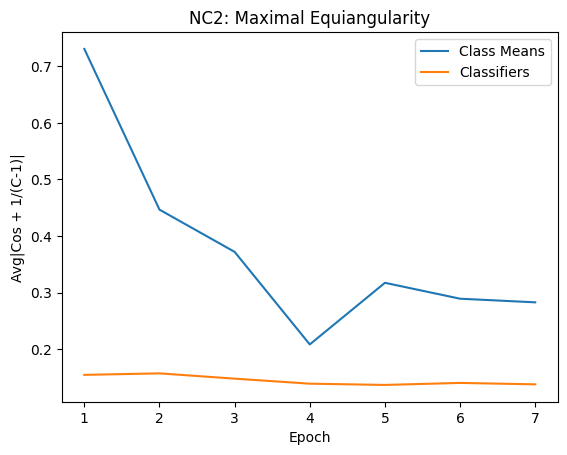

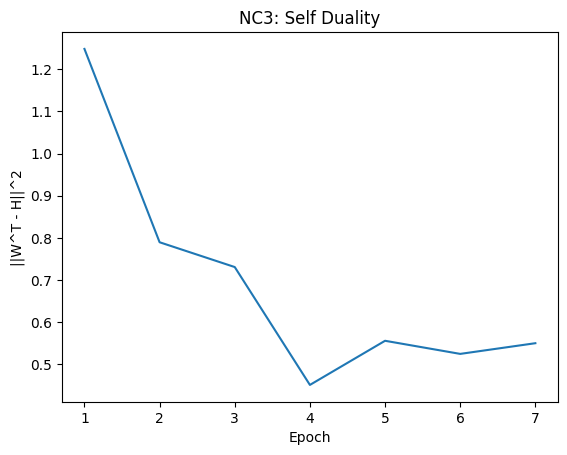

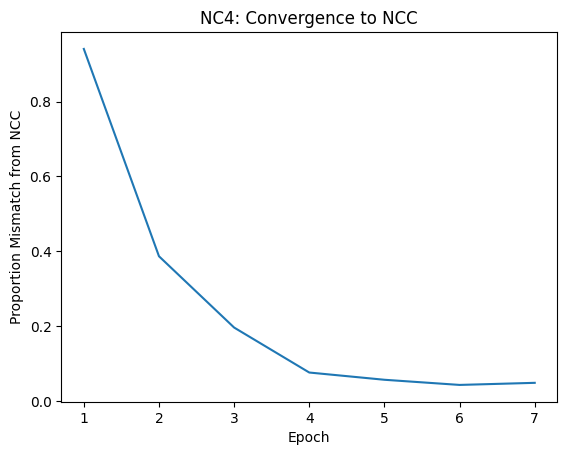

Train		Epoch: 8 [21/469 (4%)] 	Batch Loss: 0.022929 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.20it/s]
Analysis Cov	Epoch: 8 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:43, 10.26it/s]


abc1_8.png
abc2_8.png
abc3_8.png
abc4_8.png
abc5_8.png
abc6_8.png
abc7_8.png


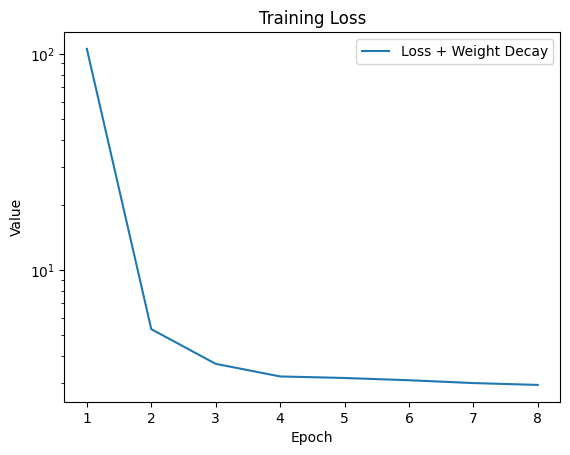

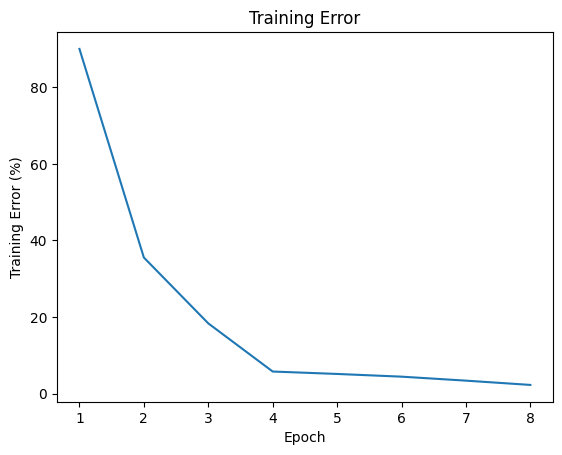

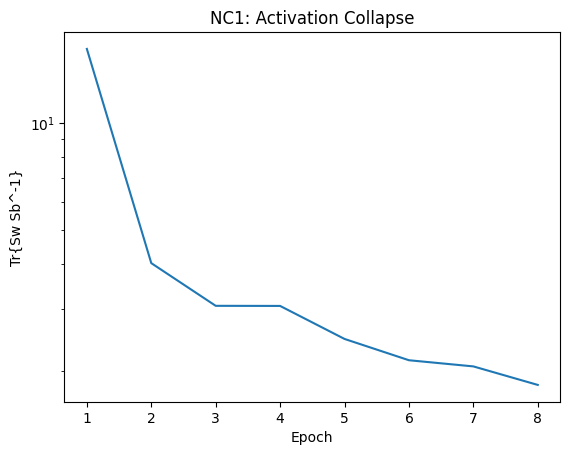

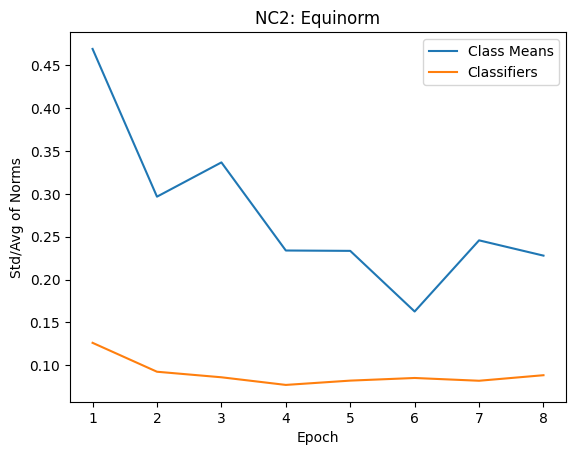

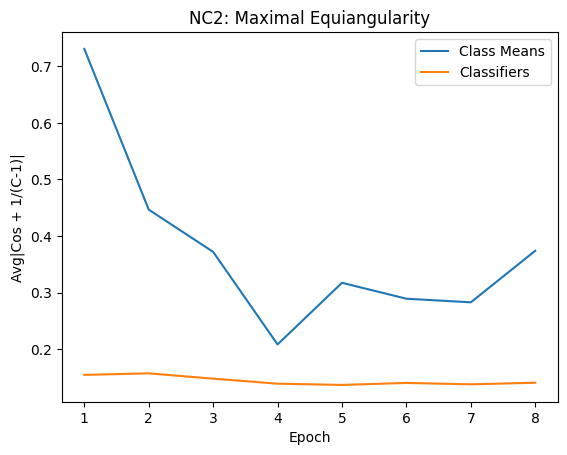

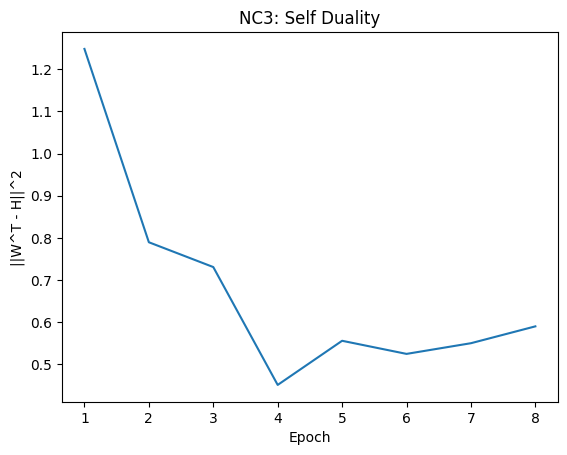

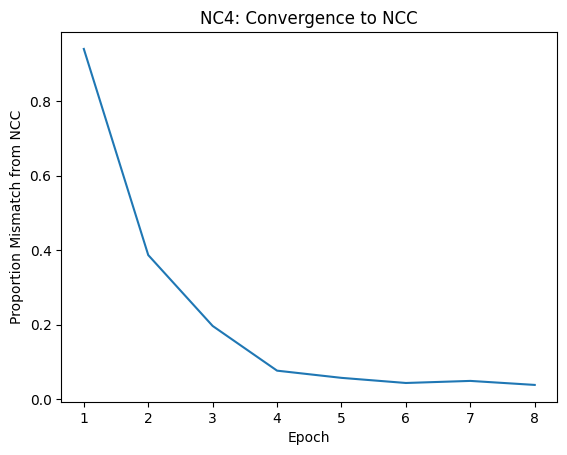

Train		Epoch: 9 [21/469 (4%)] 	Batch Loss: 0.047086 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.52it/s]
Analysis Cov	Epoch: 9 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:39, 11.43it/s]


abc1_9.png
abc2_9.png
abc3_9.png
abc4_9.png
abc5_9.png
abc6_9.png
abc7_9.png


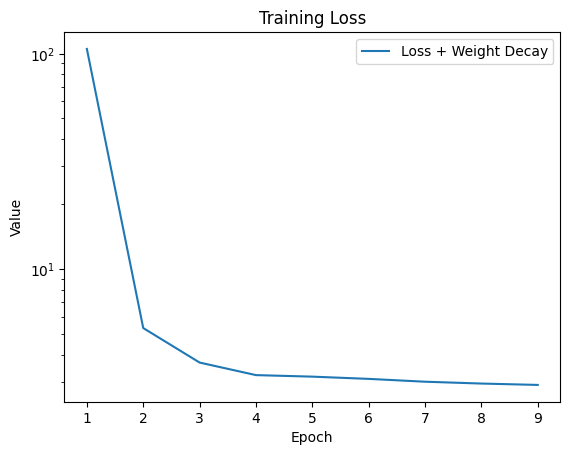

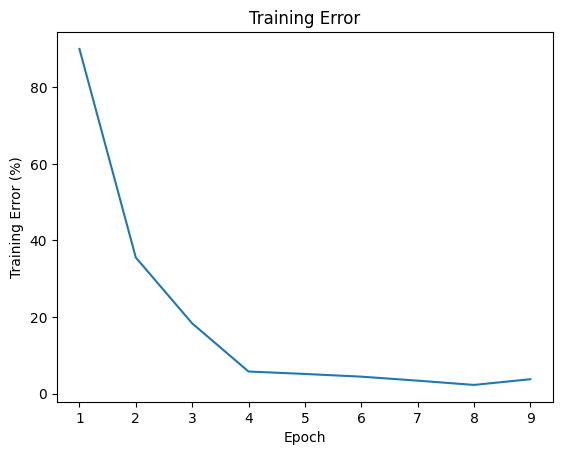

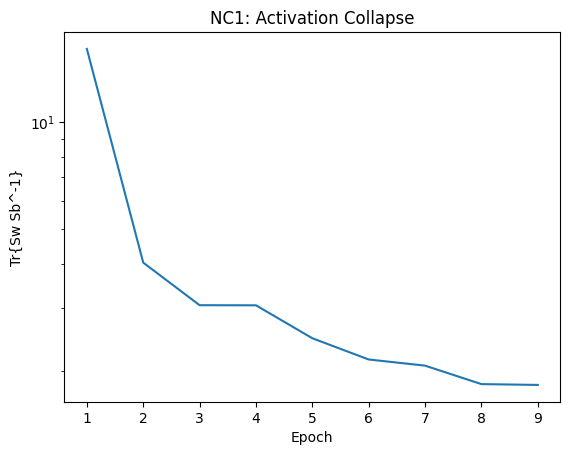

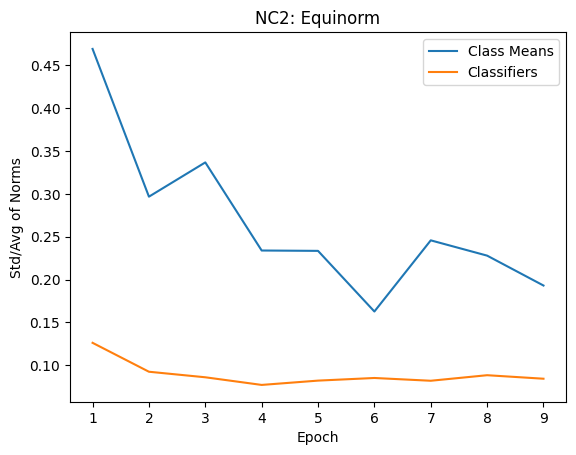

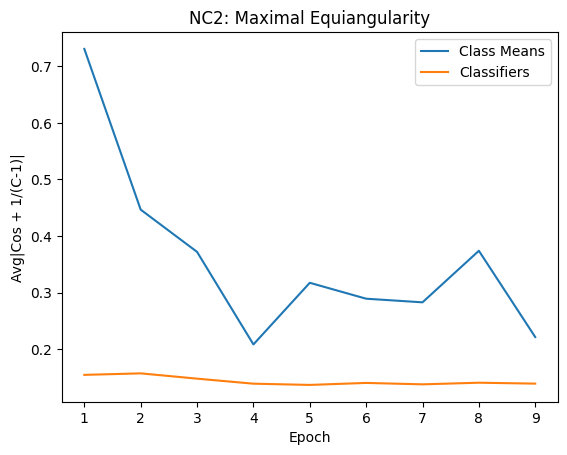

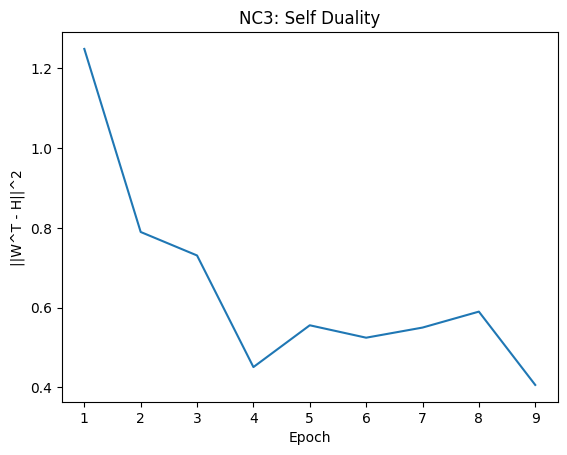

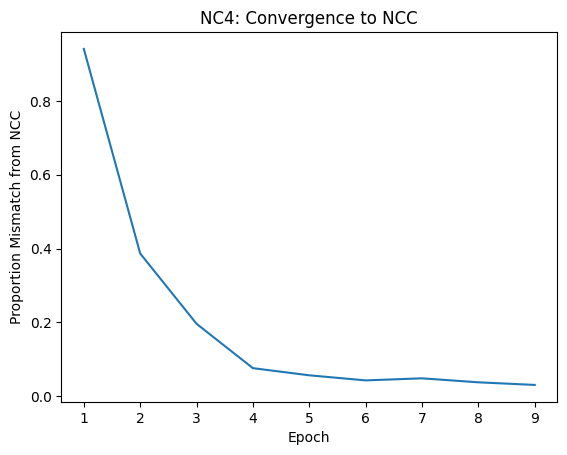

Train		Epoch: 10 [21/469 (4%)] 	Batch Loss: 0.015282 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:14,  6.02it/s]
Analysis Cov	Epoch: 10 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:46,  9.64it/s]


abc1_10.png
abc2_10.png
abc3_10.png
abc4_10.png
abc5_10.png
abc6_10.png
abc7_10.png


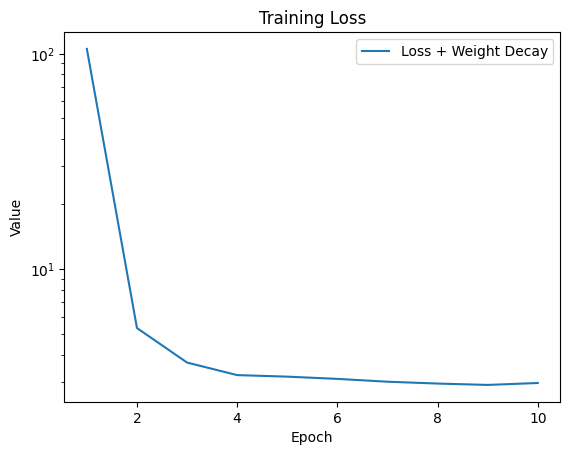

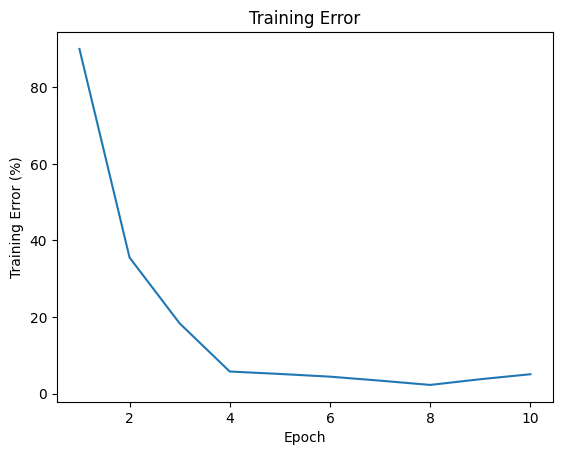

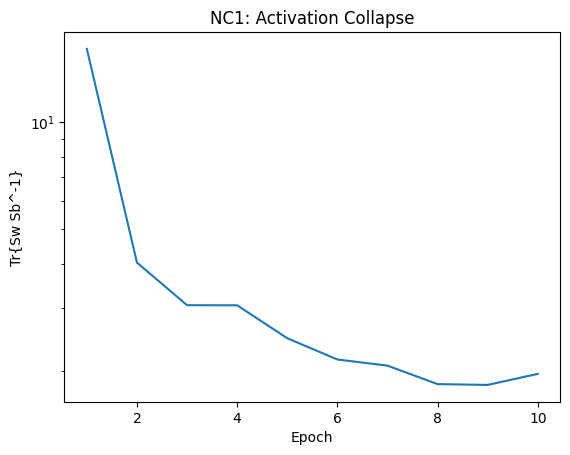

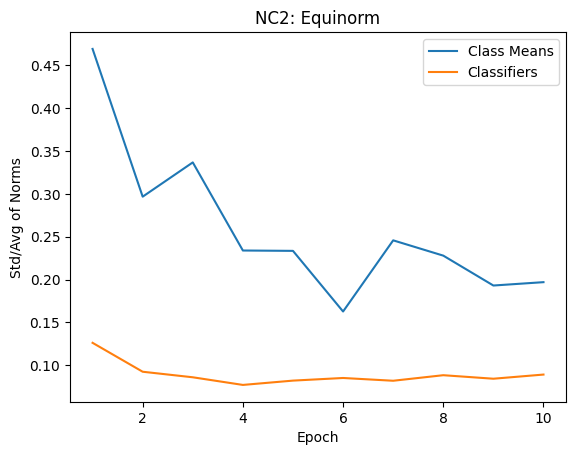

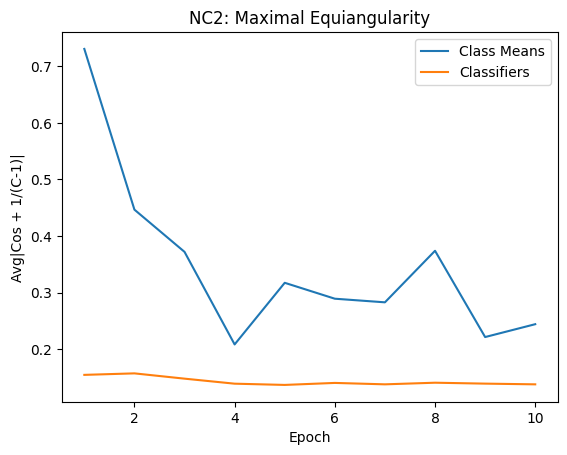

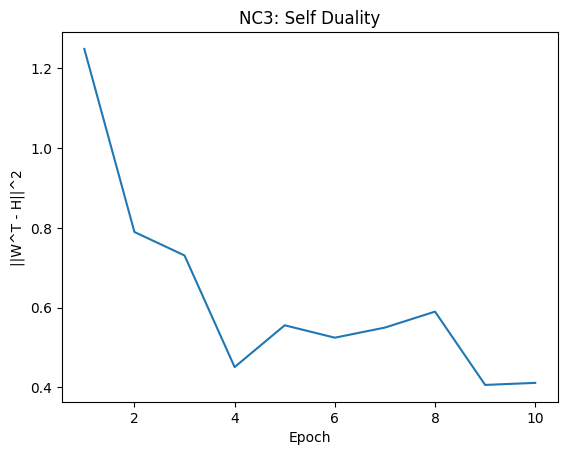

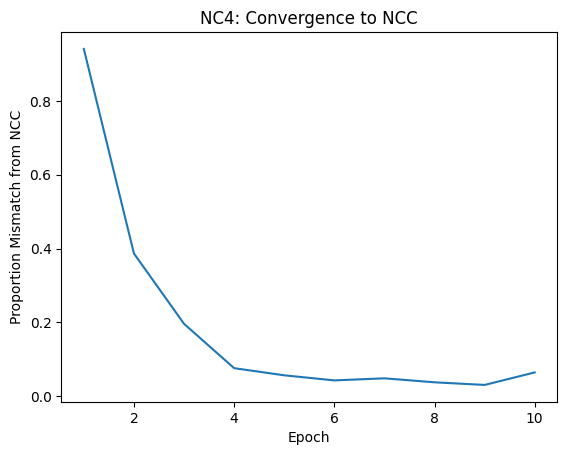

Train		Epoch: 11 [21/469 (4%)] 	Batch Loss: 0.102733 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:03<01:08,  6.52it/s]
Analysis Cov	Epoch: 11 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:40, 11.10it/s]


abc1_11.png
abc2_11.png
abc3_11.png
abc4_11.png
abc5_11.png
abc6_11.png
abc7_11.png


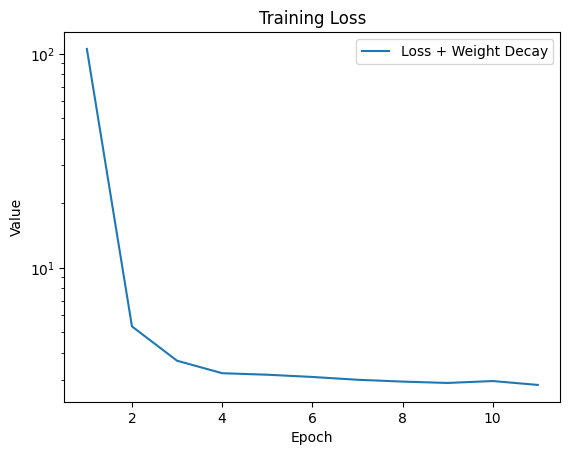

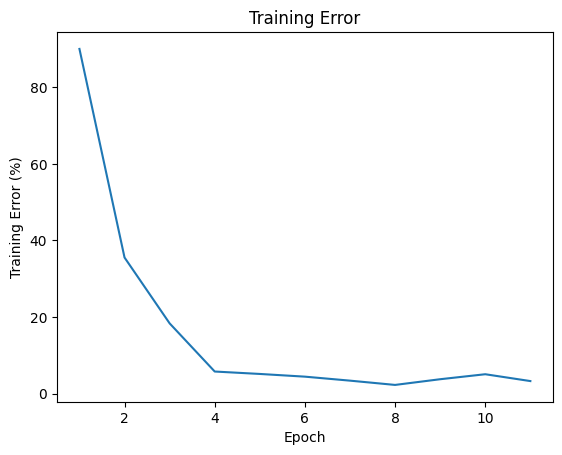

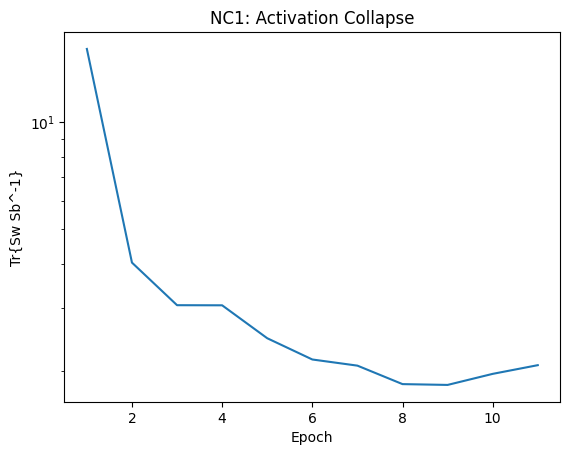

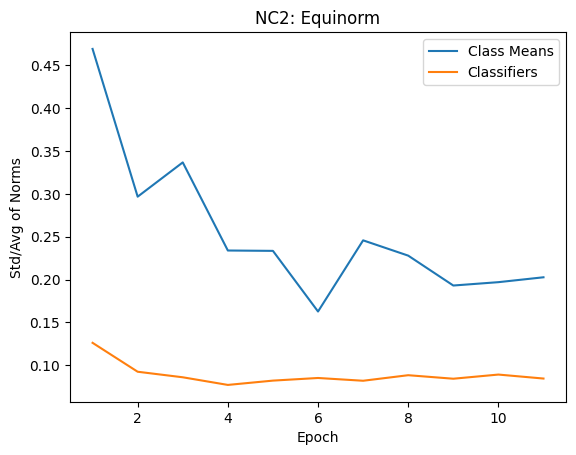

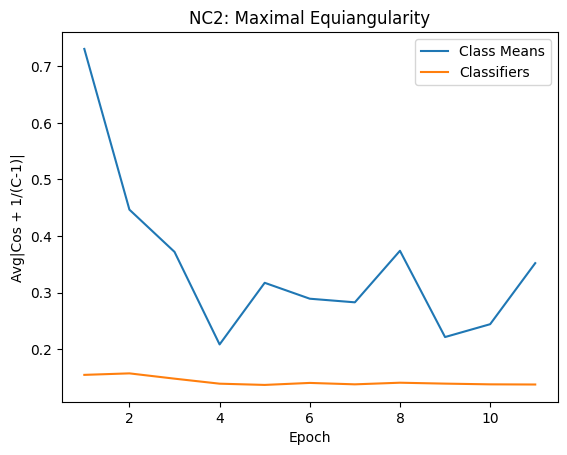

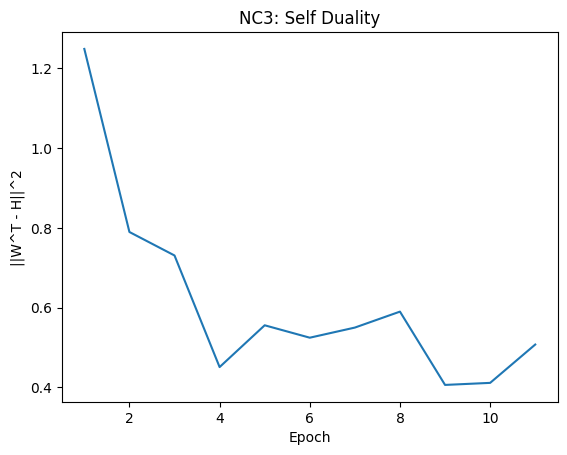

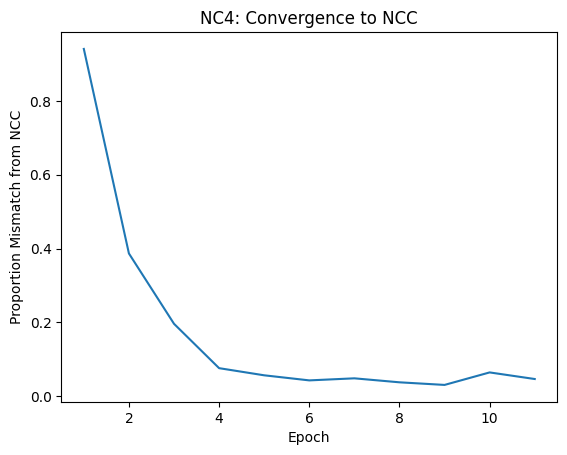

Train		Epoch: 12 [21/469 (4%)] 	Batch Loss: 0.025087 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:05<01:48,  4.13it/s]
Analysis Cov	Epoch: 12 [21/469 (4%)]:   4%|▍         | 21/469 [00:03<01:23,  5.34it/s]


abc1_12.png
abc2_12.png
abc3_12.png
abc4_12.png
abc5_12.png
abc6_12.png
abc7_12.png


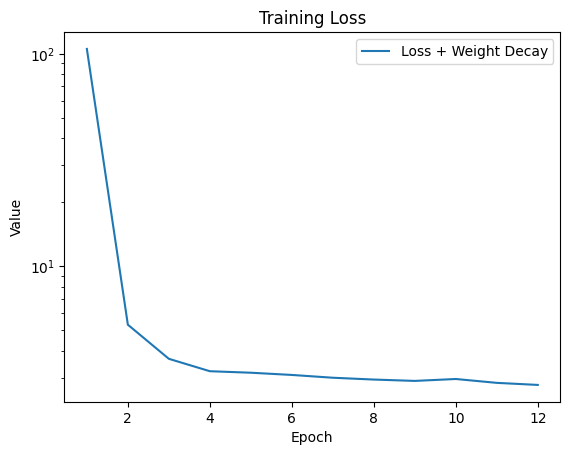

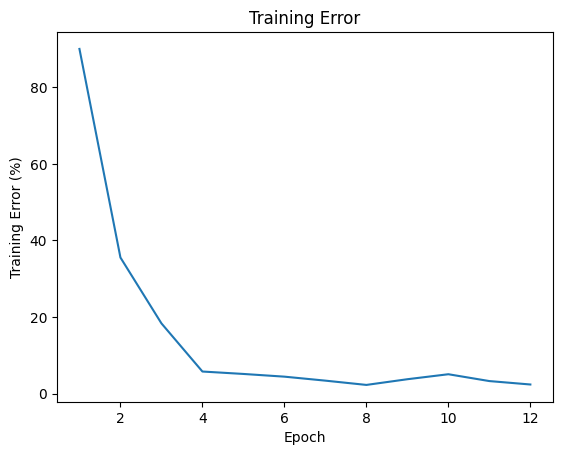

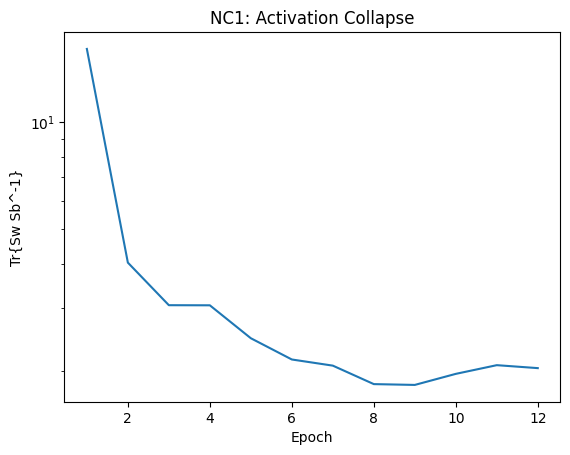

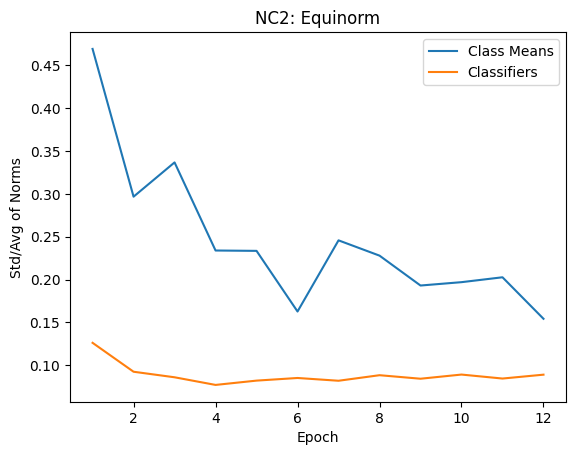

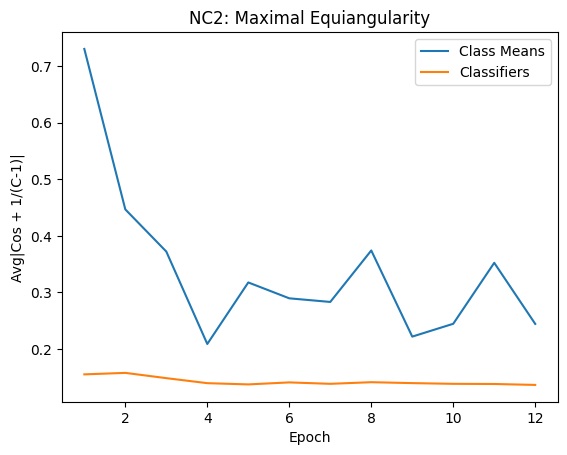

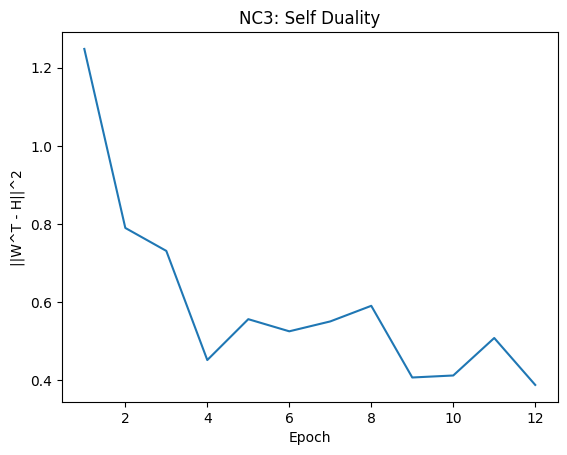

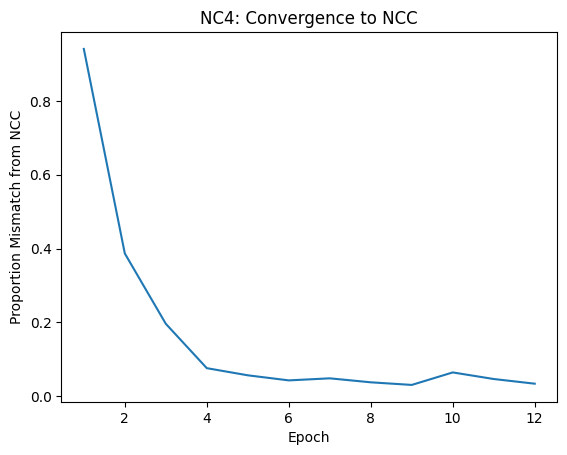

Train		Epoch: 13 [21/469 (4%)] 	Batch Loss: 0.031373 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:15,  5.96it/s]
Analysis Cov	Epoch: 13 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:50,  8.84it/s]


abc1_13.png
abc2_13.png
abc3_13.png
abc4_13.png
abc5_13.png
abc6_13.png
abc7_13.png


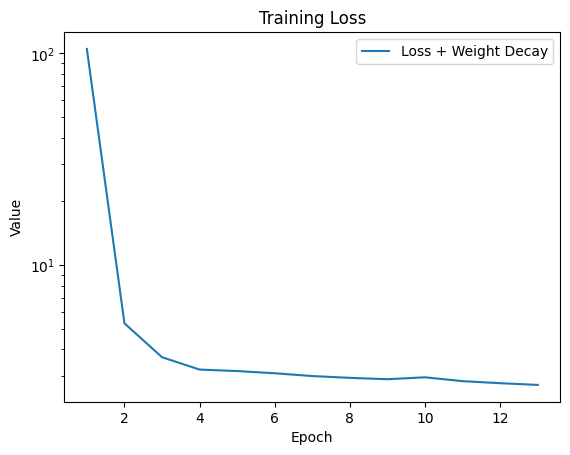

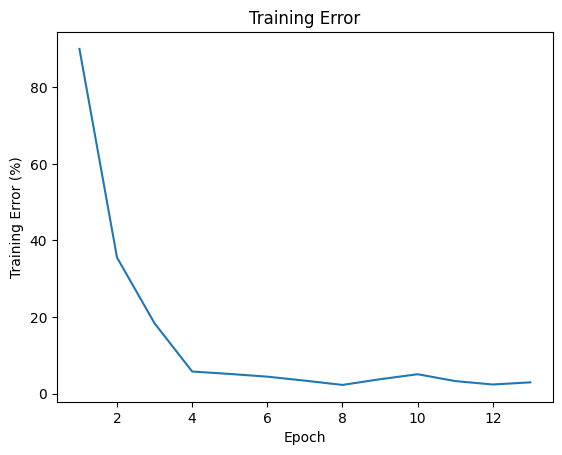

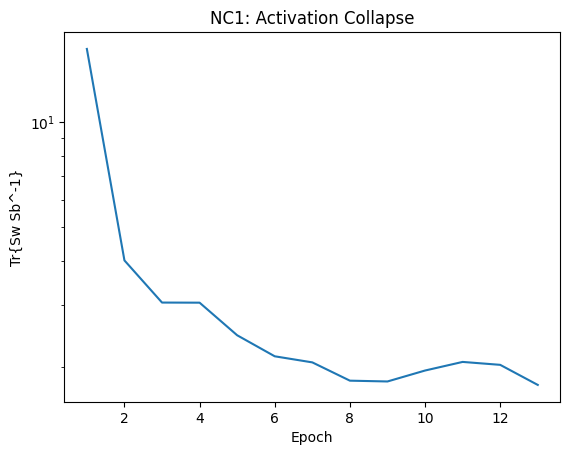

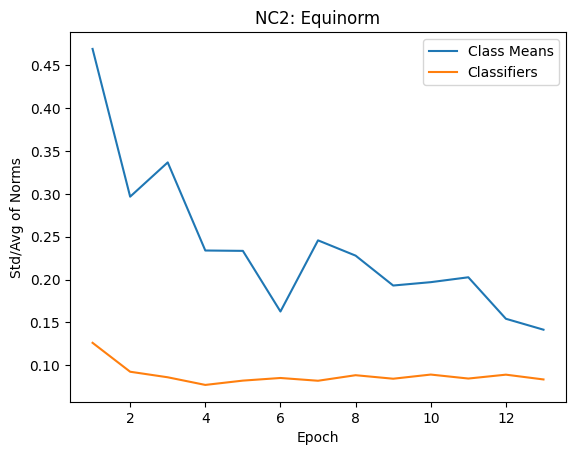

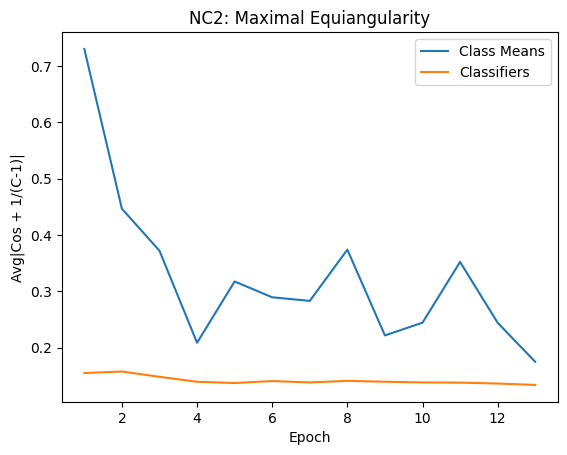

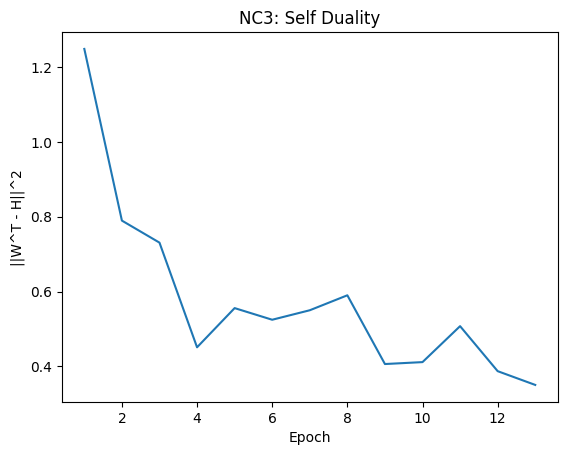

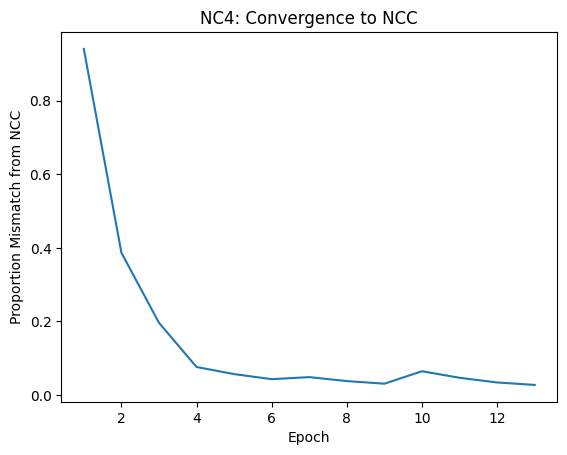

Train		Epoch: 14 [21/469 (4%)] 	Batch Loss: 0.048777 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:11,  6.26it/s]
Analysis Cov	Epoch: 14 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:41, 10.84it/s]


abc1_14.png
abc2_14.png
abc3_14.png
abc4_14.png
abc5_14.png
abc6_14.png
abc7_14.png


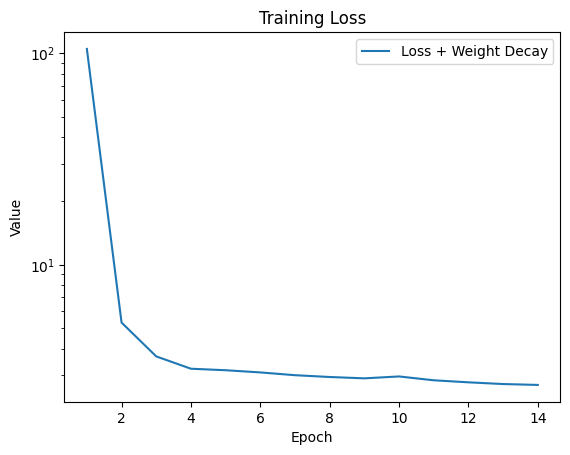

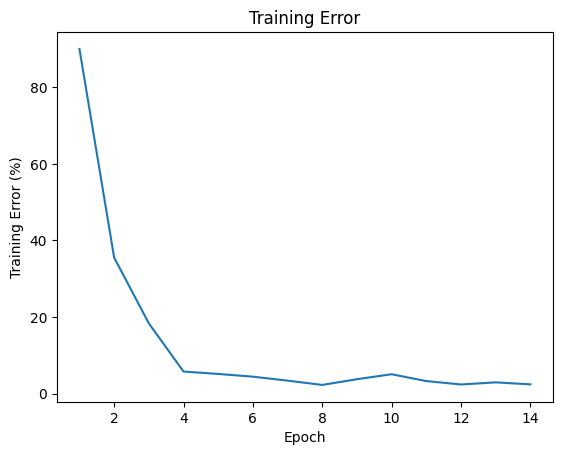

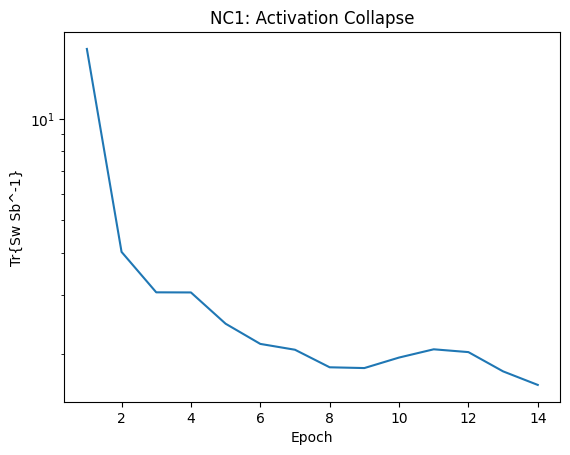

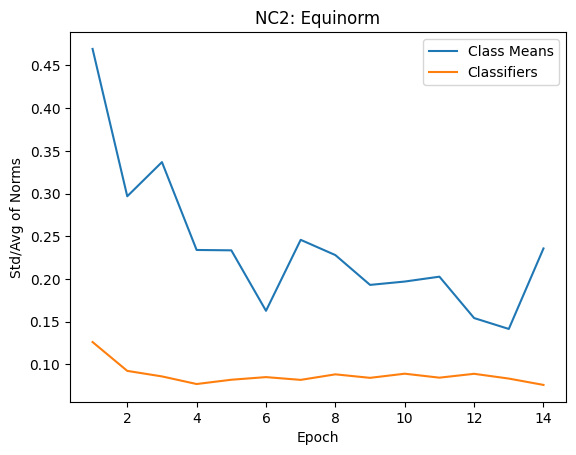

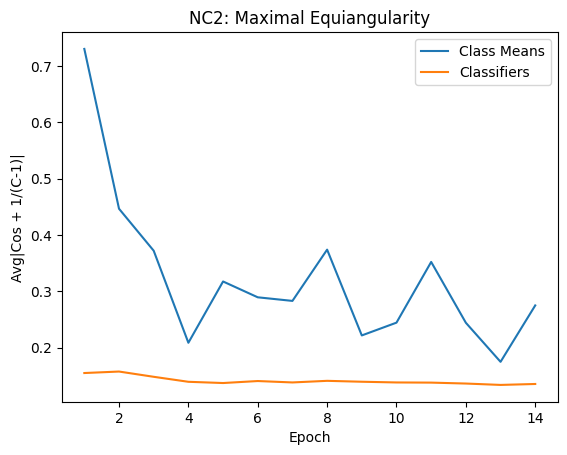

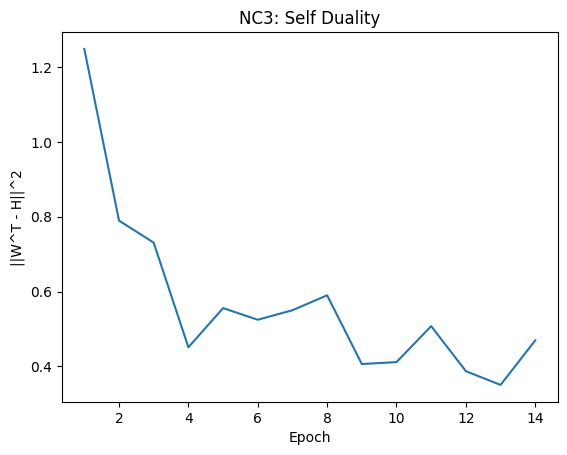

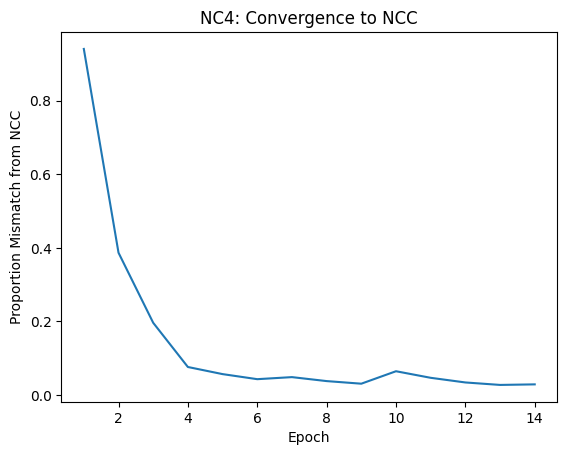

Train		Epoch: 15 [21/469 (4%)] 	Batch Loss: 0.051232 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:15,  5.96it/s]
Train		Epoch: 16 [21/469 (4%)] 	Batch Loss: 0.010246 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Analysis Cov	Epoch: 16 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.57it/s]


abc1_16.png
abc2_16.png
abc3_16.png
abc4_16.png
abc5_16.png
abc6_16.png
abc7_16.png


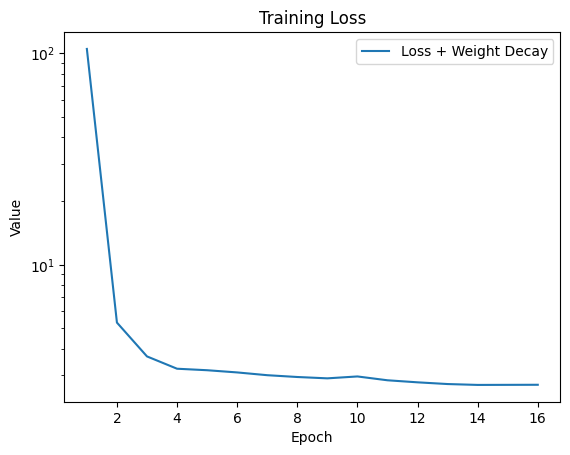

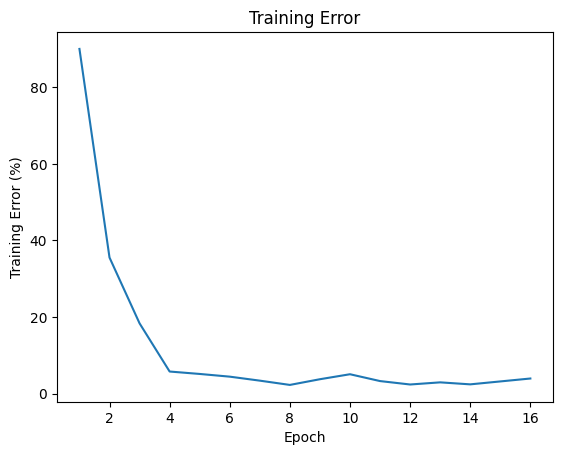

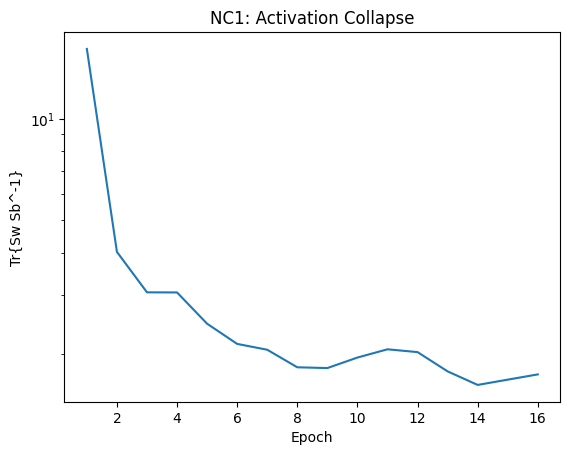

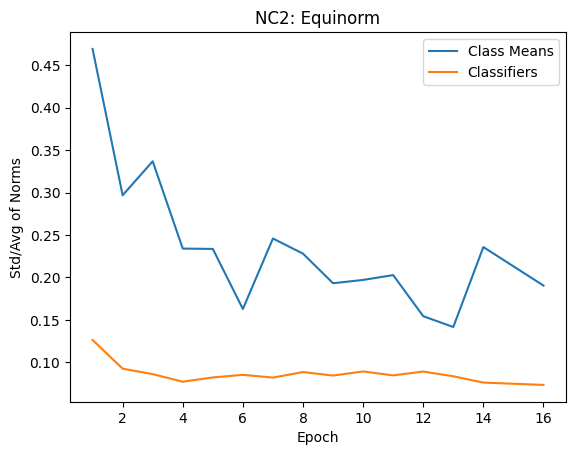

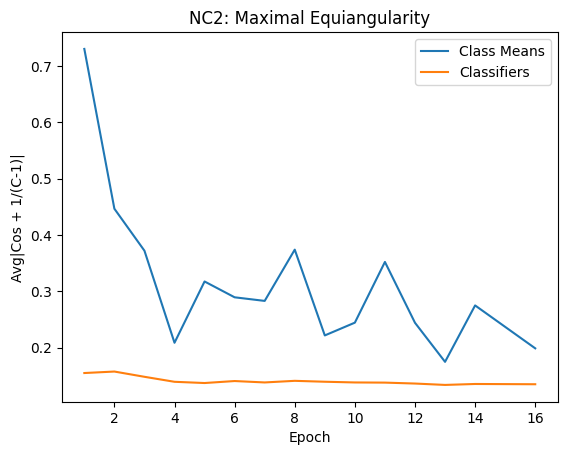

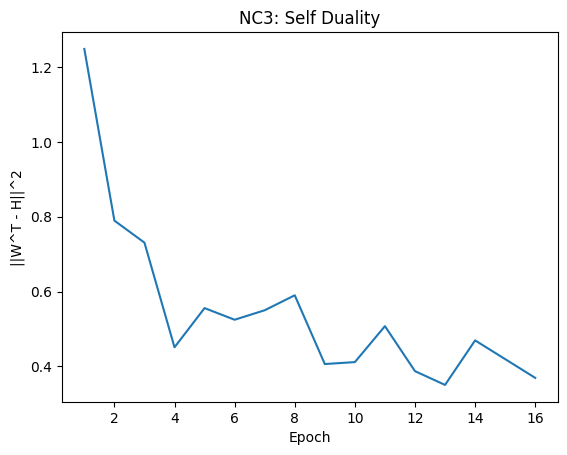

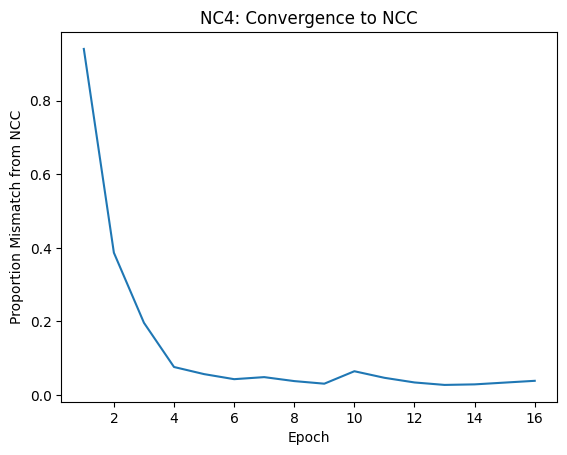

Train		Epoch: 17 [21/469 (4%)] 	Batch Loss: 0.041742 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:10,  6.38it/s]
Analysis Cov	Epoch: 17 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:47,  9.41it/s]


abc1_17.png
abc2_17.png
abc3_17.png
abc4_17.png
abc5_17.png
abc6_17.png
abc7_17.png


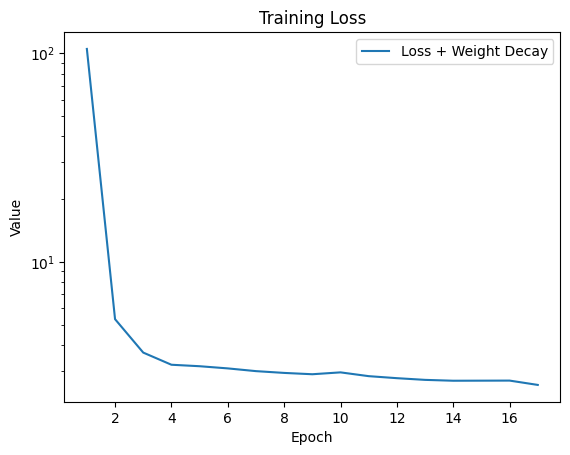

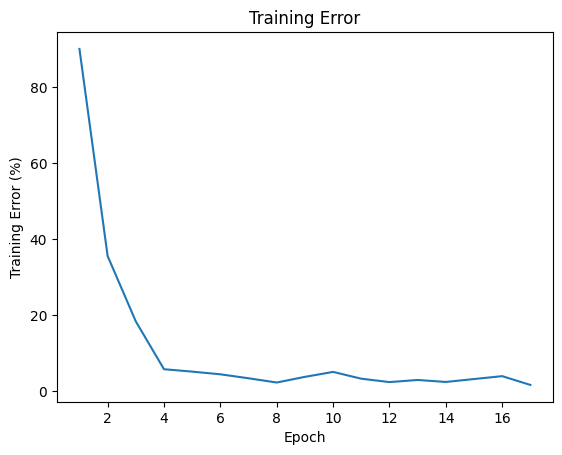

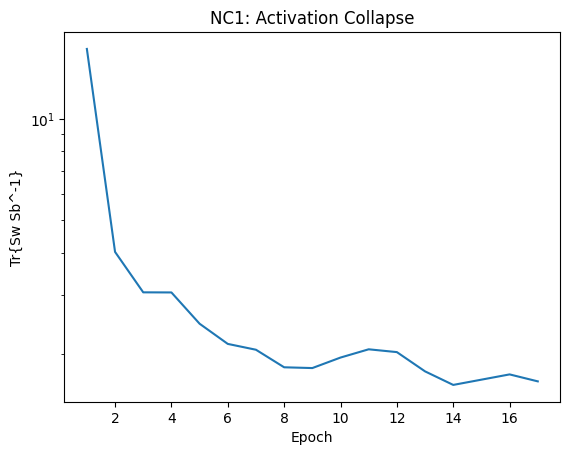

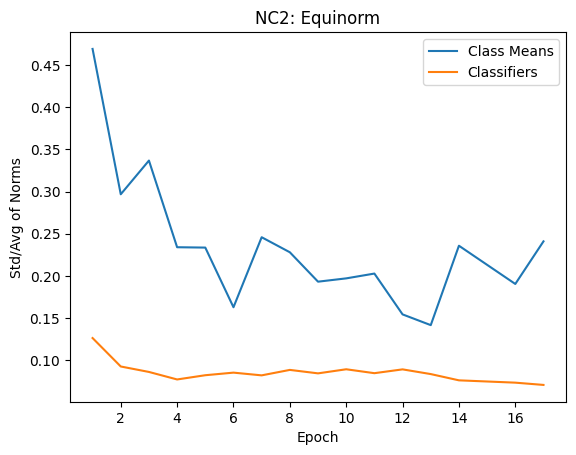

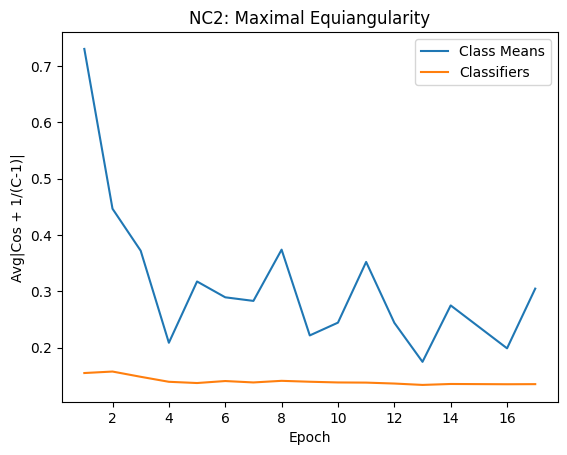

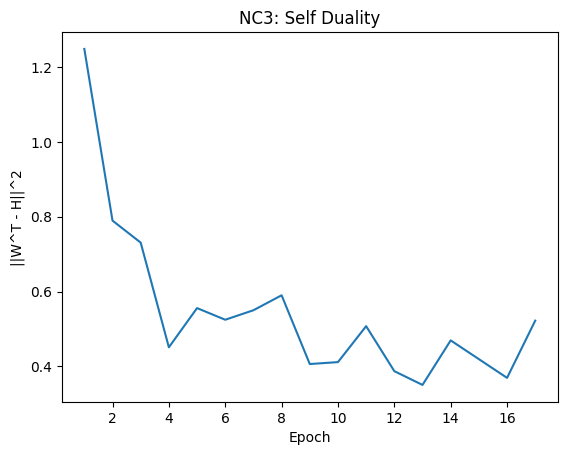

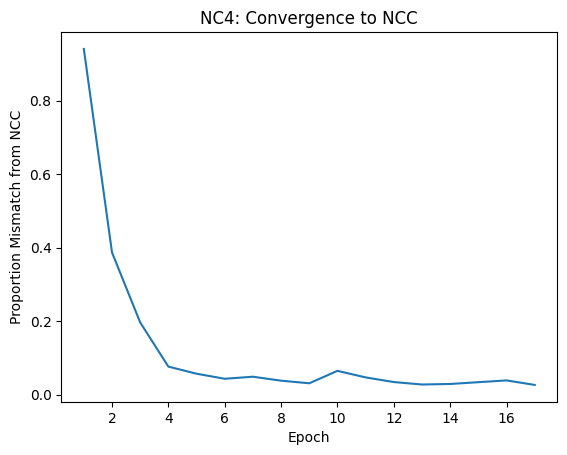

Train		Epoch: 18 [21/469 (4%)] 	Batch Loss: 0.063471 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:14,  5.99it/s]
Train		Epoch: 19 [21/469 (4%)] 	Batch Loss: 0.026346 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.41it/s]
Analysis Cov	Epoch: 19 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:40, 11.01it/s]


abc1_19.png
abc2_19.png
abc3_19.png
abc4_19.png
abc5_19.png
abc6_19.png
abc7_19.png


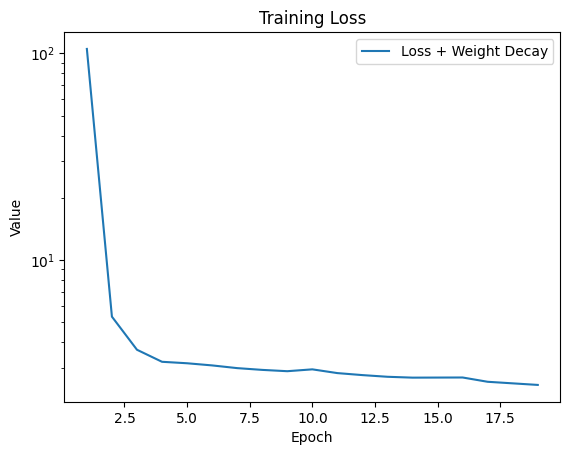

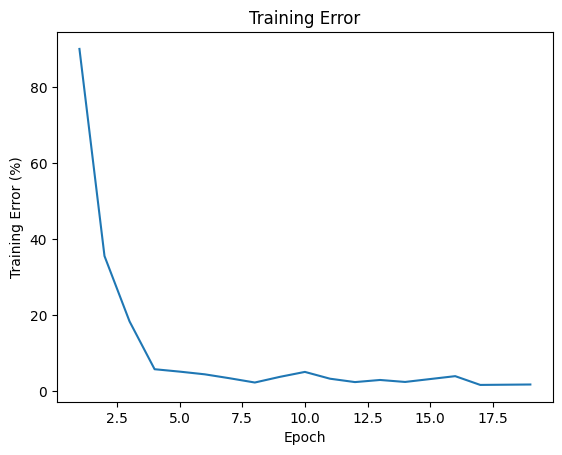

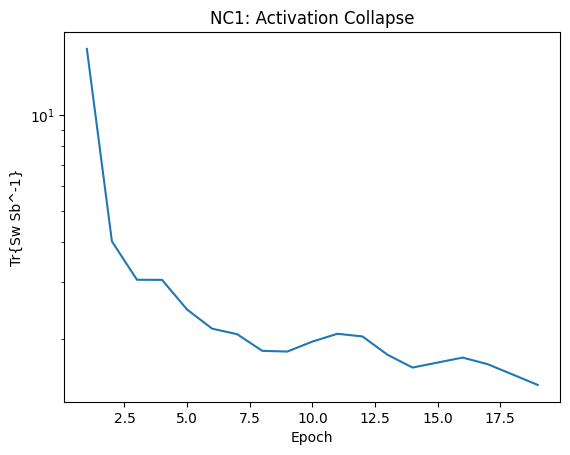

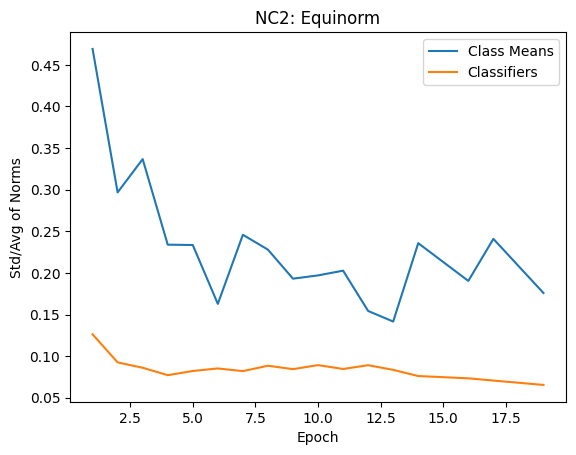

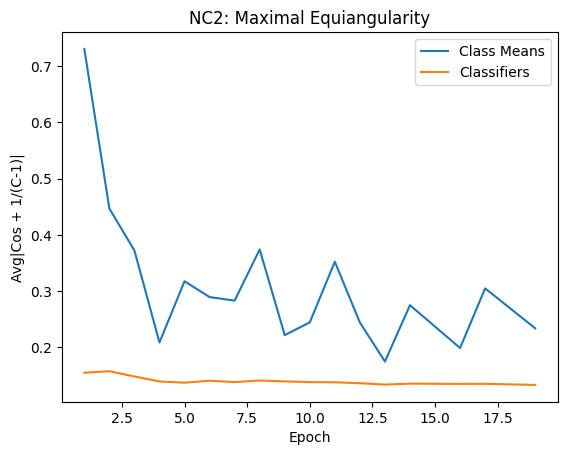

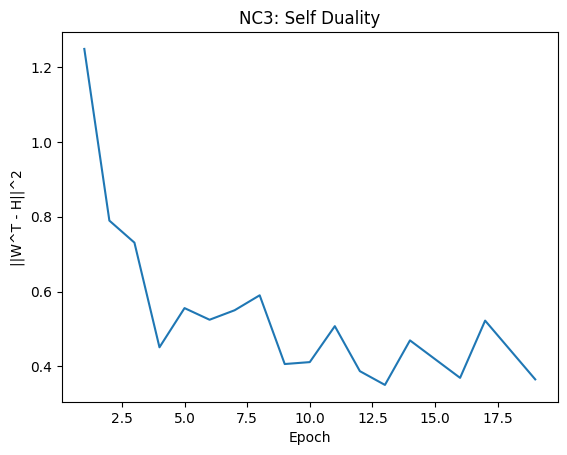

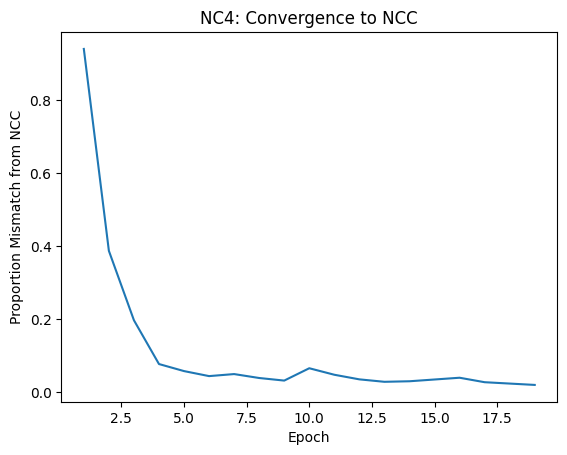

Train		Epoch: 20 [21/469 (4%)] 	Batch Loss: 0.035883 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:13,  6.07it/s]
Analysis Cov	Epoch: 20 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:47,  9.48it/s]


abc1_20.png
abc2_20.png
abc3_20.png
abc4_20.png
abc5_20.png
abc6_20.png
abc7_20.png


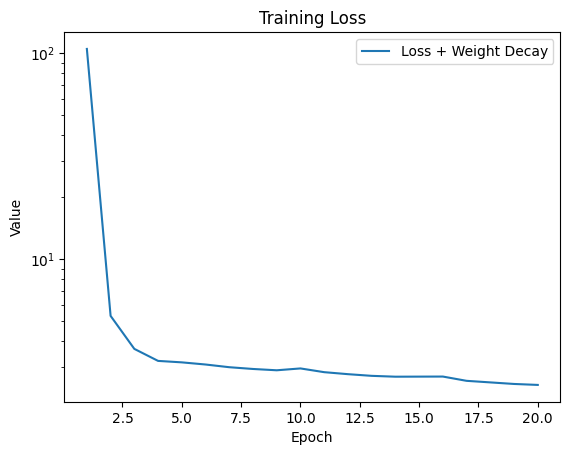

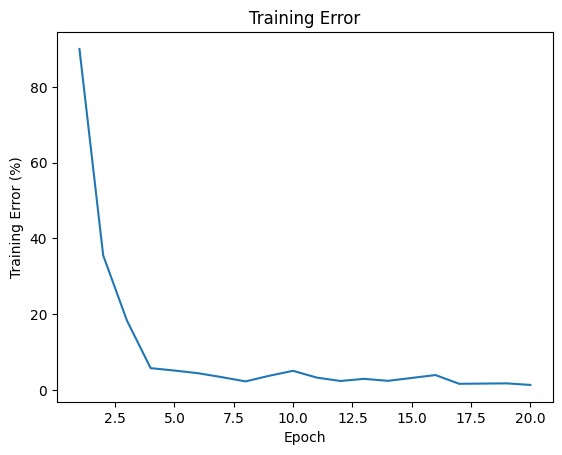

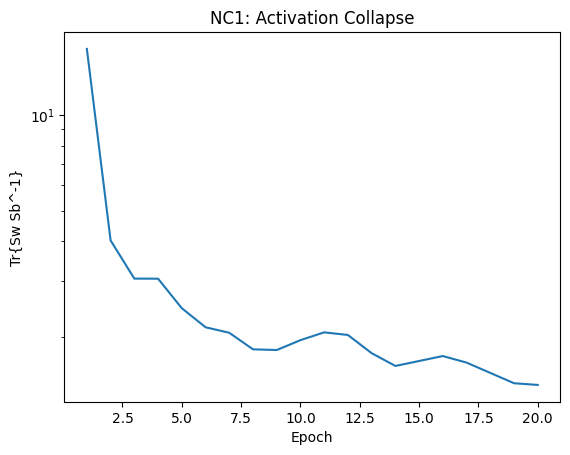

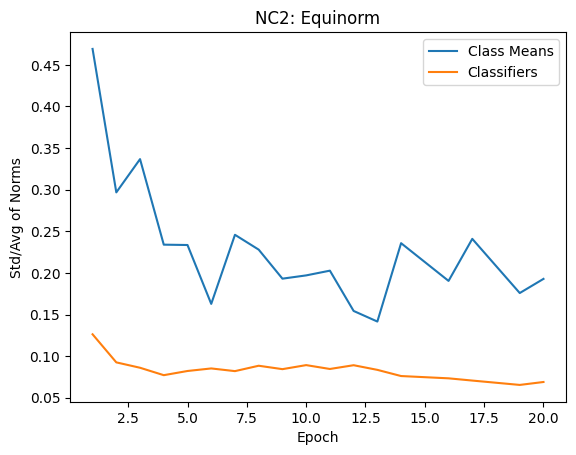

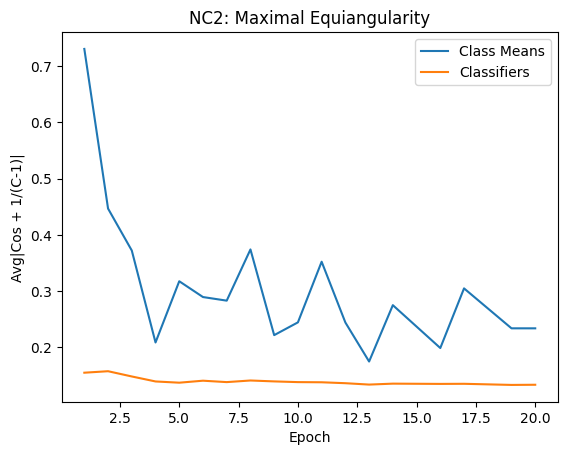

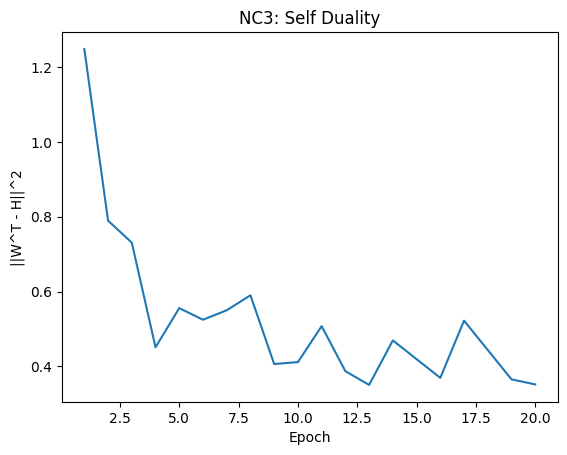

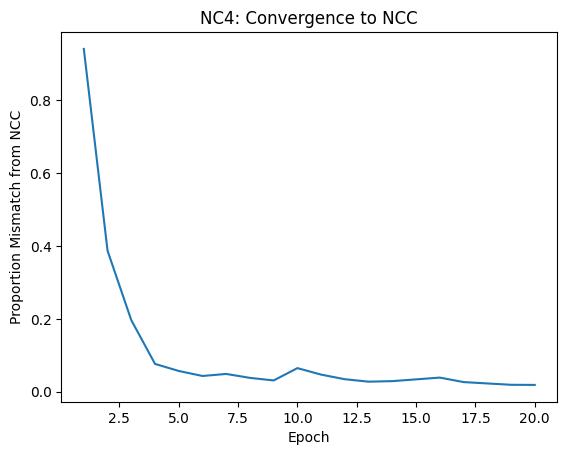

Train		Epoch: 21 [21/469 (4%)] 	Batch Loss: 0.093616 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:03<01:10,  6.35it/s]
Train		Epoch: 22 [21/469 (4%)] 	Batch Loss: 0.099275 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.49it/s]
Analysis Cov	Epoch: 22 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:45,  9.84it/s]


abc1_22.png
abc2_22.png
abc3_22.png
abc4_22.png
abc5_22.png
abc6_22.png
abc7_22.png


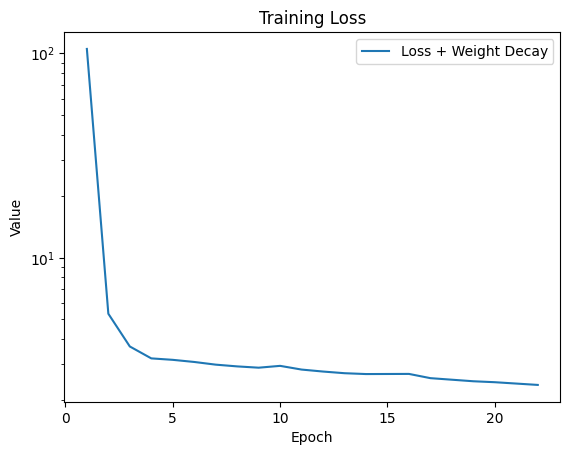

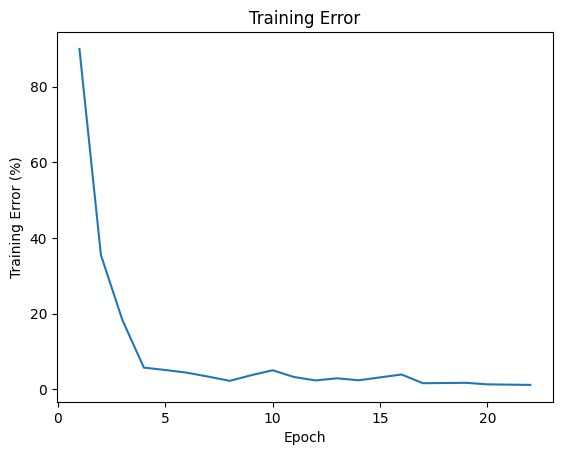

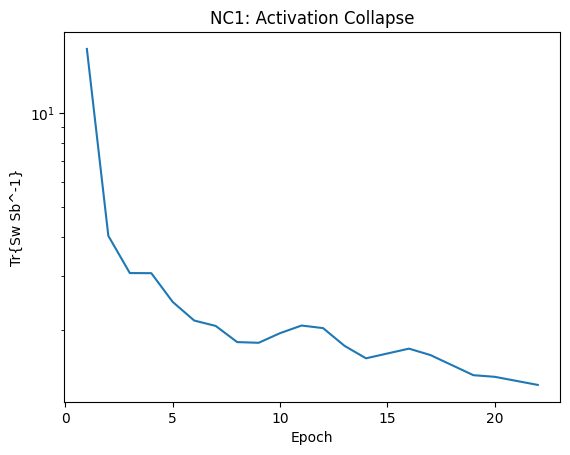

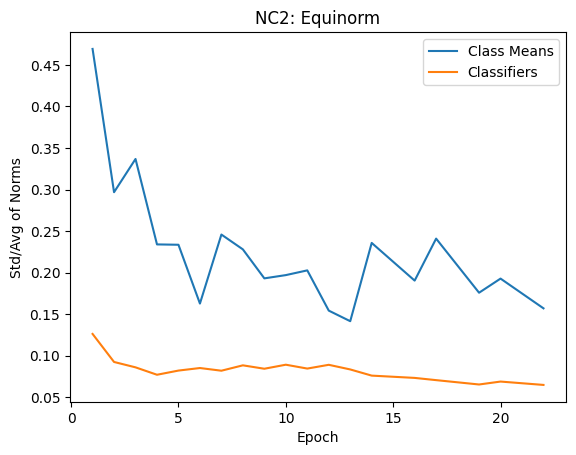

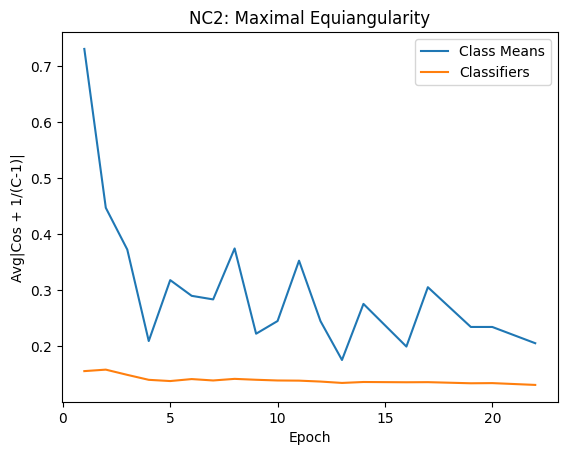

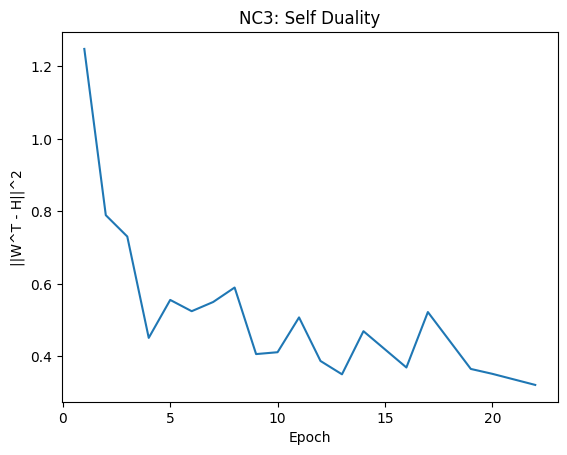

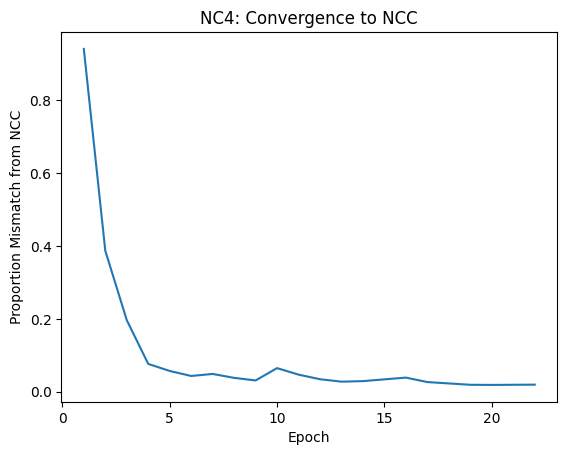

Train		Epoch: 23 [21/469 (4%)] 	Batch Loss: 0.009418 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:14,  6.02it/s]
Train		Epoch: 24 [21/469 (4%)] 	Batch Loss: 0.107529 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:14,  5.99it/s]
Analysis Cov	Epoch: 24 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:44, 10.16it/s]


abc1_24.png
abc2_24.png
abc3_24.png
abc4_24.png
abc5_24.png
abc6_24.png
abc7_24.png


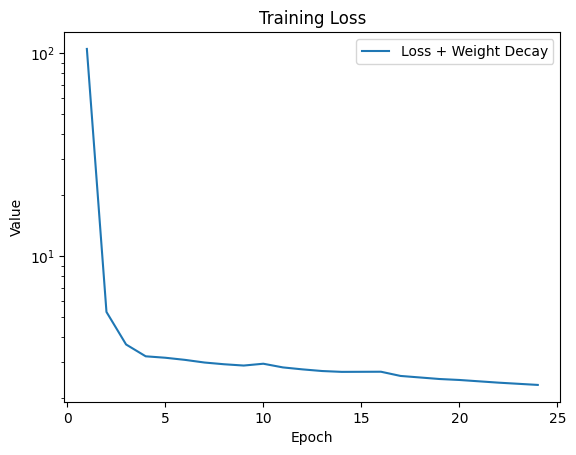

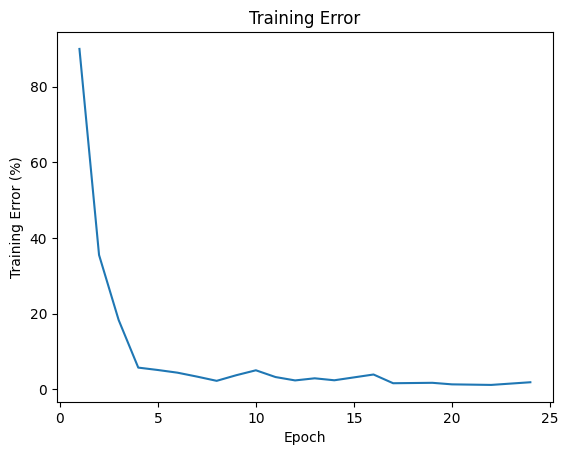

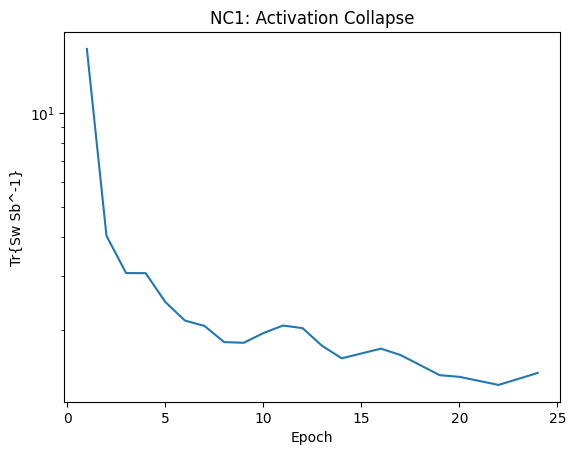

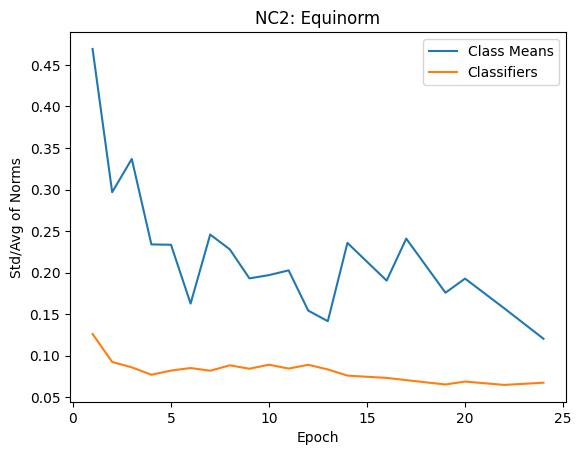

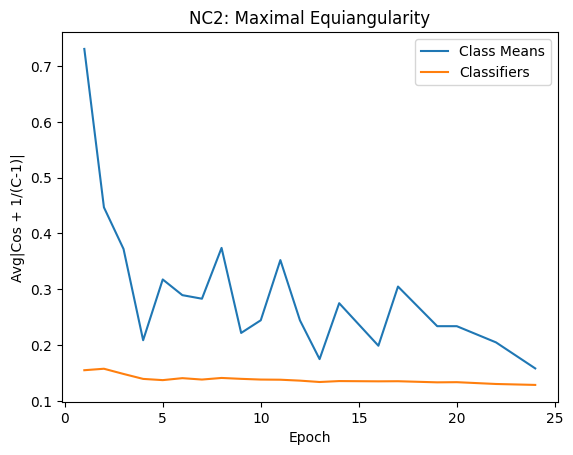

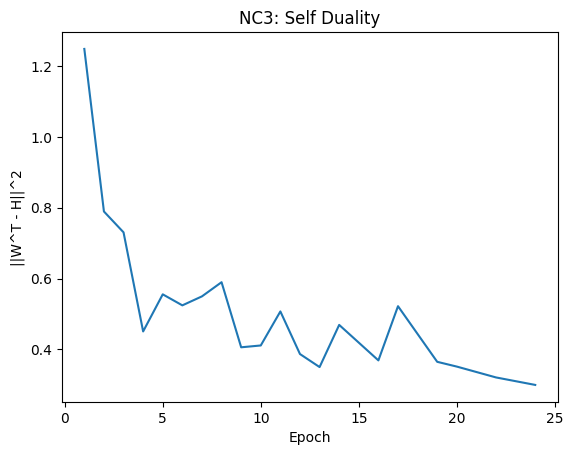

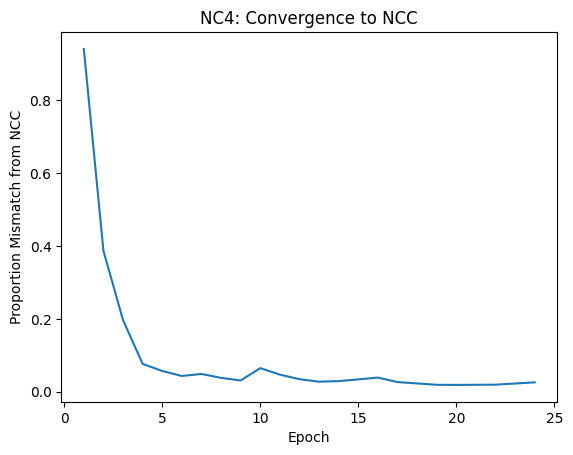

Train		Epoch: 25 [21/469 (4%)] 	Batch Loss: 0.022429 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:24,  5.33it/s]
Train		Epoch: 26 [21/469 (4%)] 	Batch Loss: 0.085404 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:03<01:09,  6.49it/s]
Train		Epoch: 27 [21/469 (4%)] 	Batch Loss: 0.065519 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:12,  6.15it/s]
Analysis Cov	Epoch: 27 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:49,  9.14it/s]


abc1_27.png
abc2_27.png
abc3_27.png
abc4_27.png
abc5_27.png
abc6_27.png
abc7_27.png


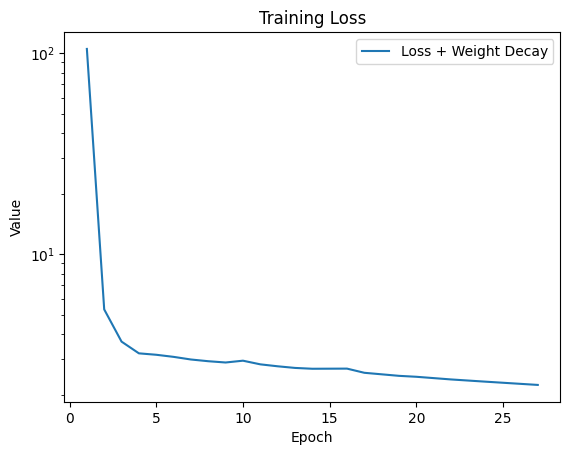

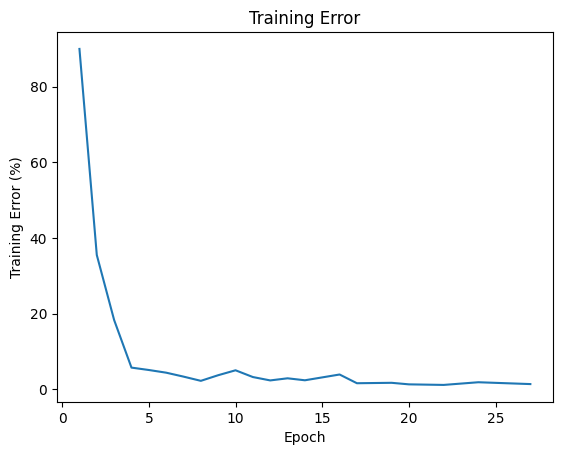

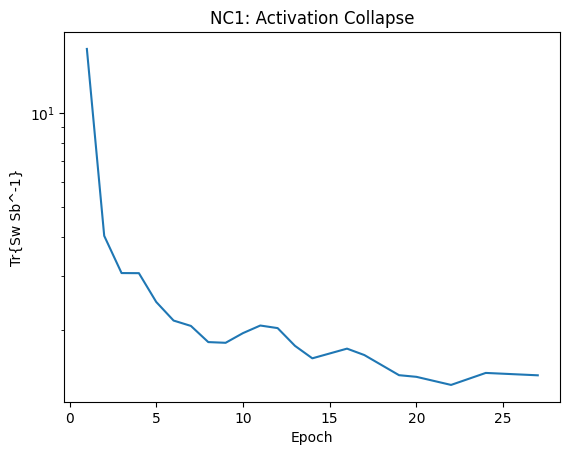

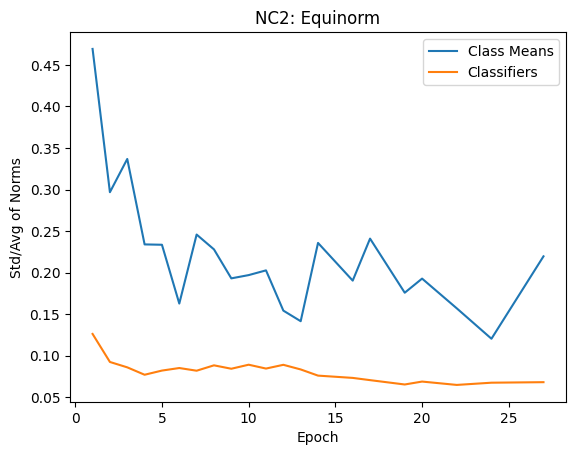

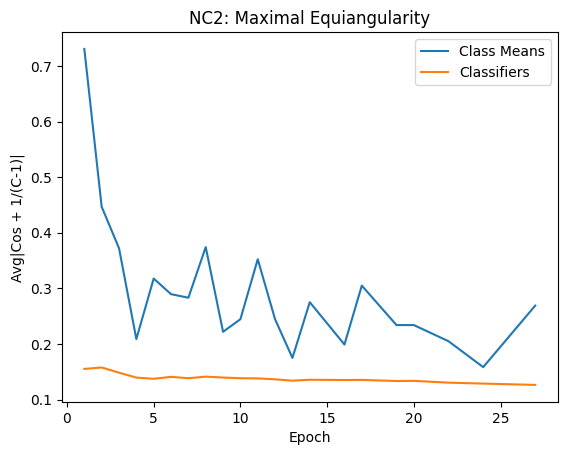

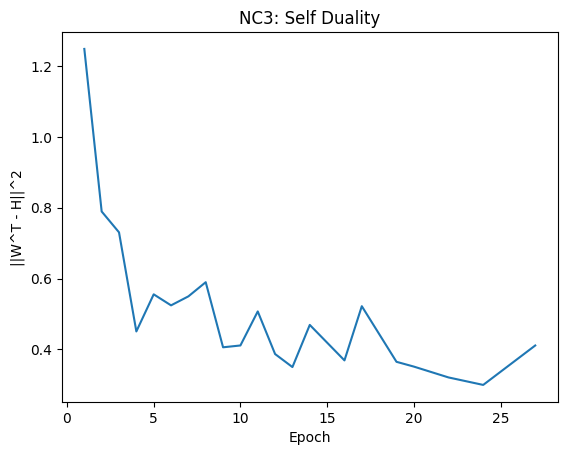

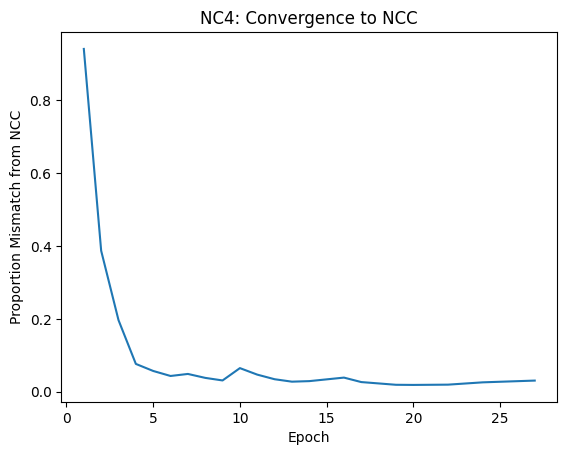

Train		Epoch: 28 [21/469 (4%)] 	Batch Loss: 0.098887 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:18,  5.74it/s]
Train		Epoch: 29 [21/469 (4%)] 	Batch Loss: 0.025070 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:09,  6.41it/s]
Analysis Cov	Epoch: 29 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:44, 10.17it/s]


abc1_29.png
abc2_29.png
abc3_29.png
abc4_29.png
abc5_29.png
abc6_29.png
abc7_29.png


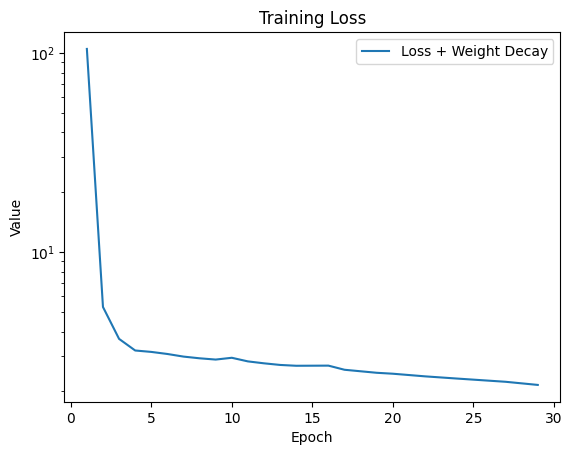

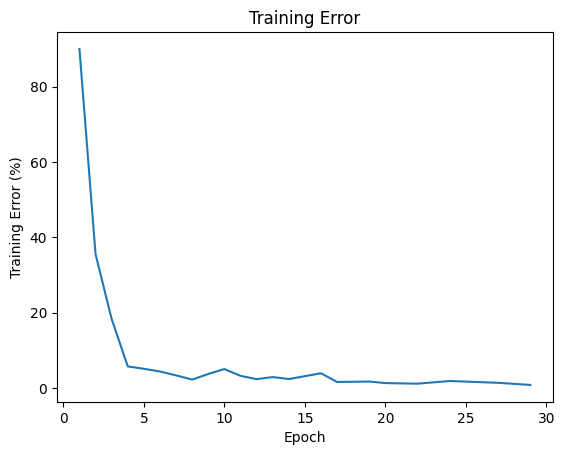

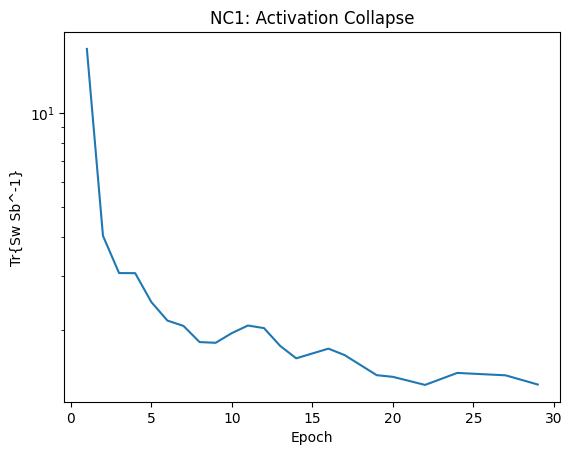

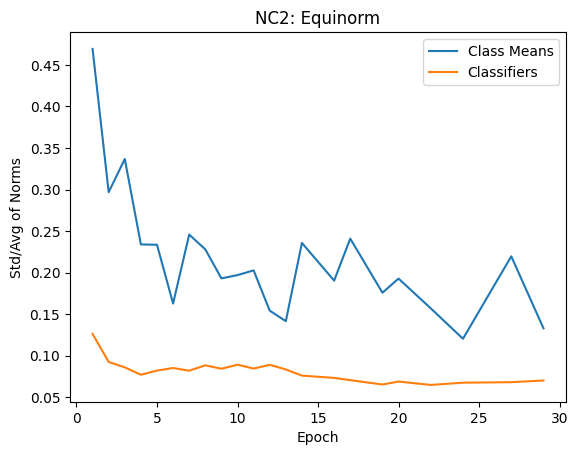

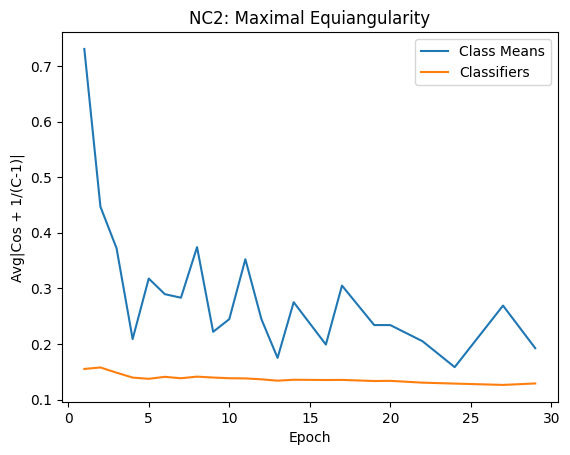

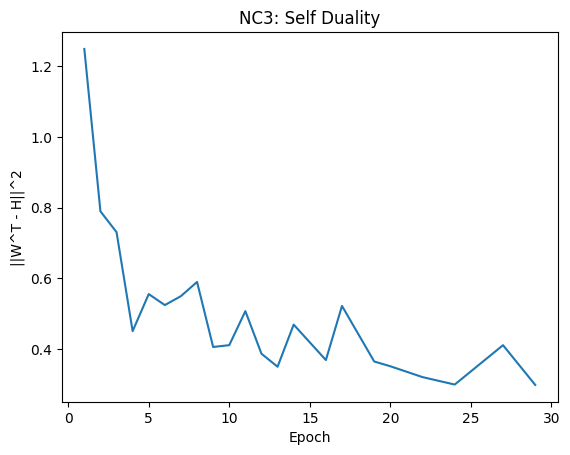

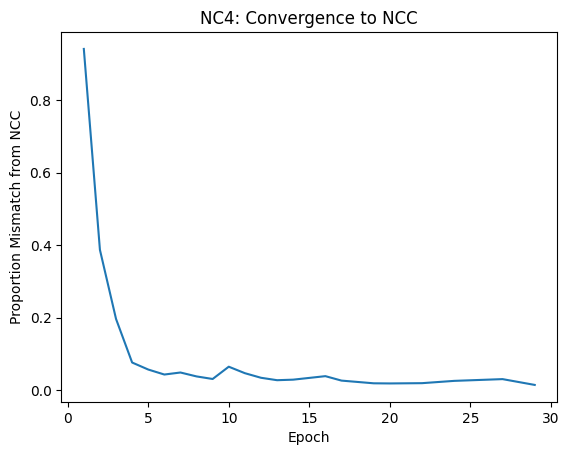

Train		Epoch: 30 [21/469 (4%)] 	Batch Loss: 0.017081 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.18it/s]
Train		Epoch: 31 [21/469 (4%)] 	Batch Loss: 0.008440 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.46it/s]
Train		Epoch: 32 [21/469 (4%)] 	Batch Loss: 0.030256 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Analysis Cov	Epoch: 32 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:43, 10.31it/s]


abc1_32.png
abc2_32.png
abc3_32.png
abc4_32.png
abc5_32.png
abc6_32.png
abc7_32.png


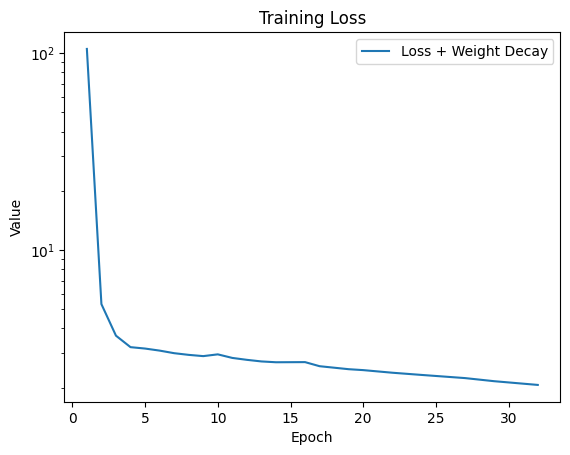

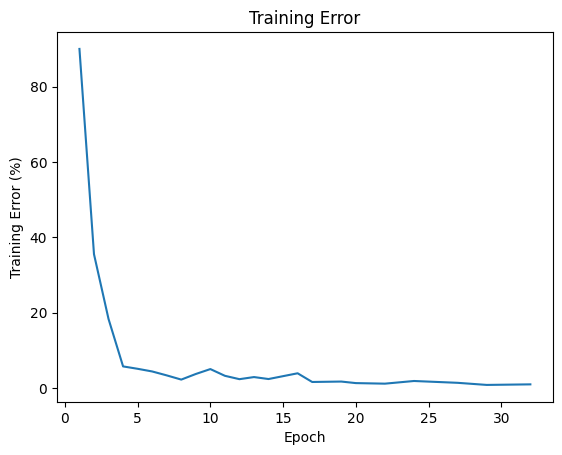

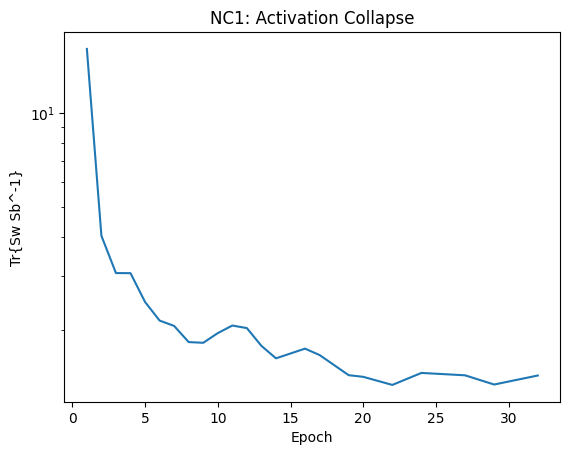

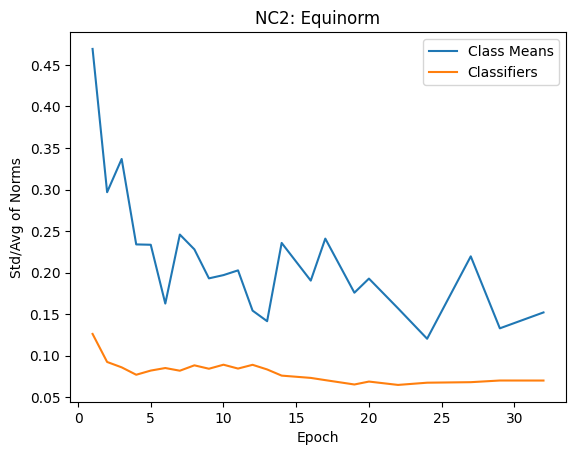

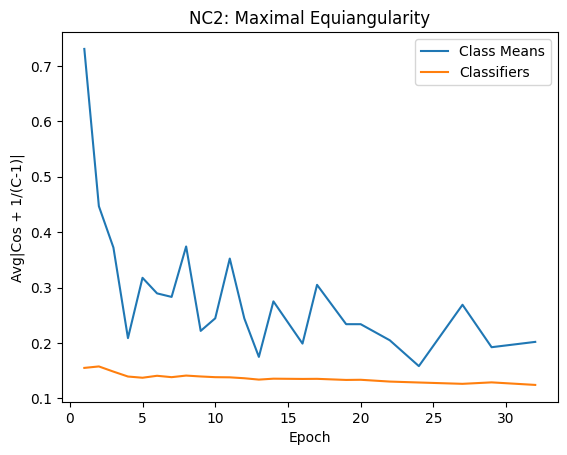

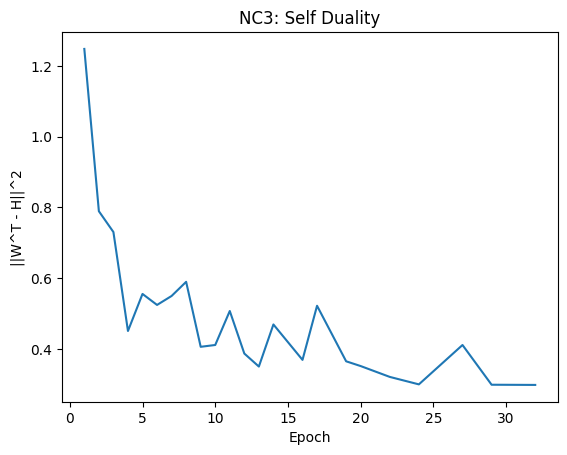

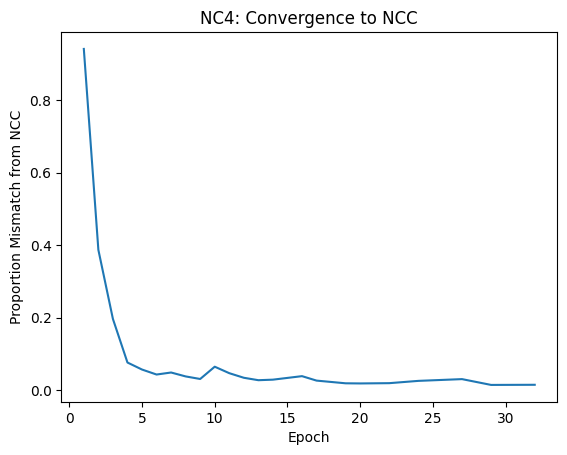

Train		Epoch: 33 [21/469 (4%)] 	Batch Loss: 0.020558 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:14,  6.01it/s]
Train		Epoch: 34 [21/469 (4%)] 	Batch Loss: 0.054427 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:13,  6.13it/s]
Train		Epoch: 35 [21/469 (4%)] 	Batch Loss: 0.035686 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Analysis Cov	Epoch: 35 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:41, 10.68it/s]


abc1_35.png
abc2_35.png
abc3_35.png
abc4_35.png
abc5_35.png
abc6_35.png
abc7_35.png


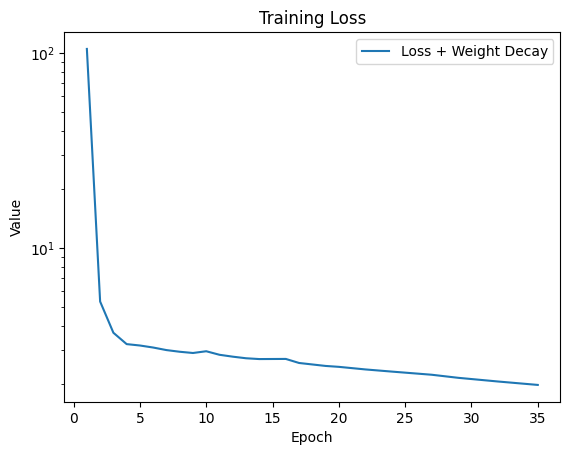

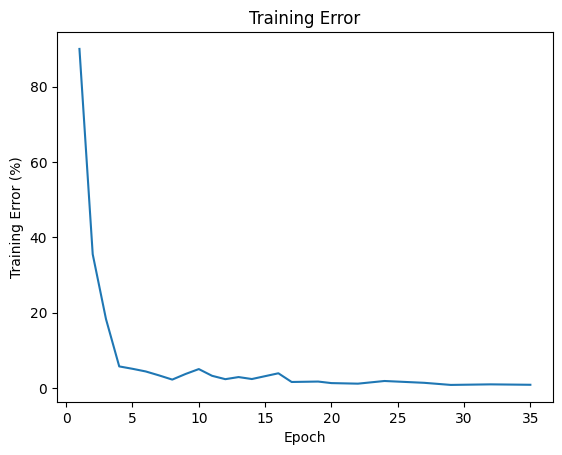

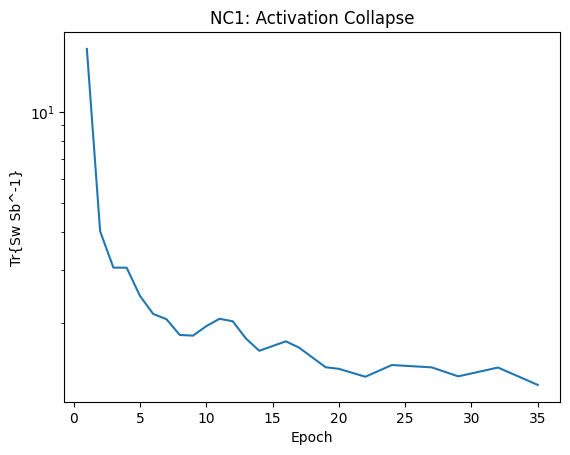

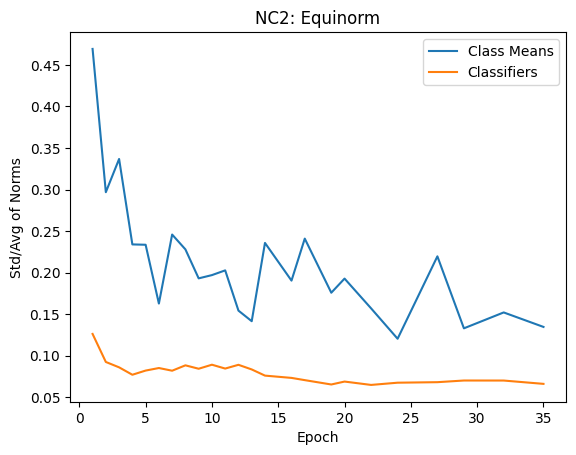

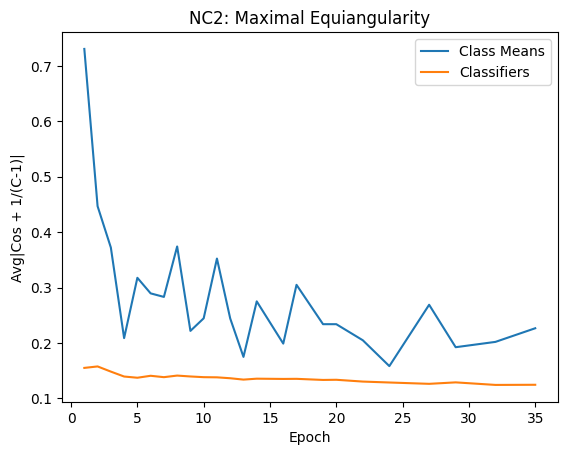

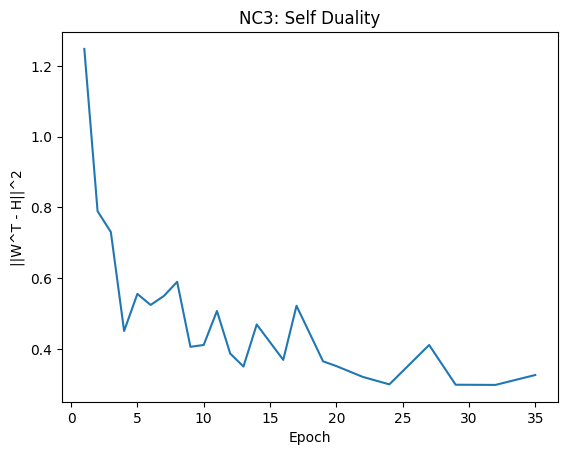

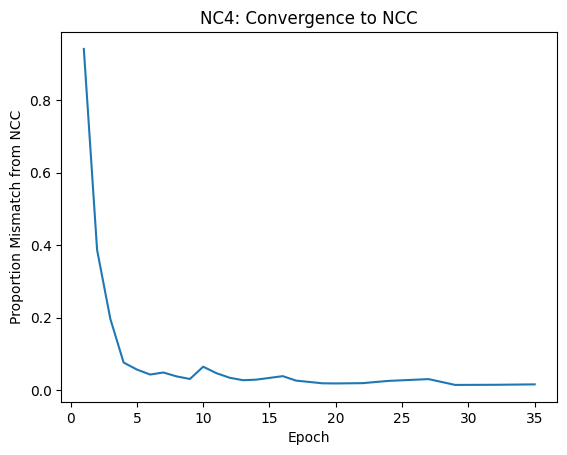

Train		Epoch: 36 [21/469 (4%)] 	Batch Loss: 0.017978 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.14it/s]
Train		Epoch: 37 [21/469 (4%)] 	Batch Loss: 0.003481 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:15,  5.96it/s]
Train		Epoch: 38 [21/469 (4%)] 	Batch Loss: 0.004058 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:13,  6.08it/s]
Analysis Cov	Epoch: 38 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:41, 10.78it/s]


abc1_38.png
abc2_38.png
abc3_38.png
abc4_38.png
abc5_38.png
abc6_38.png
abc7_38.png


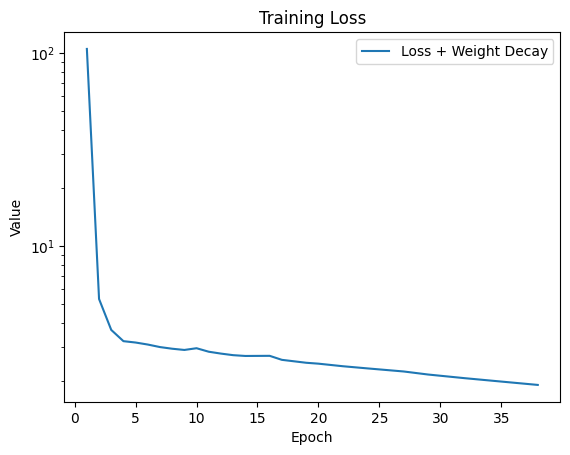

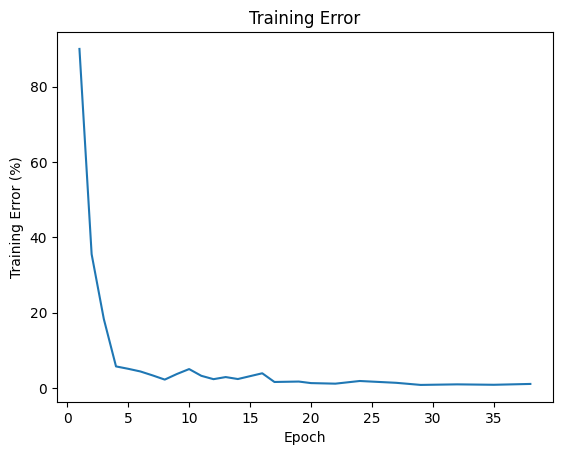

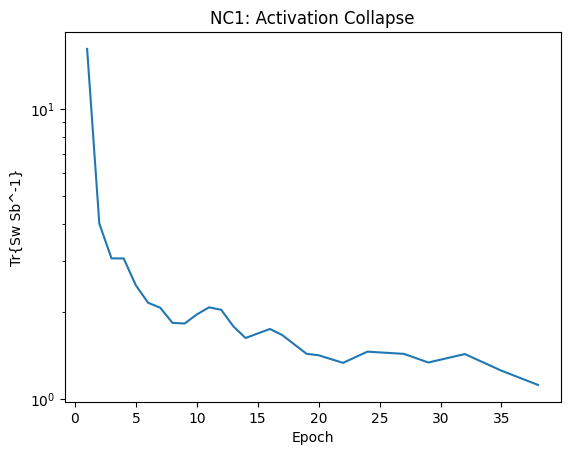

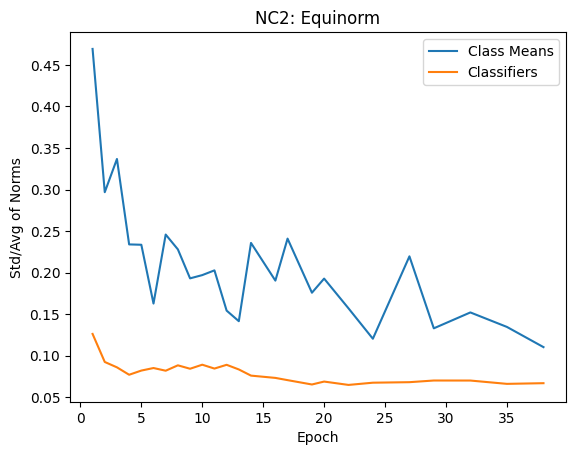

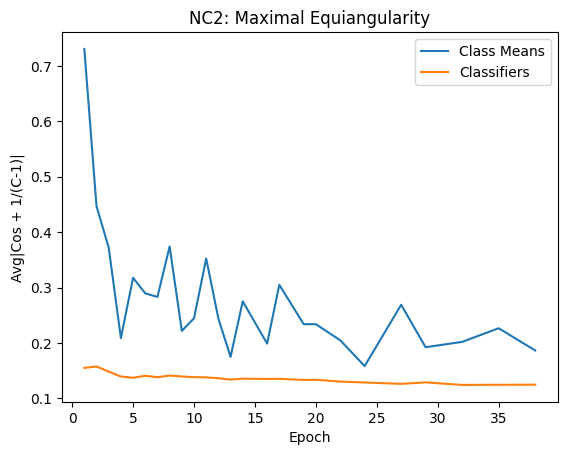

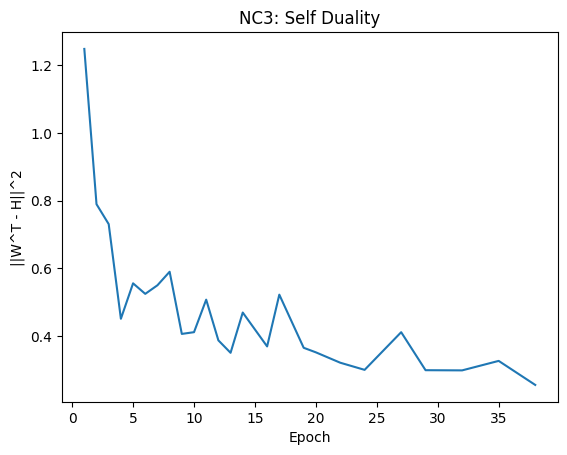

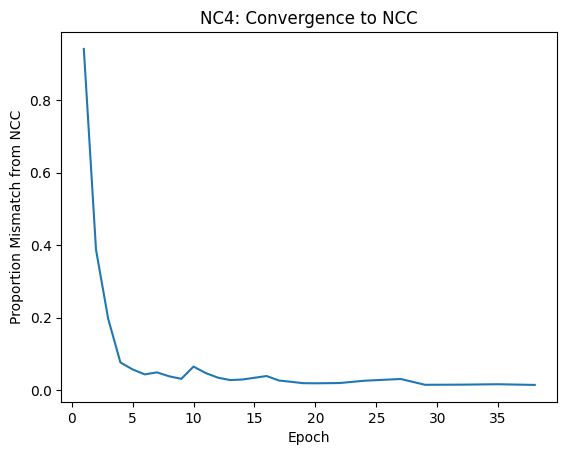

Train		Epoch: 39 [21/469 (4%)] 	Batch Loss: 0.005758 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Train		Epoch: 40 [21/469 (4%)] 	Batch Loss: 0.009592 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.47it/s]
Train		Epoch: 41 [21/469 (4%)] 	Batch Loss: 0.037469 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:09,  6.48it/s]
Train		Epoch: 42 [21/469 (4%)] 	Batch Loss: 0.089485 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:13,  6.13it/s]
Analysis Cov	Epoch: 42 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.51it/s]


abc1_42.png
abc2_42.png
abc3_42.png
abc4_42.png
abc5_42.png
abc6_42.png
abc7_42.png


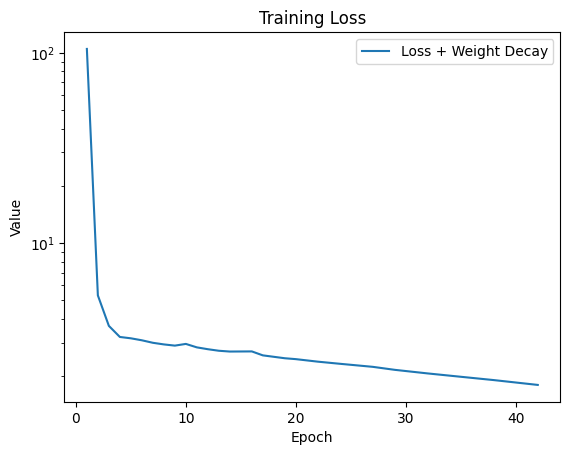

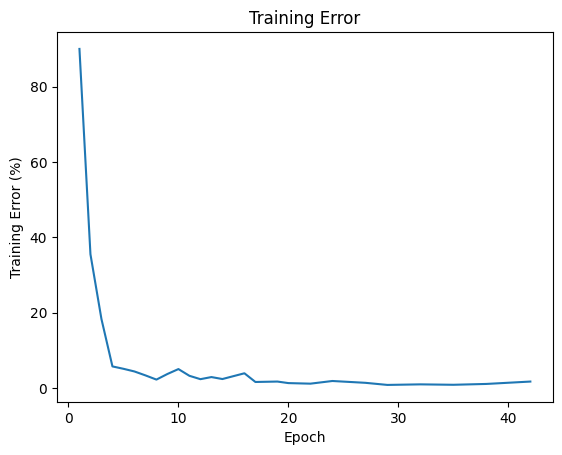

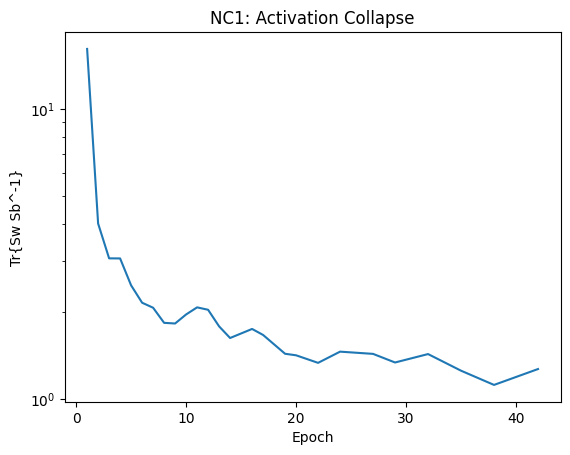

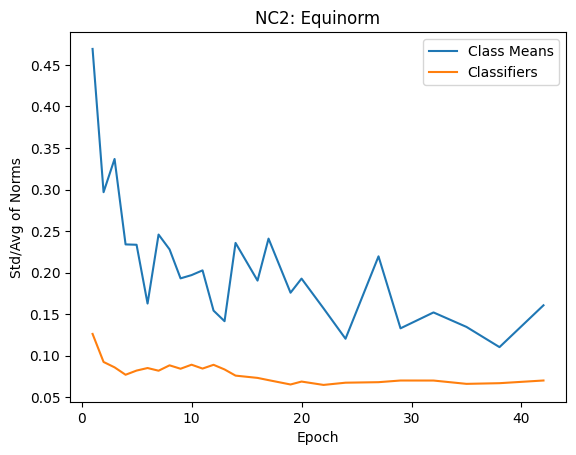

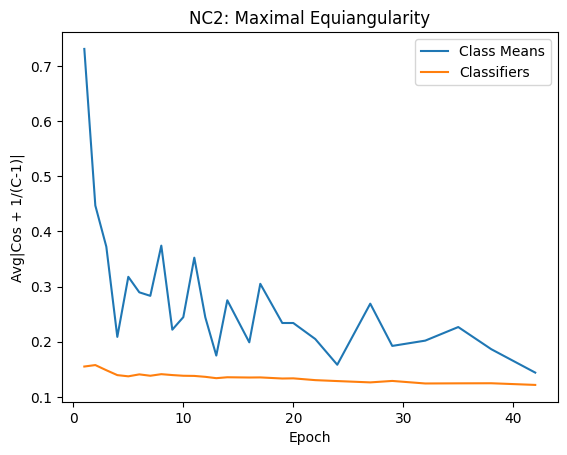

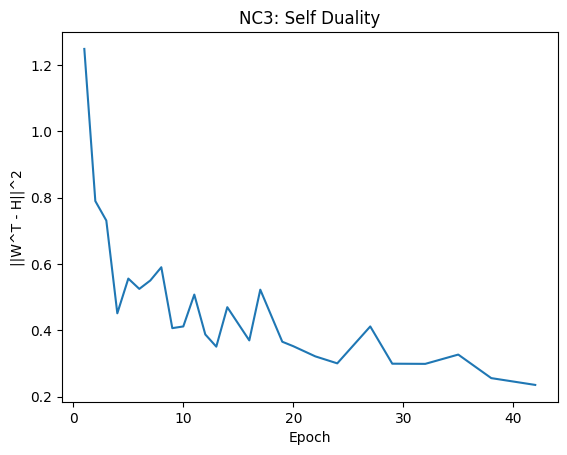

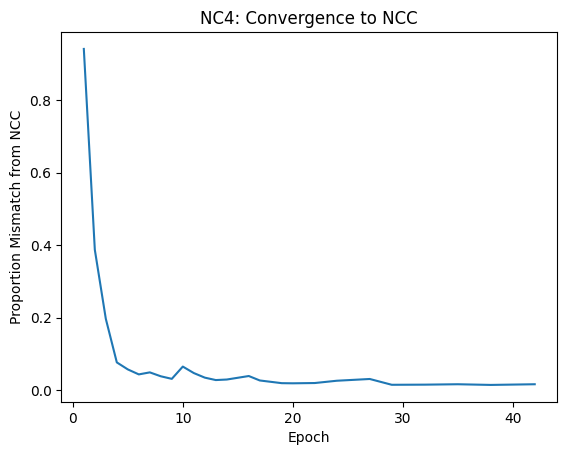

Train		Epoch: 43 [21/469 (4%)] 	Batch Loss: 0.026500 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.18it/s]
Train		Epoch: 44 [21/469 (4%)] 	Batch Loss: 0.021683 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.20it/s]
Train		Epoch: 45 [21/469 (4%)] 	Batch Loss: 0.017027 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.11it/s]
Analysis Cov	Epoch: 45 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:47,  9.36it/s]


abc1_45.png
abc2_45.png
abc3_45.png
abc4_45.png
abc5_45.png
abc6_45.png
abc7_45.png


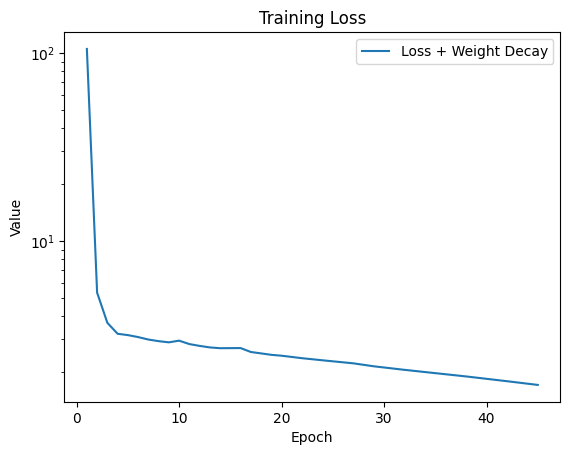

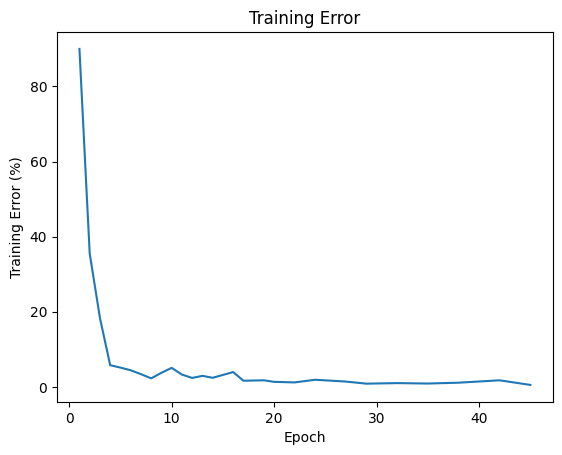

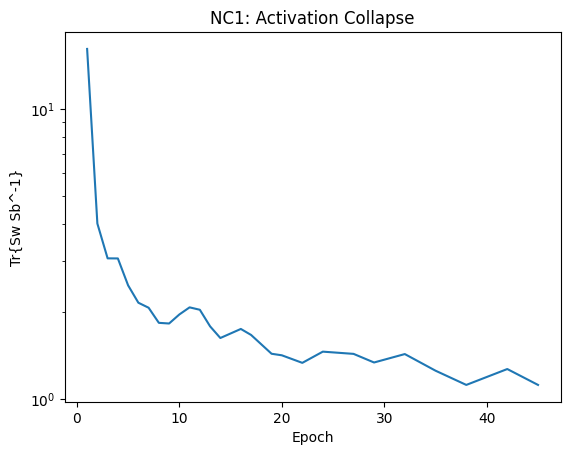

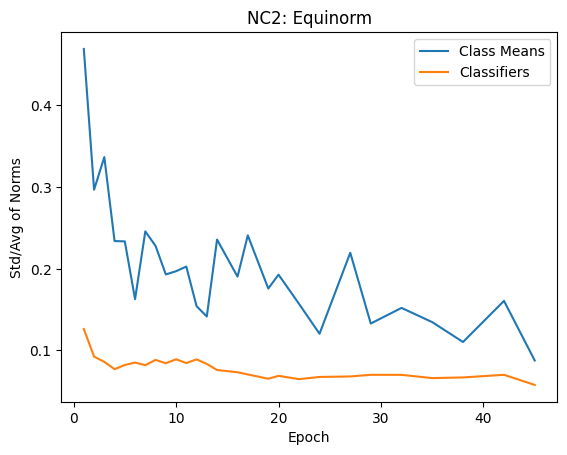

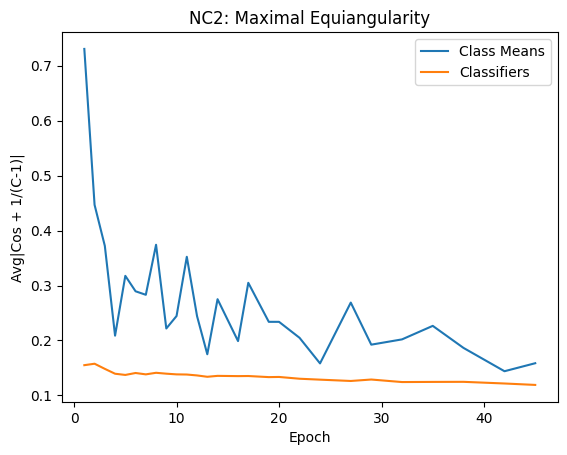

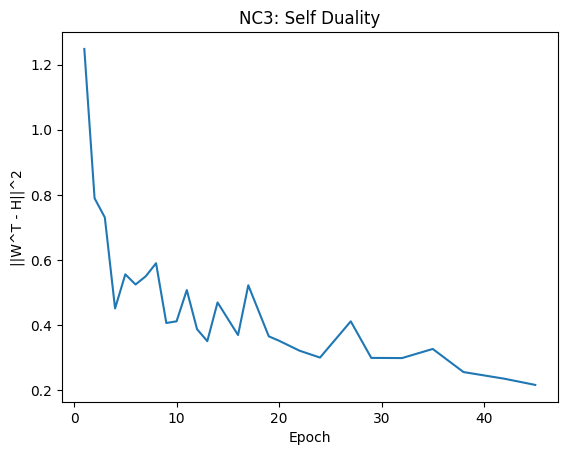

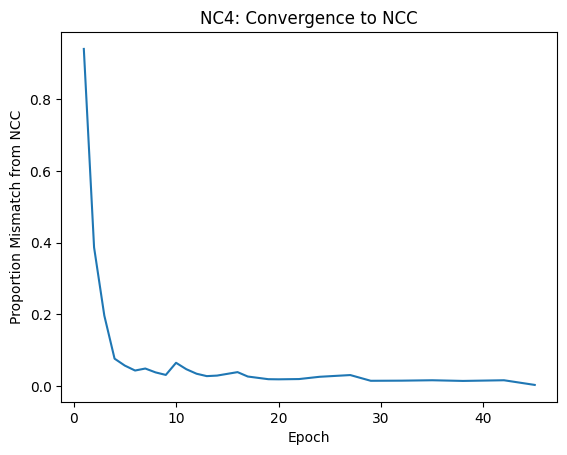

Train		Epoch: 46 [21/469 (4%)] 	Batch Loss: 0.019970 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.40it/s]
Train		Epoch: 47 [21/469 (4%)] 	Batch Loss: 0.016661 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.51it/s]
Train		Epoch: 48 [21/469 (4%)] 	Batch Loss: 0.009907 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:13,  6.13it/s]
Train		Epoch: 49 [21/469 (4%)] 	Batch Loss: 0.018168 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.06it/s]
Train		Epoch: 50 [21/469 (4%)] 	Batch Loss: 0.005693 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.16it/s]
Analysis Cov	Epoch: 50 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.62it/s]


abc1_50.png
abc2_50.png
abc3_50.png
abc4_50.png
abc5_50.png
abc6_50.png
abc7_50.png


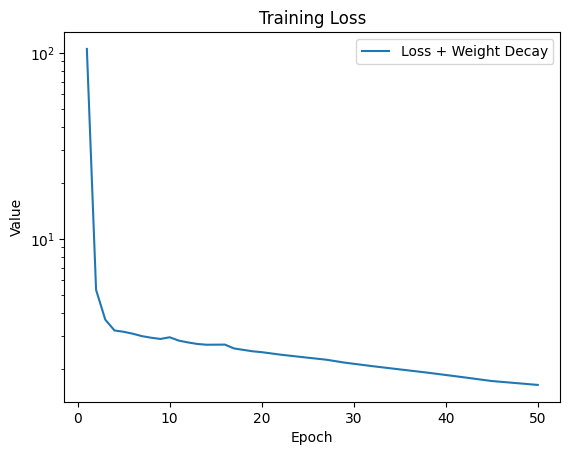

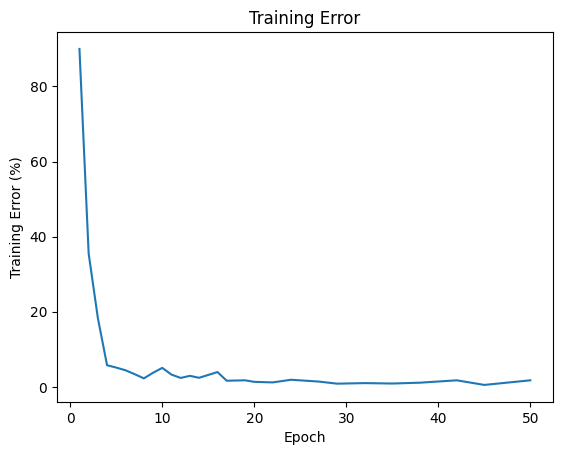

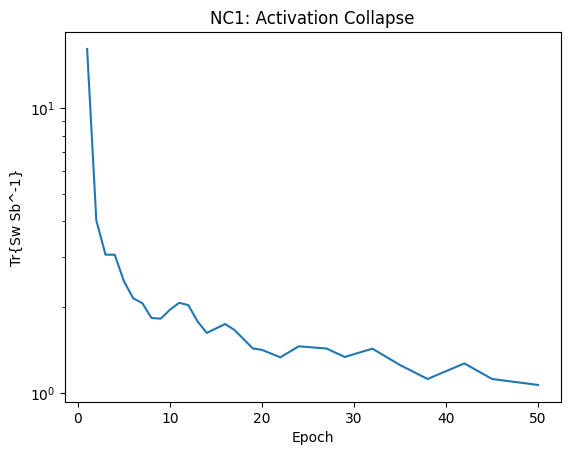

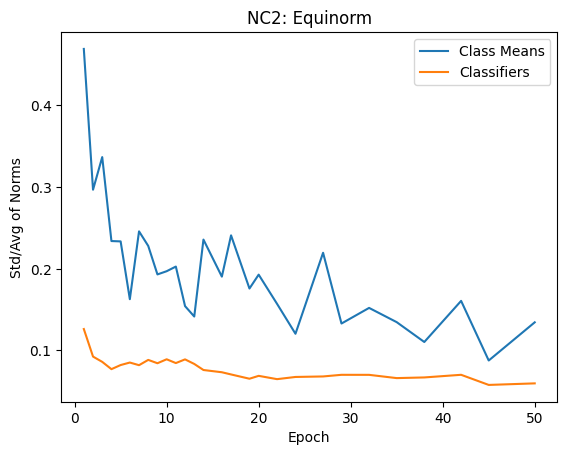

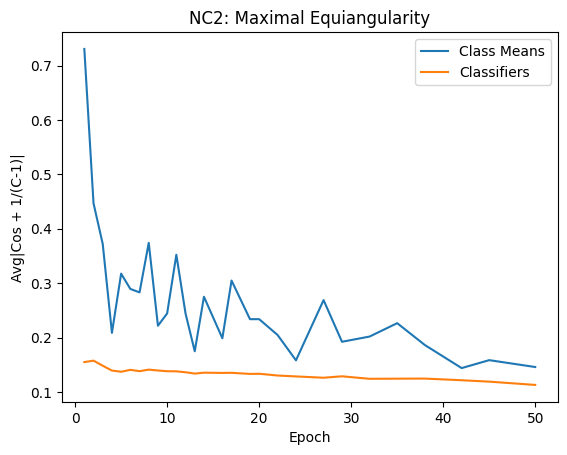

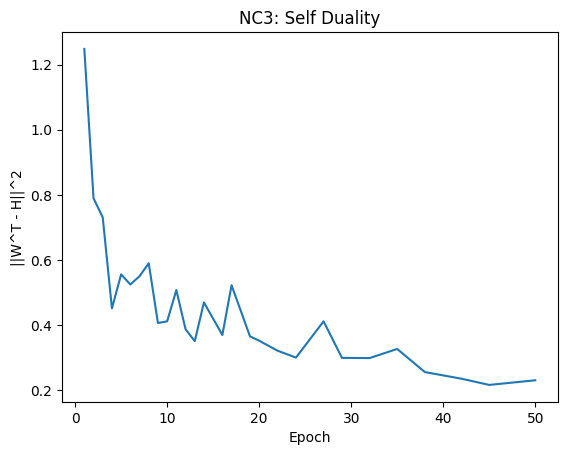

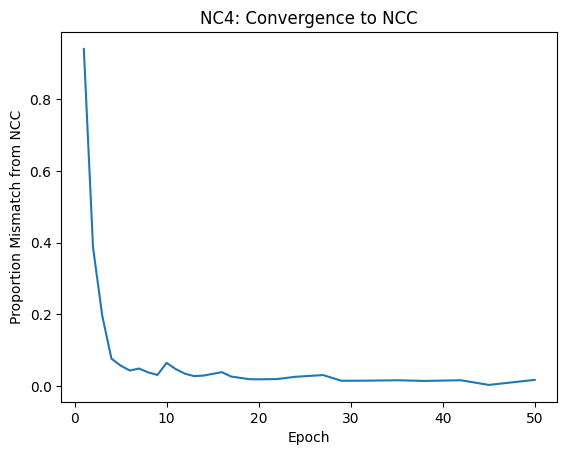

Train		Epoch: 51 [21/469 (4%)] 	Batch Loss: 0.004532 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.24it/s]
Train		Epoch: 52 [21/469 (4%)] 	Batch Loss: 0.027004 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:11,  6.25it/s]
Train		Epoch: 53 [21/469 (4%)] 	Batch Loss: 0.022664 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:10,  6.40it/s]
Train		Epoch: 54 [21/469 (4%)] 	Batch Loss: 0.033297 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.09it/s]
Analysis Cov	Epoch: 54 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.59it/s]


abc1_54.png
abc2_54.png
abc3_54.png
abc4_54.png
abc5_54.png
abc6_54.png
abc7_54.png


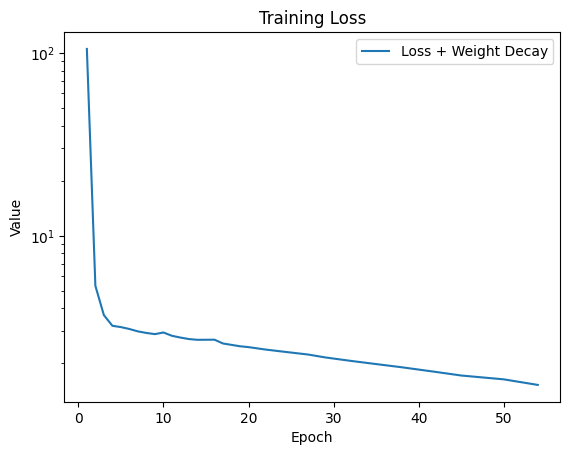

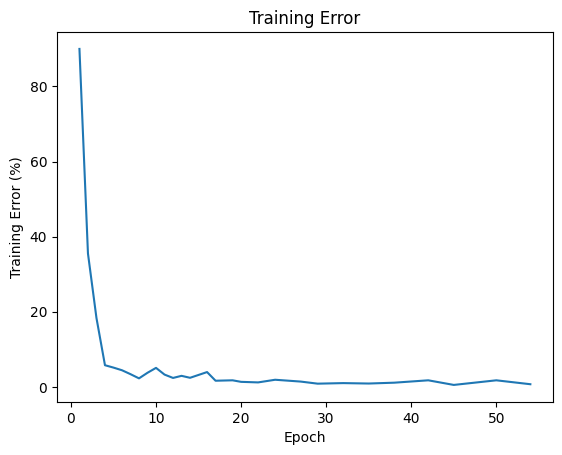

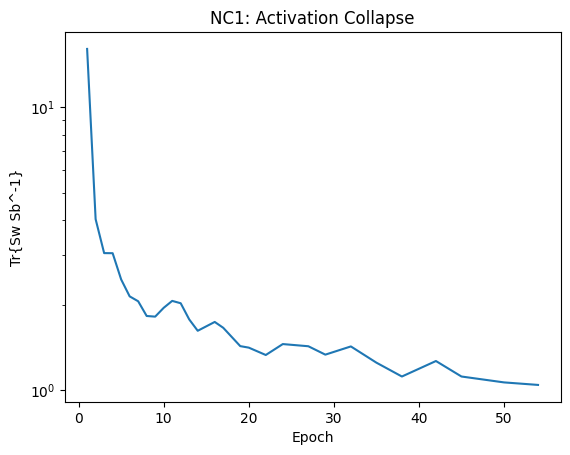

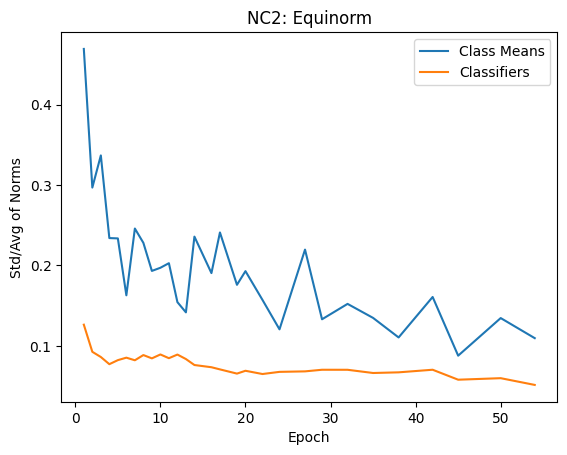

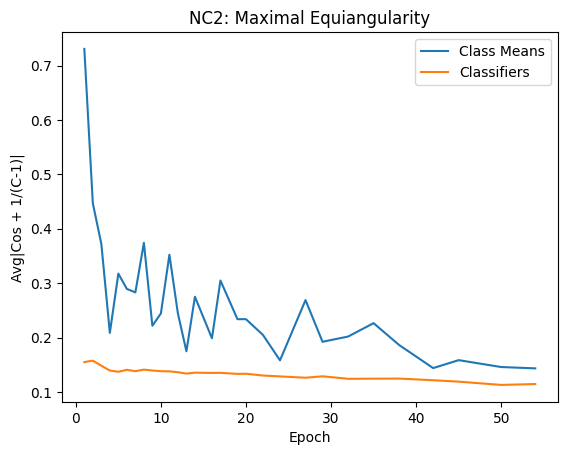

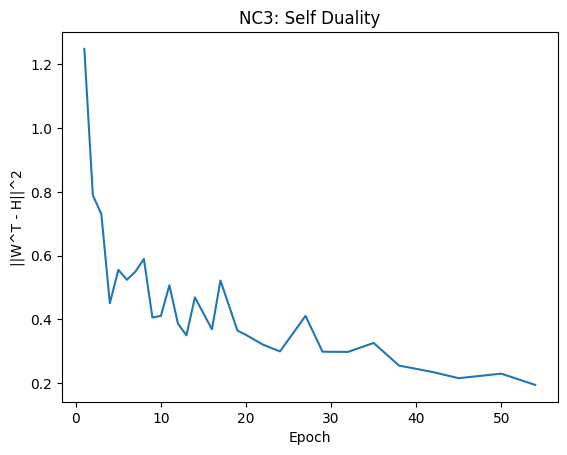

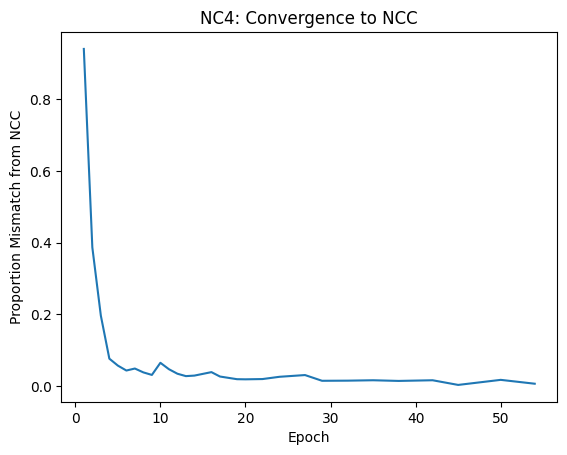

Train		Epoch: 55 [21/469 (4%)] 	Batch Loss: 0.105875 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Train		Epoch: 56 [21/469 (4%)] 	Batch Loss: 0.080476 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:03<01:10,  6.31it/s]
Train		Epoch: 57 [21/469 (4%)] 	Batch Loss: 0.048082 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:12,  6.22it/s]
Train		Epoch: 58 [21/469 (4%)] 	Batch Loss: 0.025340 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Train		Epoch: 59 [21/469 (4%)] 	Batch Loss: 0.065998 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.49it/s]
Analysis Cov	Epoch: 59 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:42, 10.53it/s]


abc1_59.png
abc2_59.png
abc3_59.png
abc4_59.png
abc5_59.png
abc6_59.png
abc7_59.png


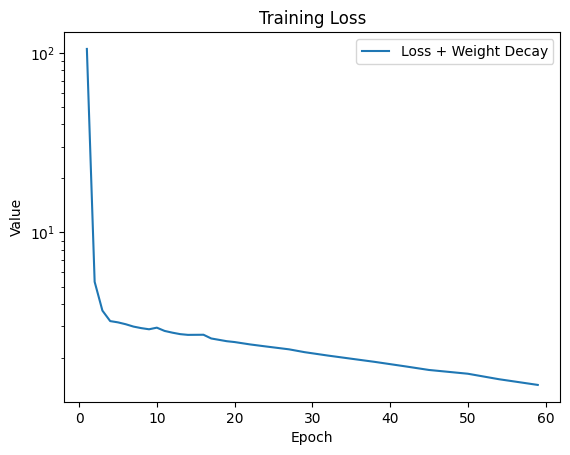

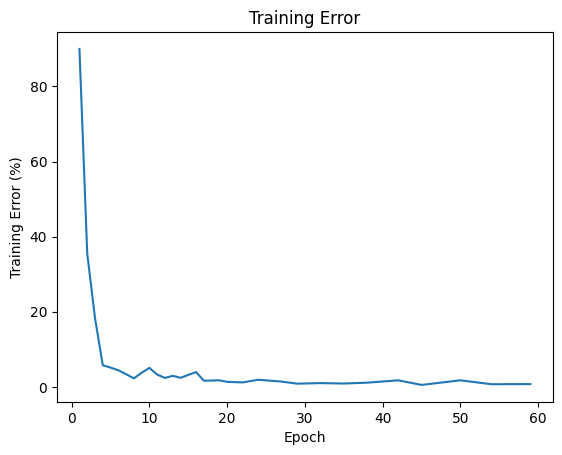

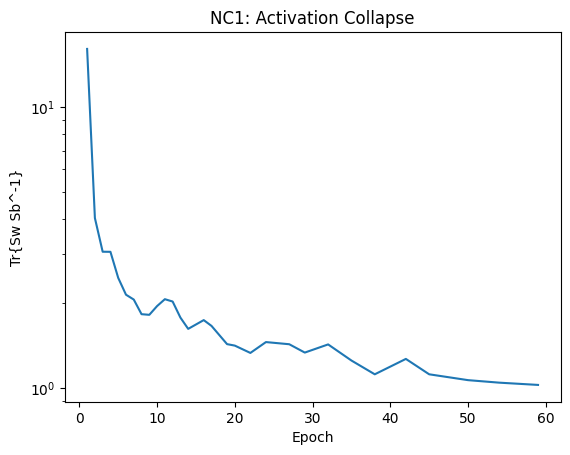

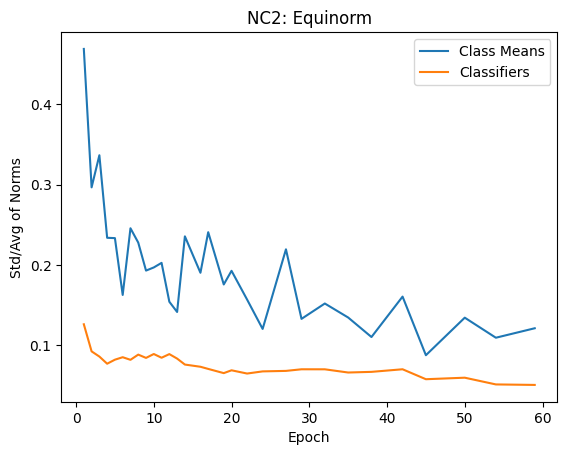

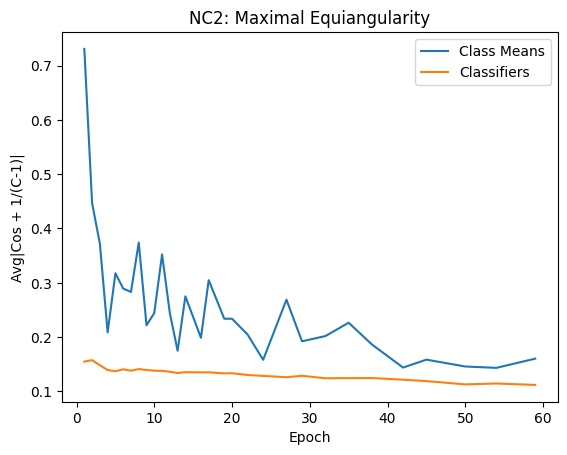

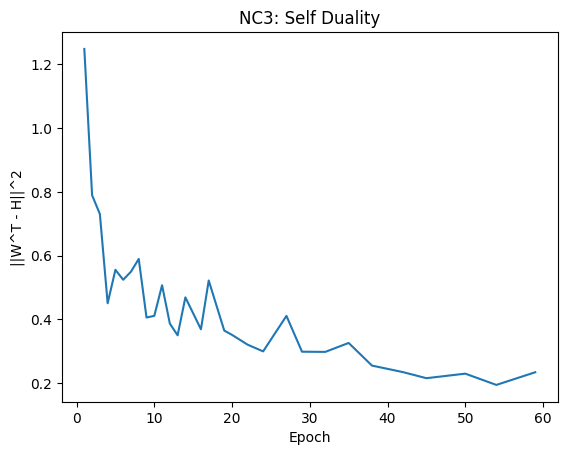

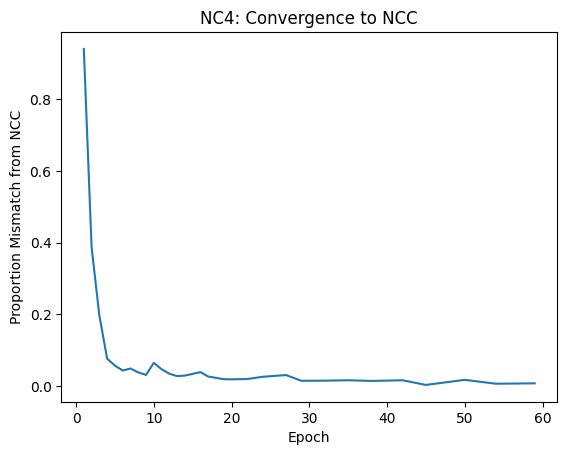

Train		Epoch: 60 [21/469 (4%)] 	Batch Loss: 0.074483 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:11,  6.27it/s]
Train		Epoch: 61 [21/469 (4%)] 	Batch Loss: 0.017056 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:12,  6.17it/s]
Train		Epoch: 62 [21/469 (4%)] 	Batch Loss: 0.033282 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:12,  6.14it/s]
Train		Epoch: 63 [21/469 (4%)] 	Batch Loss: 0.004063 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.40it/s]
Train		Epoch: 64 [21/469 (4%)] 	Batch Loss: 0.004282 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.41it/s]
Train		Epoch: 65 [21/469 (4%)] 	Batch Loss: 0.006055 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.54it/s]
Analysis Cov	Epoch: 65 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:45,  9.94it/s]


abc1_65.png
abc2_65.png
abc3_65.png
abc4_65.png
abc5_65.png
abc6_65.png
abc7_65.png


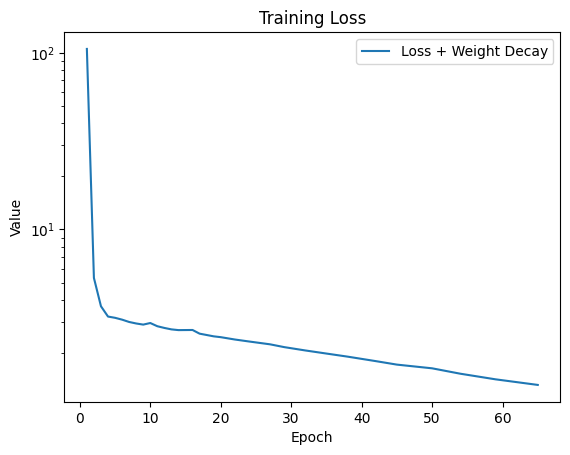

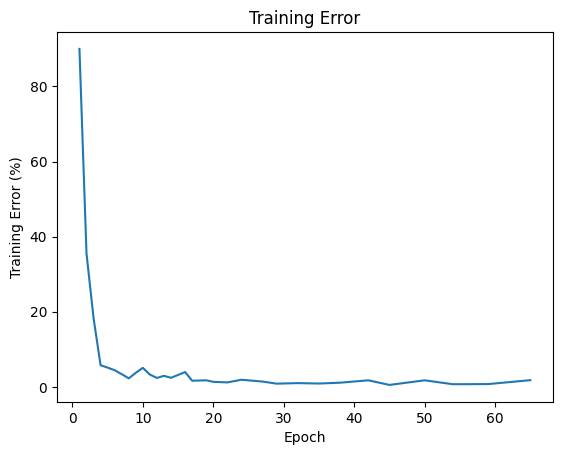

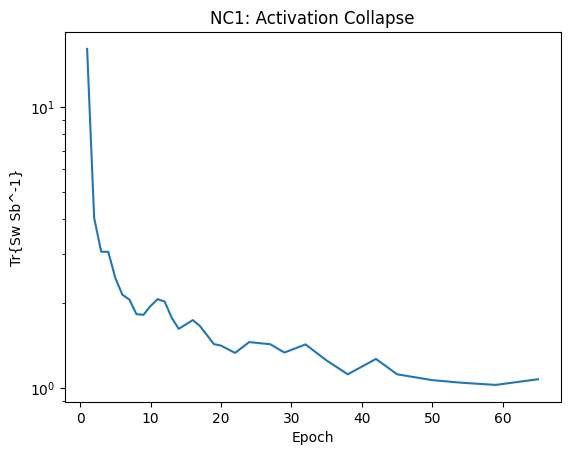

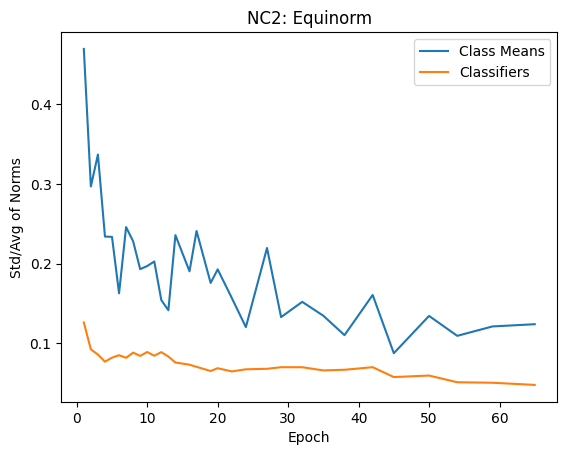

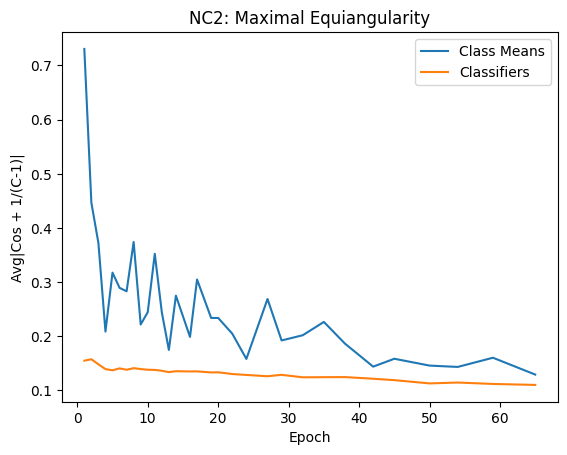

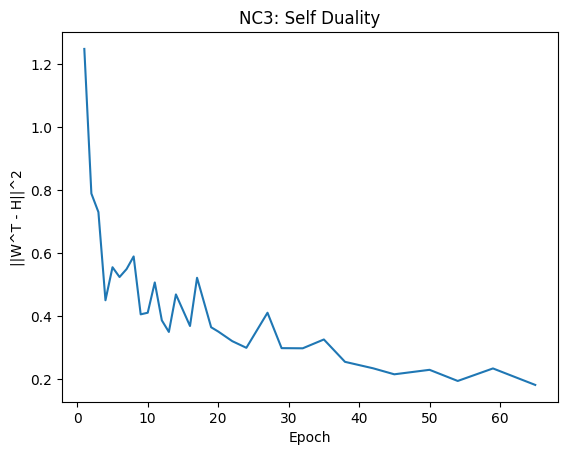

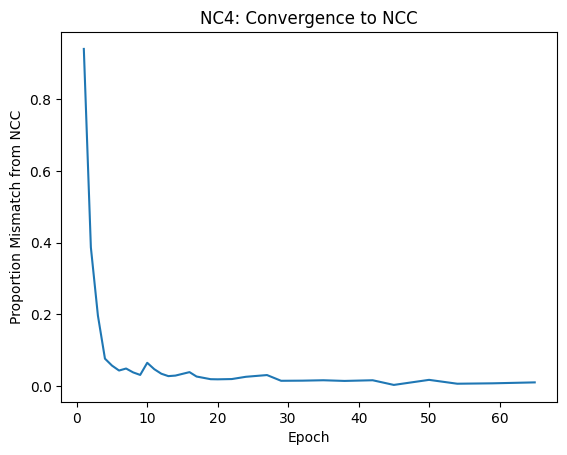

Train		Epoch: 66 [21/469 (4%)] 	Batch Loss: 0.032278 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:15,  5.97it/s]
Train		Epoch: 67 [21/469 (4%)] 	Batch Loss: 0.010225 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.40it/s]
Train		Epoch: 68 [21/469 (4%)] 	Batch Loss: 0.012149 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:07,  6.62it/s]
Train		Epoch: 69 [21/469 (4%)] 	Batch Loss: 0.009893 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.52it/s]
Train		Epoch: 70 [21/469 (4%)] 	Batch Loss: 0.010048 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.16it/s]
Train		Epoch: 71 [21/469 (4%)] 	Batch Loss: 0.013446 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.21it/s]
Analysis Cov	Epoch: 71 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:46,  9.55it/s]


abc1_71.png
abc2_71.png
abc3_71.png
abc4_71.png
abc5_71.png
abc6_71.png
abc7_71.png


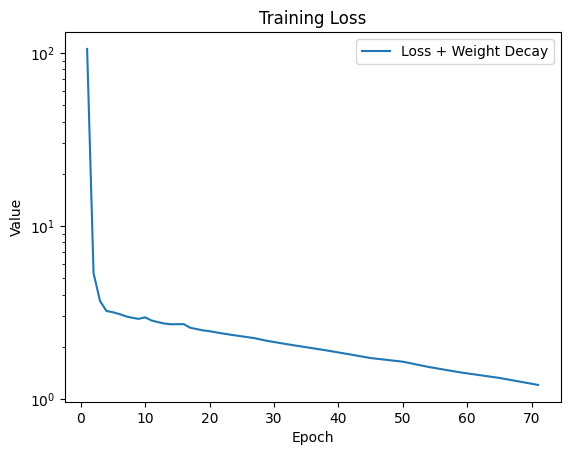

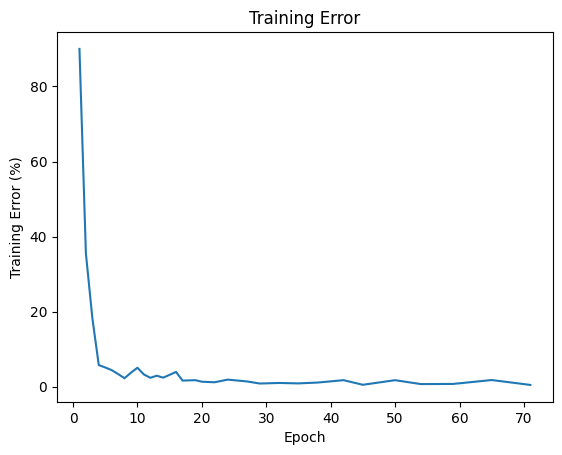

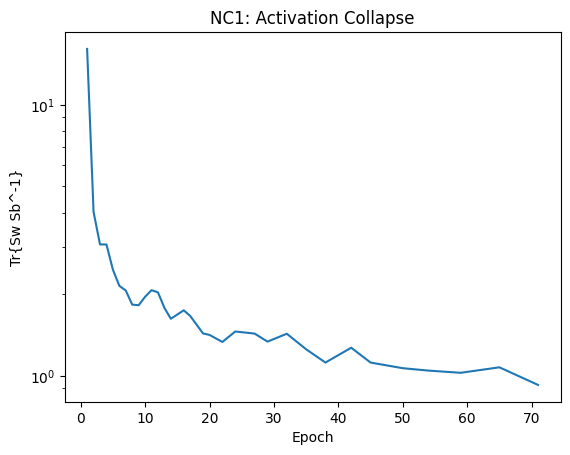

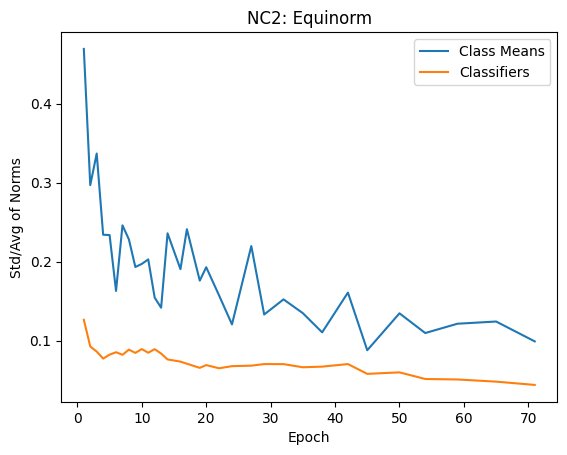

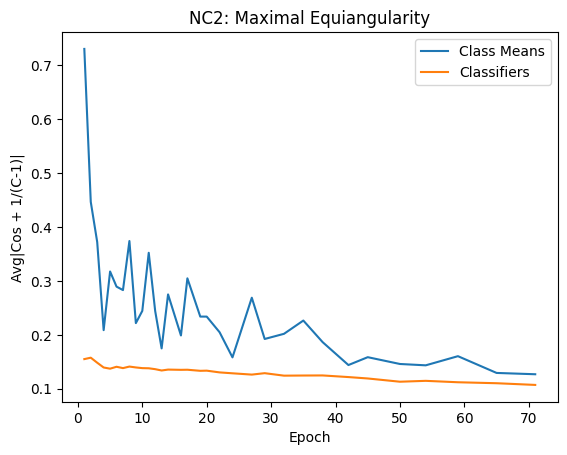

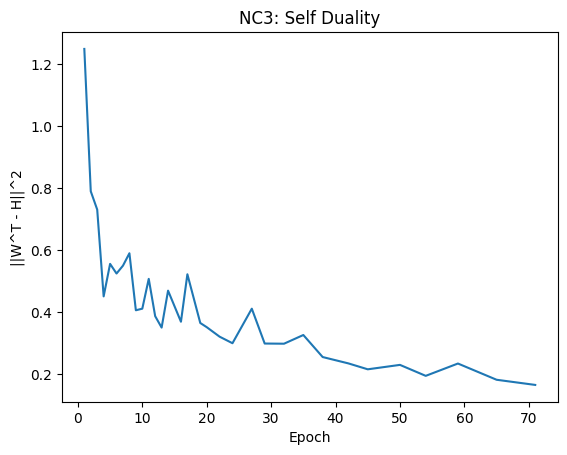

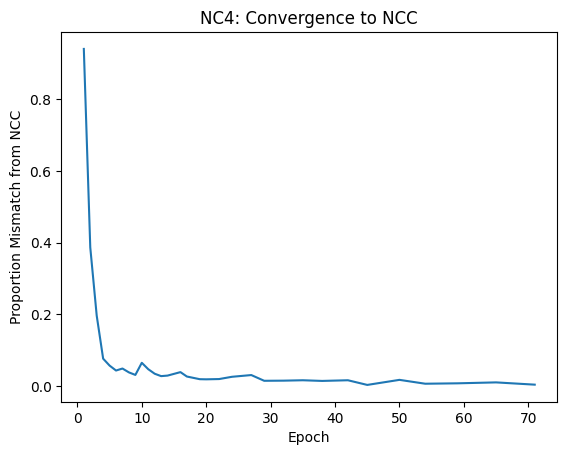

Train		Epoch: 72 [21/469 (4%)] 	Batch Loss: 0.020797 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Train		Epoch: 73 [21/469 (4%)] 	Batch Loss: 0.002620 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.33it/s]
Train		Epoch: 74 [21/469 (4%)] 	Batch Loss: 0.001652 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.28it/s]
Train		Epoch: 75 [21/469 (4%)] 	Batch Loss: 0.001765 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.18it/s]
Train		Epoch: 76 [21/469 (4%)] 	Batch Loss: 0.002950 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:13,  6.05it/s]
Train		Epoch: 77 [21/469 (4%)] 	Batch Loss: 0.008645 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.10it/s]
Analysis Cov	Epoch: 77 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:41, 10.76it/s]


abc1_77.png
abc2_77.png
abc3_77.png
abc4_77.png
abc5_77.png
abc6_77.png
abc7_77.png


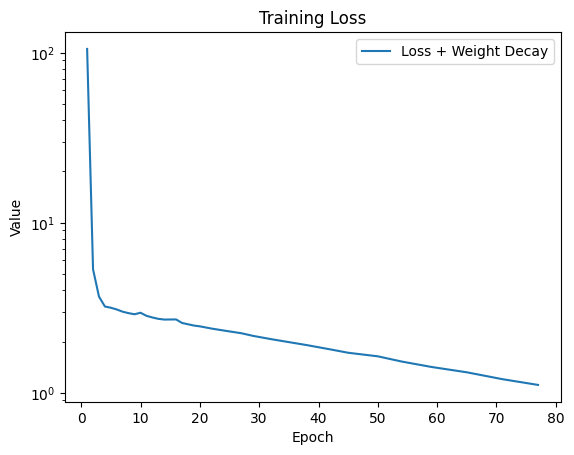

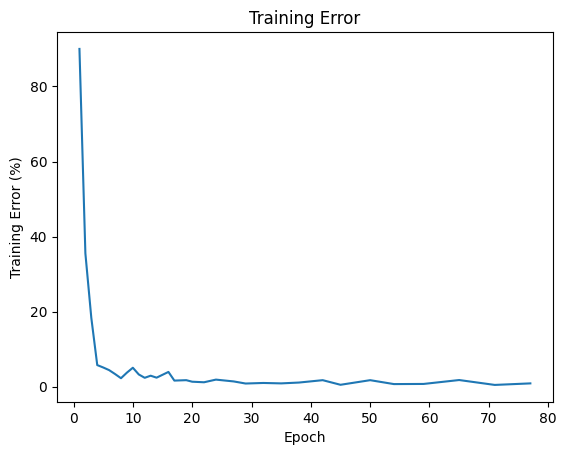

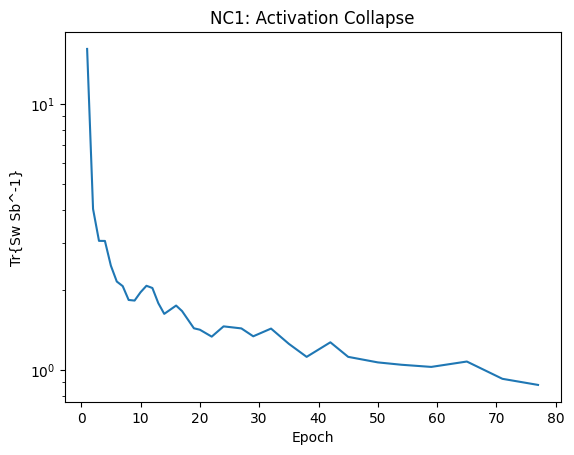

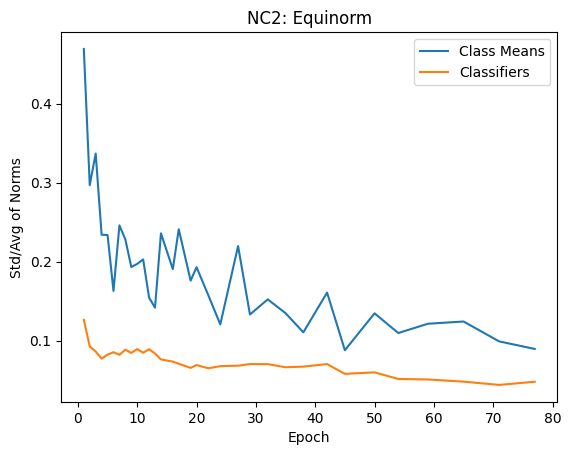

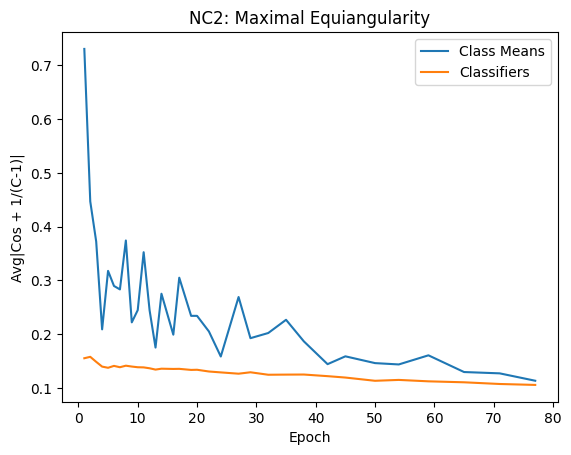

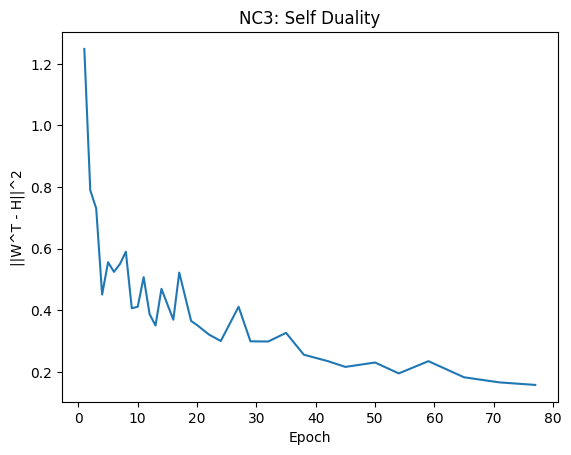

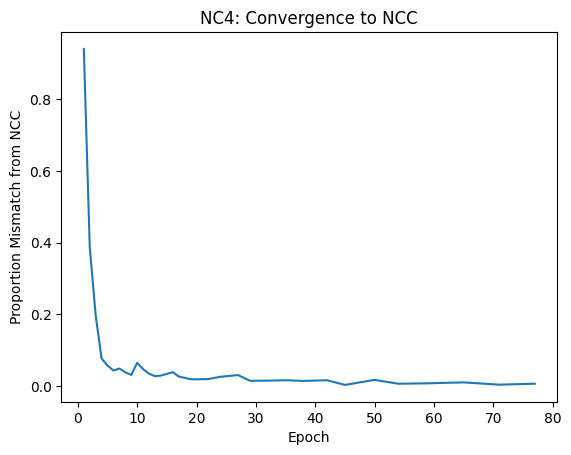

Train		Epoch: 78 [21/469 (4%)] 	Batch Loss: 0.020797 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:10,  6.39it/s]
Train		Epoch: 79 [21/469 (4%)] 	Batch Loss: 0.013270 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.23it/s]
Train		Epoch: 80 [21/469 (4%)] 	Batch Loss: 0.040180 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:13,  6.12it/s]
Train		Epoch: 81 [21/469 (4%)] 	Batch Loss: 0.019921 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.17it/s]
Train		Epoch: 82 [21/469 (4%)] 	Batch Loss: 0.028715 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:11,  6.27it/s]
Train		Epoch: 83 [21/469 (4%)] 	Batch Loss: 0.003253 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.53it/s]
Train		Epoch: 84 [21/469 (4%)] 	Batch Loss: 0.067306 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Train		Epoch: 85 [21/469 (4%)] 	Batch Loss: 0.041415 	Batch Accuracy: 0.992188:   4%|▍         | 

abc1_85.png
abc2_85.png
abc3_85.png
abc4_85.png
abc5_85.png
abc6_85.png
abc7_85.png


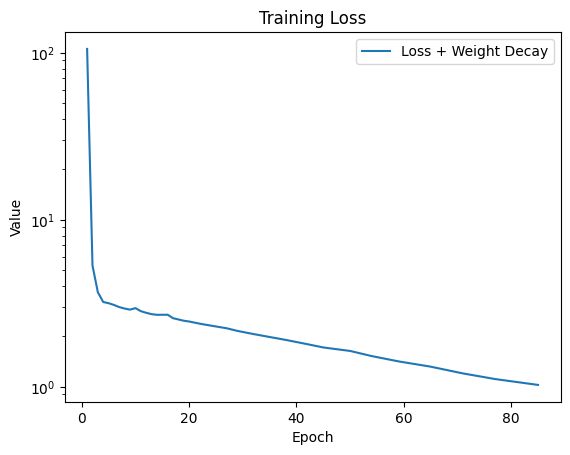

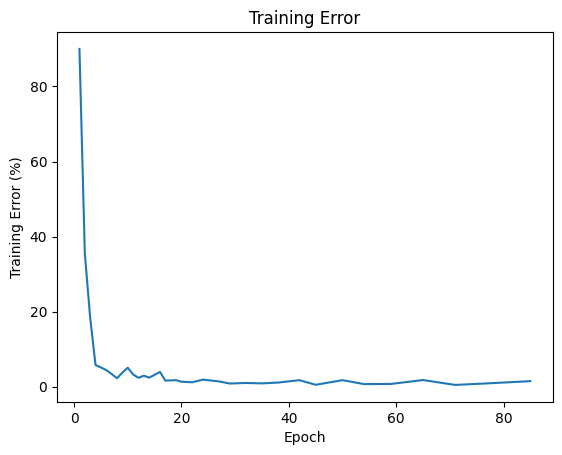

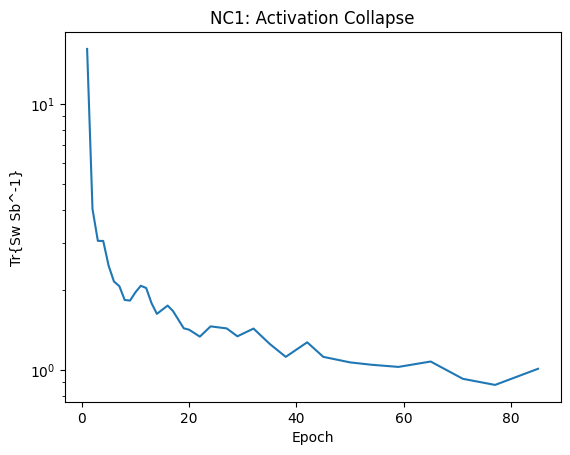

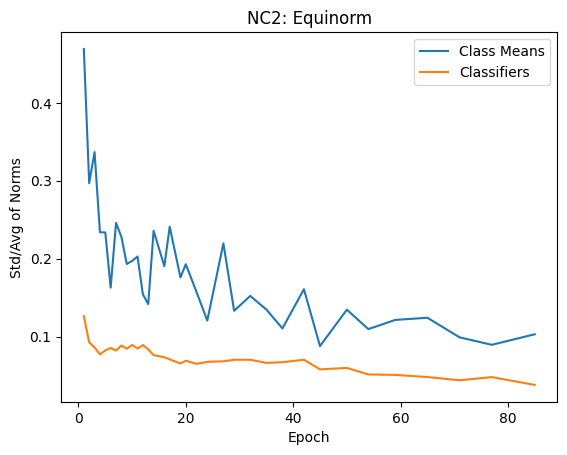

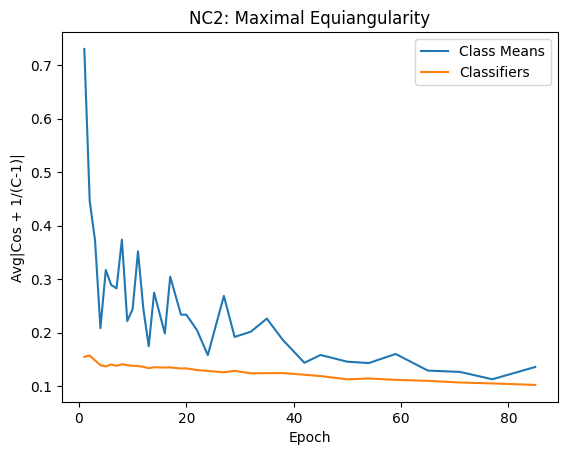

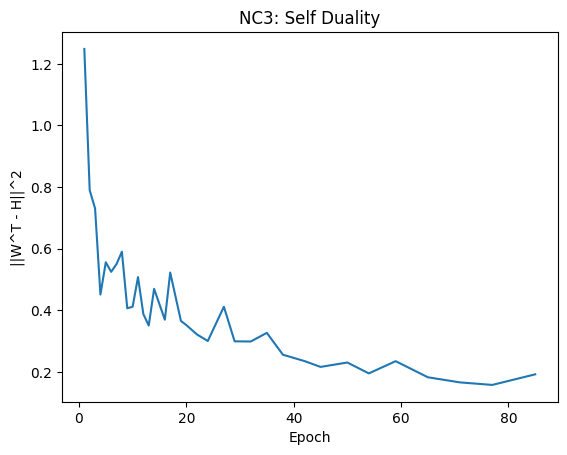

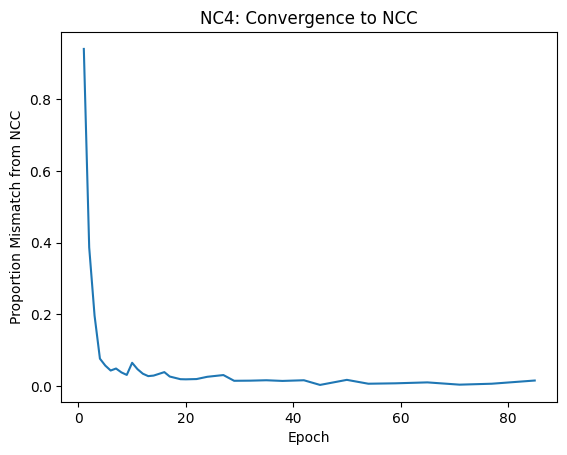

Train		Epoch: 86 [21/469 (4%)] 	Batch Loss: 0.023998 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Train		Epoch: 87 [21/469 (4%)] 	Batch Loss: 0.019012 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.53it/s]
Train		Epoch: 88 [21/469 (4%)] 	Batch Loss: 0.002049 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:07,  6.67it/s]
Train		Epoch: 89 [21/469 (4%)] 	Batch Loss: 0.002209 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.25it/s]
Train		Epoch: 90 [21/469 (4%)] 	Batch Loss: 0.032758 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:11,  6.26it/s]
Train		Epoch: 91 [21/469 (4%)] 	Batch Loss: 0.008397 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:14,  6.01it/s]
Train		Epoch: 92 [21/469 (4%)] 	Batch Loss: 0.004197 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.19it/s]
Analysis Cov	Epoch: 92 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:41, 10.80it/s]


abc1_92.png
abc2_92.png
abc3_92.png
abc4_92.png
abc5_92.png
abc6_92.png
abc7_92.png


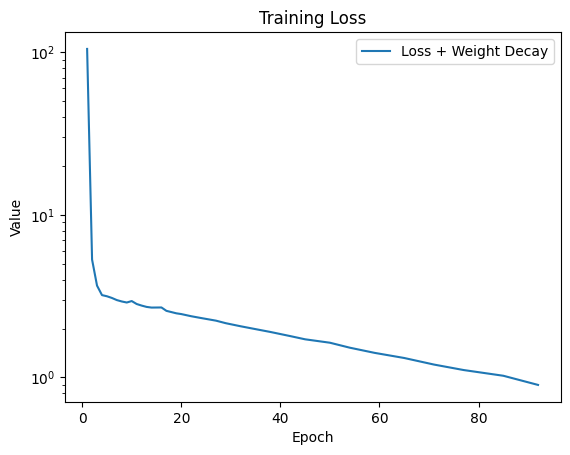

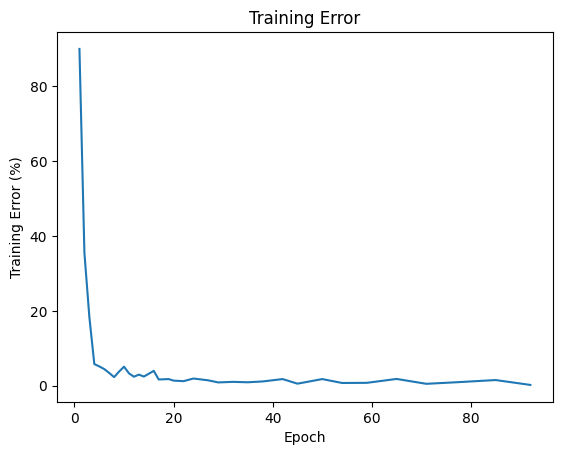

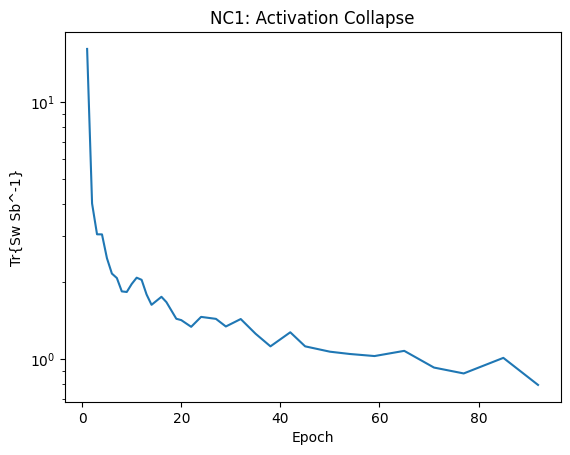

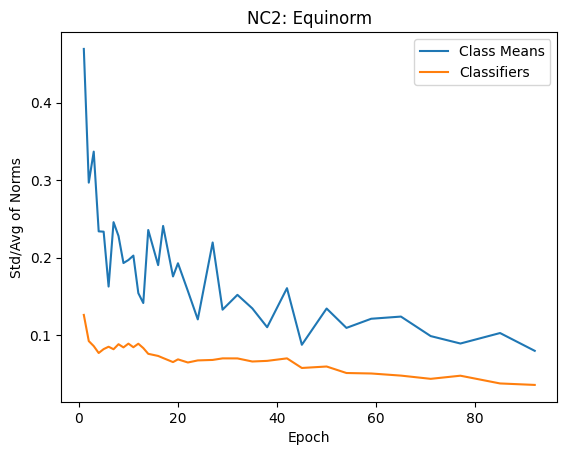

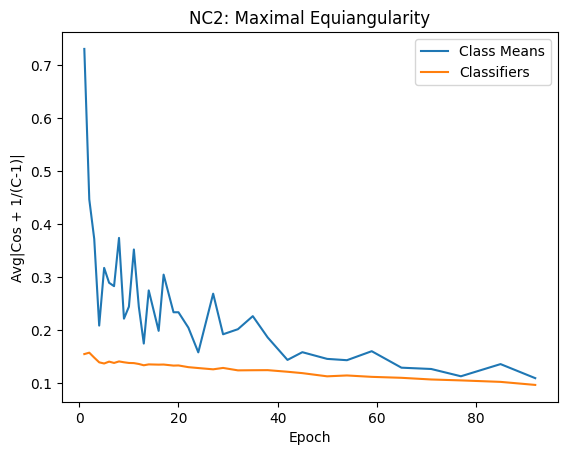

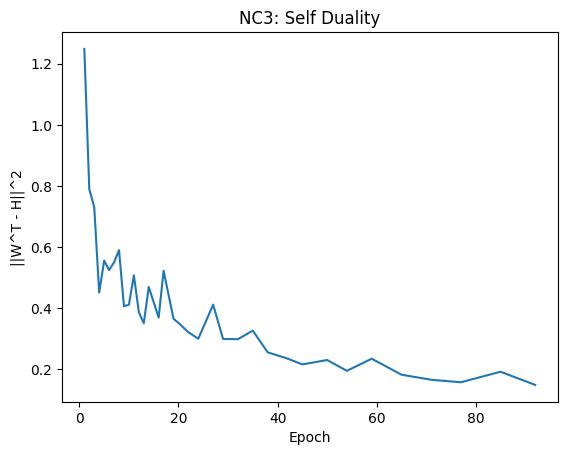

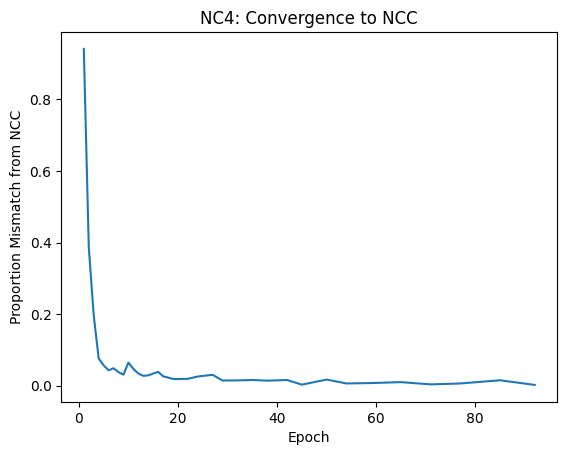

Train		Epoch: 93 [21/469 (4%)] 	Batch Loss: 0.001406 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.39it/s]
Train		Epoch: 94 [21/469 (4%)] 	Batch Loss: 0.001508 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.56it/s]
Train		Epoch: 95 [21/469 (4%)] 	Batch Loss: 0.025698 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Train		Epoch: 96 [21/469 (4%)] 	Batch Loss: 0.004986 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.20it/s]
Train		Epoch: 97 [21/469 (4%)] 	Batch Loss: 0.001402 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:07,  6.59it/s]
Train		Epoch: 98 [21/469 (4%)] 	Batch Loss: 0.002867 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.54it/s]
Train		Epoch: 99 [21/469 (4%)] 	Batch Loss: 0.010178 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.49it/s]
Train		Epoch: 100 [21/469 (4%)] 	Batch Loss: 0.007695 	Batch Accuracy: 0.992188:   4%|▍         |

abc1_101.png
abc2_101.png
abc3_101.png
abc4_101.png
abc5_101.png
abc6_101.png
abc7_101.png


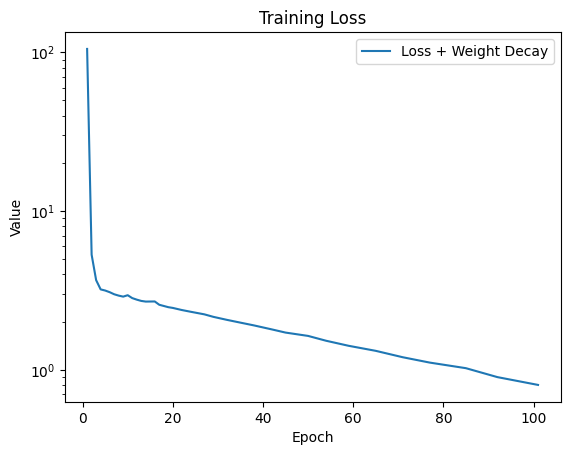

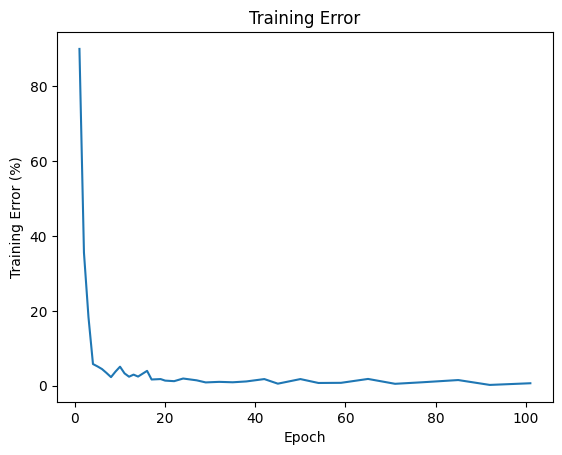

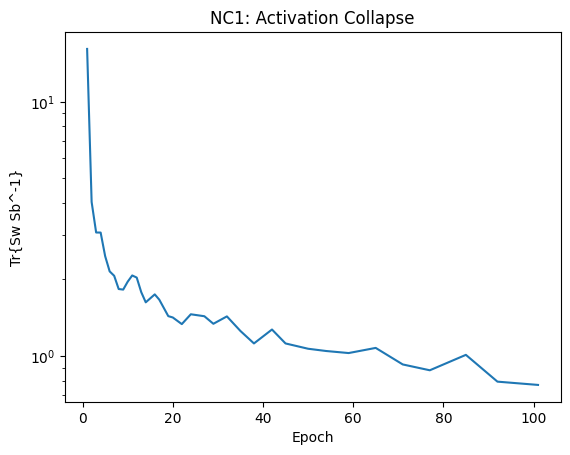

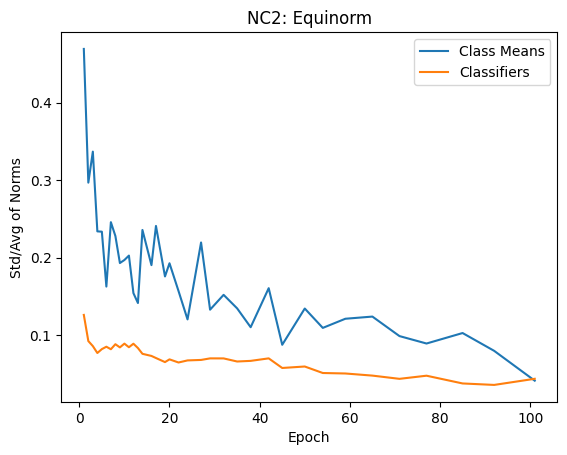

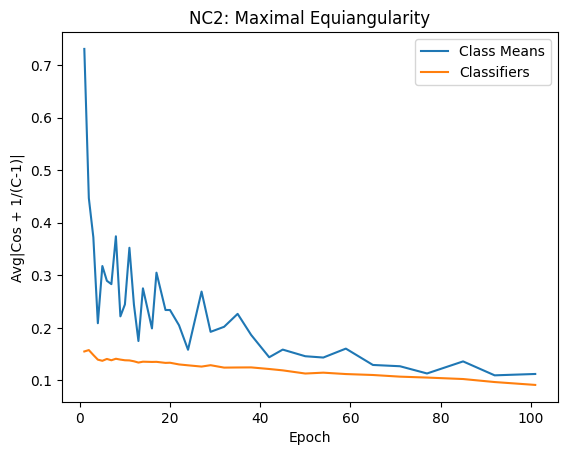

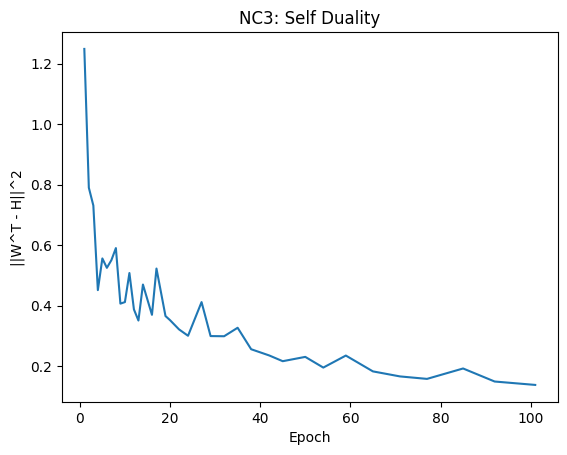

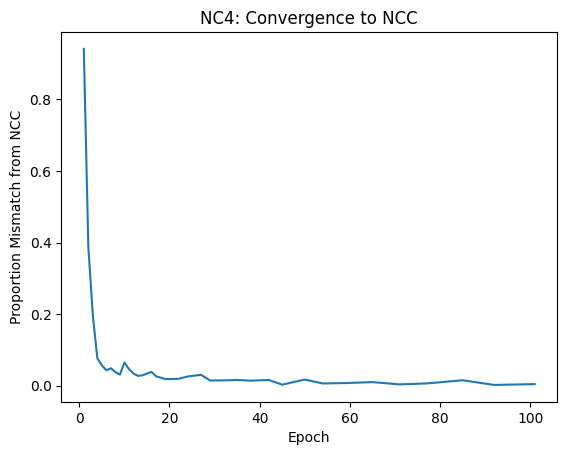

Train		Epoch: 102 [21/469 (4%)] 	Batch Loss: 0.034319 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:11,  6.30it/s]
Train		Epoch: 103 [21/469 (4%)] 	Batch Loss: 0.070184 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:13,  6.09it/s]
Train		Epoch: 104 [21/469 (4%)] 	Batch Loss: 0.013838 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.17it/s]
Train		Epoch: 105 [21/469 (4%)] 	Batch Loss: 0.011625 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:13,  6.09it/s]
Train		Epoch: 106 [21/469 (4%)] 	Batch Loss: 0.025072 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:09,  6.48it/s]
Train		Epoch: 107 [21/469 (4%)] 	Batch Loss: 0.026124 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:09,  6.45it/s]
Train		Epoch: 108 [21/469 (4%)] 	Batch Loss: 0.011872 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.42it/s]
Train		Epoch: 109 [21/469 (4%)] 	Batch Loss: 0.043097 	Batch Accuracy: 0.984375:   4%|▍   

abc1_110.png
abc2_110.png
abc3_110.png
abc4_110.png
abc5_110.png
abc6_110.png
abc7_110.png


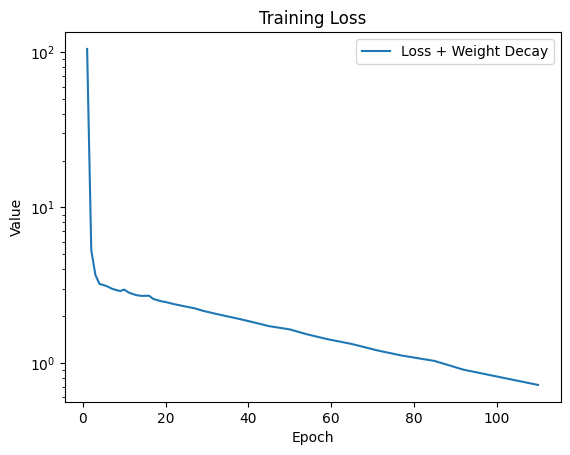

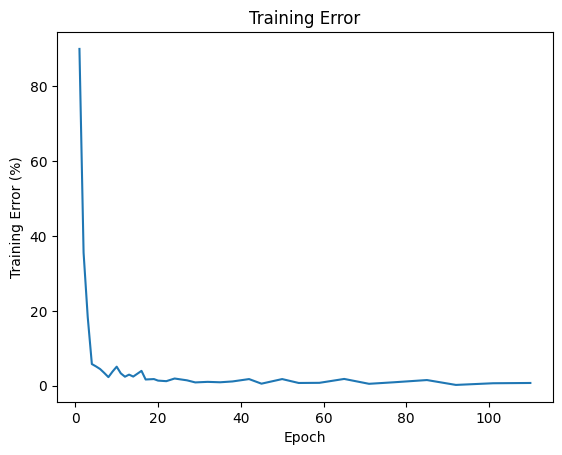

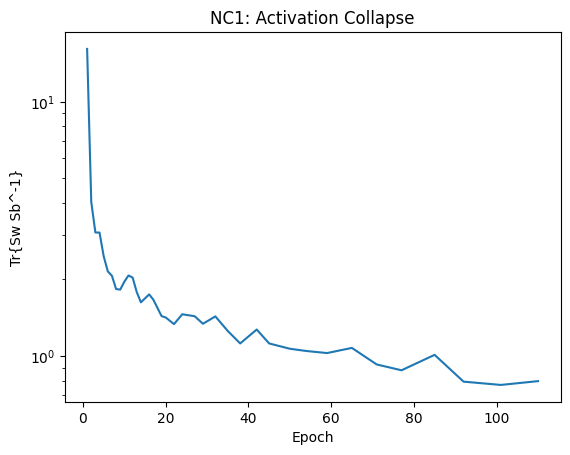

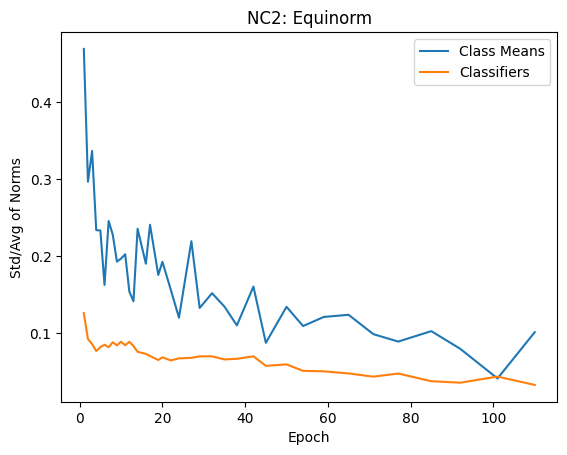

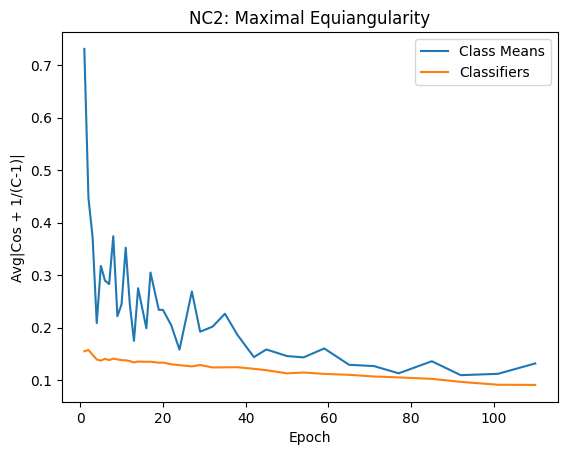

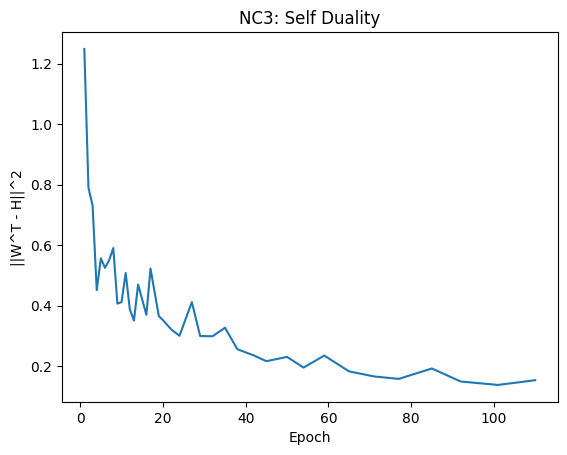

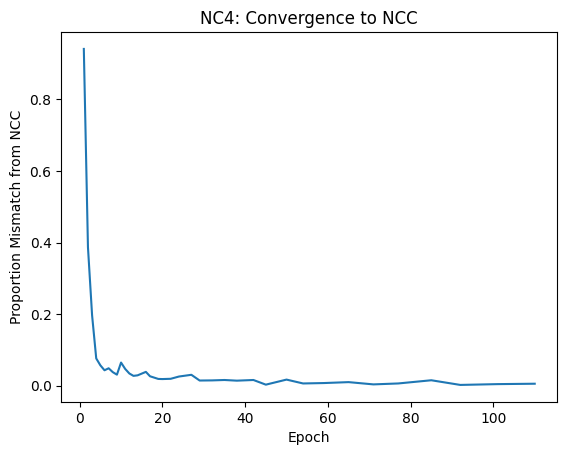

Train		Epoch: 111 [21/469 (4%)] 	Batch Loss: 0.024502 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:11,  6.28it/s]
Train		Epoch: 112 [21/469 (4%)] 	Batch Loss: 0.014973 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:15,  5.96it/s]
Train		Epoch: 113 [21/469 (4%)] 	Batch Loss: 0.005574 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.29it/s]
Train		Epoch: 114 [21/469 (4%)] 	Batch Loss: 0.040465 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:03<01:12,  6.20it/s]
Train		Epoch: 115 [21/469 (4%)] 	Batch Loss: 0.002045 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.59it/s]
Train		Epoch: 116 [21/469 (4%)] 	Batch Loss: 0.031948 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.52it/s]
Train		Epoch: 117 [21/469 (4%)] 	Batch Loss: 0.047116 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:03<01:08,  6.51it/s]
Train		Epoch: 118 [21/469 (4%)] 	Batch Loss: 0.028629 	Batch Accuracy: 0.992188:   4%|▍   

abc1_121.png
abc2_121.png
abc3_121.png
abc4_121.png
abc5_121.png
abc6_121.png
abc7_121.png


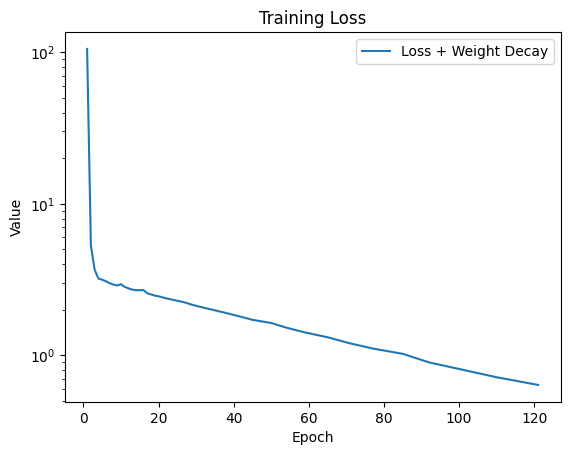

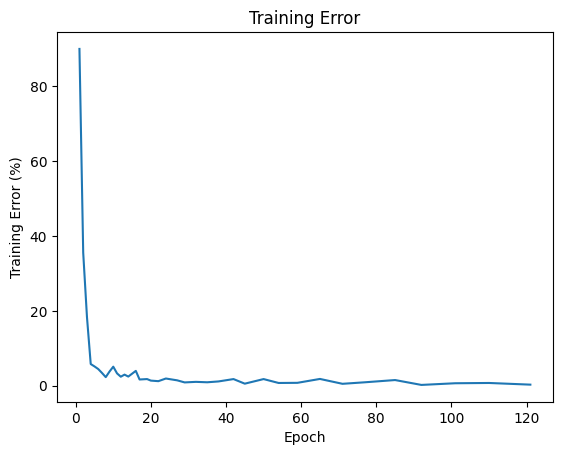

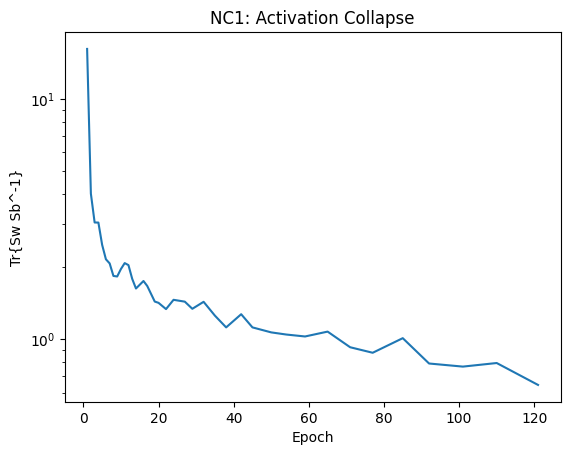

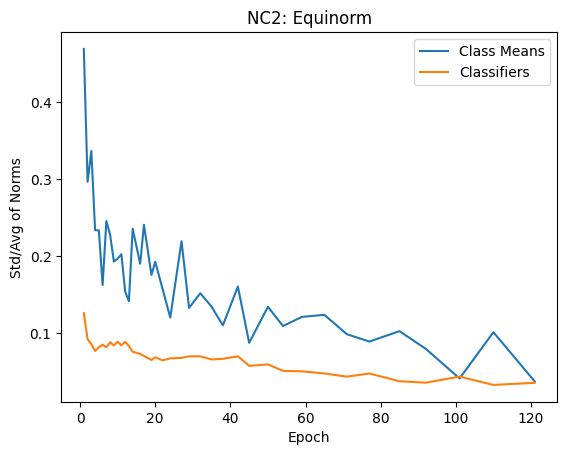

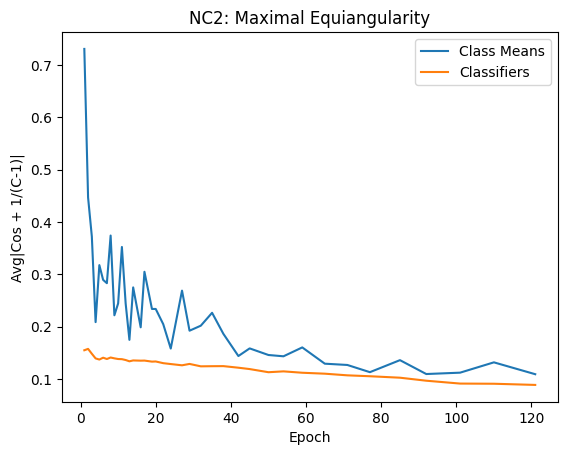

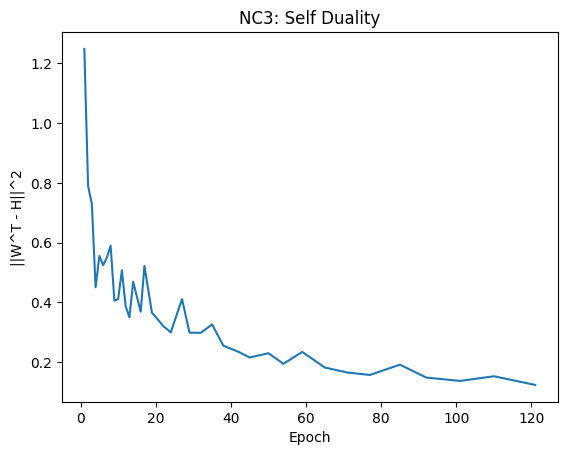

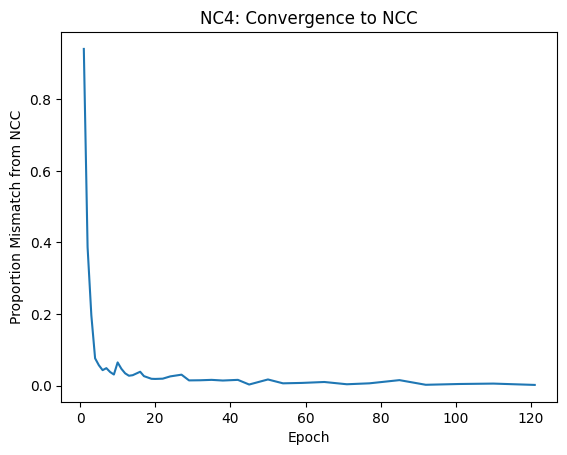

Train		Epoch: 122 [21/469 (4%)] 	Batch Loss: 0.031078 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:12,  6.16it/s]
Train		Epoch: 123 [21/469 (4%)] 	Batch Loss: 0.000801 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:14,  6.00it/s]
Train		Epoch: 124 [21/469 (4%)] 	Batch Loss: 0.002753 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.44it/s]
Train		Epoch: 125 [21/469 (4%)] 	Batch Loss: 0.008055 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:08,  6.51it/s]
Train		Epoch: 126 [21/469 (4%)] 	Batch Loss: 0.000732 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:08,  6.55it/s]
Train		Epoch: 127 [21/469 (4%)] 	Batch Loss: 0.002261 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:13,  6.12it/s]
Train		Epoch: 128 [21/469 (4%)] 	Batch Loss: 0.006495 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:15,  5.96it/s]
Train		Epoch: 129 [21/469 (4%)] 	Batch Loss: 0.001006 	Batch Accuracy: 1.000000:   4%|▍   

abc1_132.png
abc2_132.png
abc3_132.png
abc4_132.png
abc5_132.png
abc6_132.png
abc7_132.png


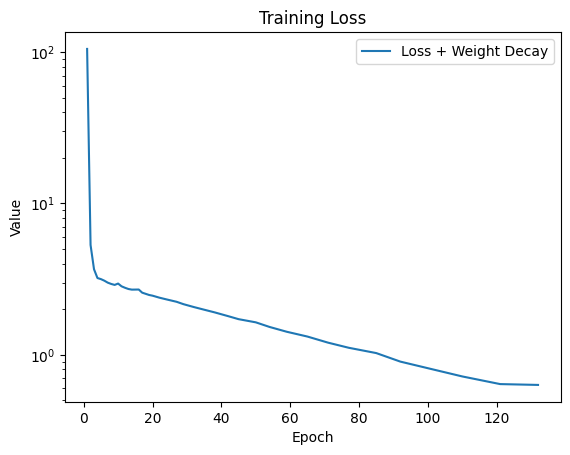

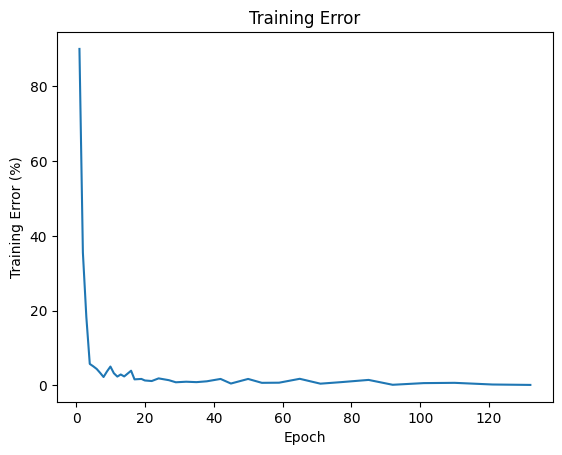

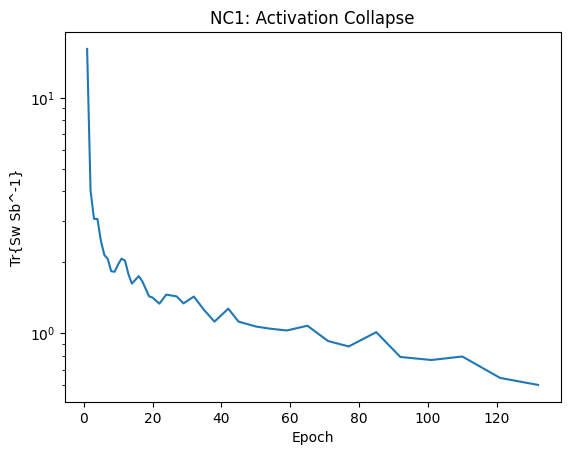

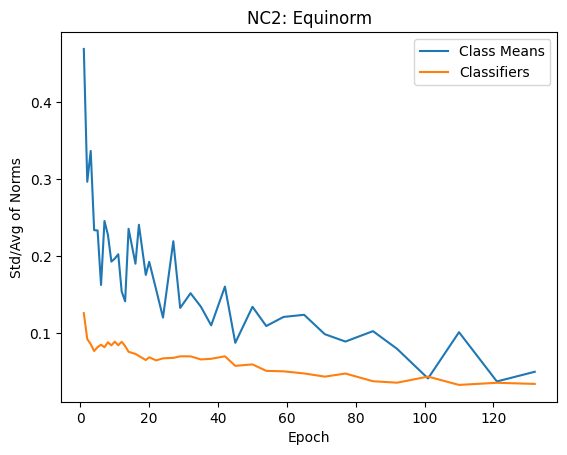

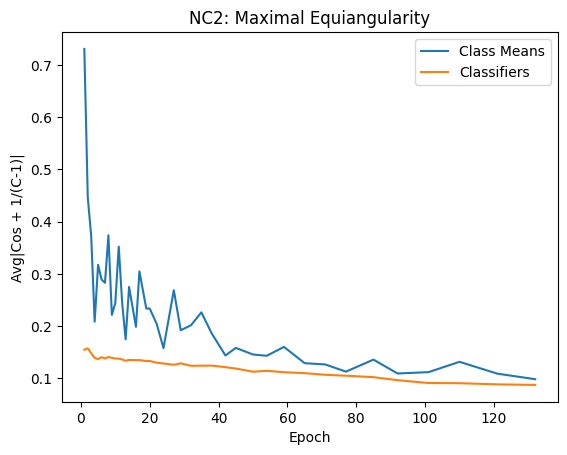

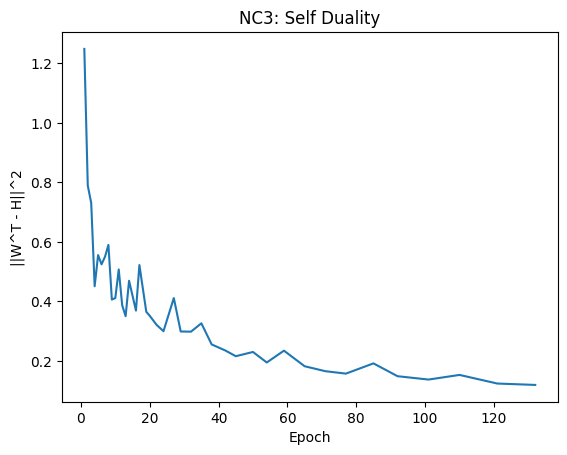

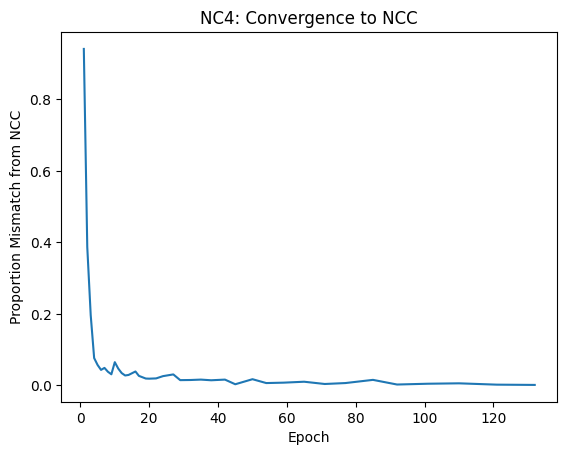

Train		Epoch: 133 [21/469 (4%)] 	Batch Loss: 0.056307 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:10,  6.36it/s]
Train		Epoch: 134 [21/469 (4%)] 	Batch Loss: 0.002139 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.32it/s]
Train		Epoch: 135 [21/469 (4%)] 	Batch Loss: 0.003718 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.46it/s]
Train		Epoch: 136 [21/469 (4%)] 	Batch Loss: 0.006250 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.49it/s]
Train		Epoch: 137 [21/469 (4%)] 	Batch Loss: 0.002868 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.23it/s]
Train		Epoch: 138 [21/469 (4%)] 	Batch Loss: 0.003259 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.30it/s]
Train		Epoch: 139 [21/469 (4%)] 	Batch Loss: 0.001238 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.33it/s]
Train		Epoch: 140 [21/469 (4%)] 	Batch Loss: 0.006576 	Batch Accuracy: 1.000000:   4%|▍   

abc1_144.png
abc2_144.png
abc3_144.png
abc4_144.png
abc5_144.png
abc6_144.png
abc7_144.png


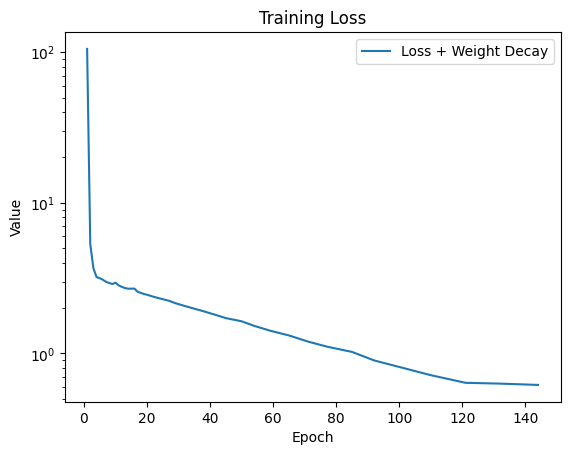

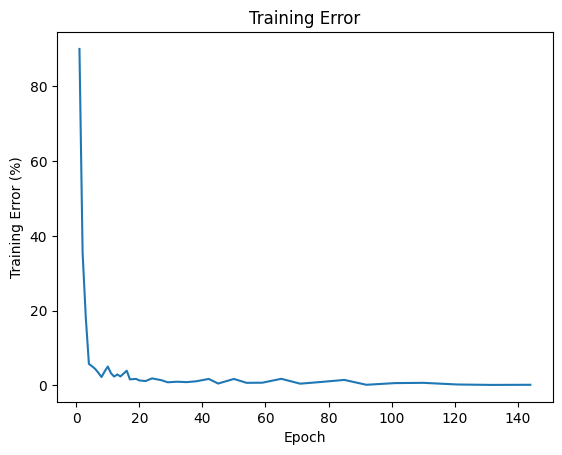

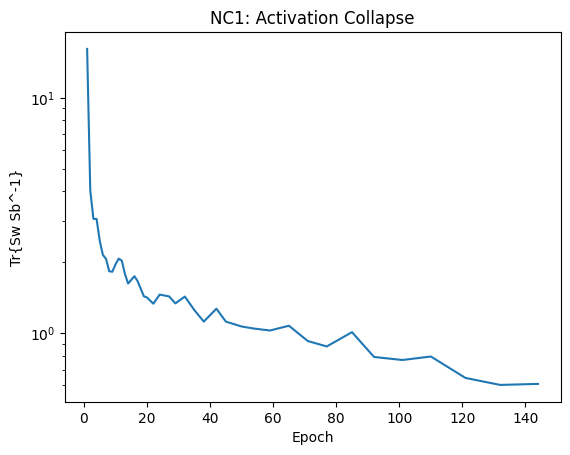

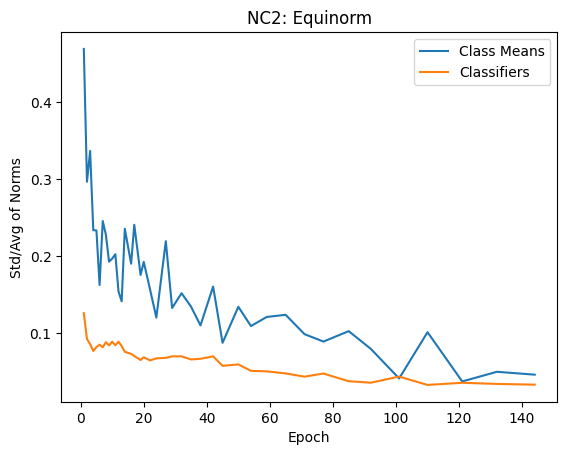

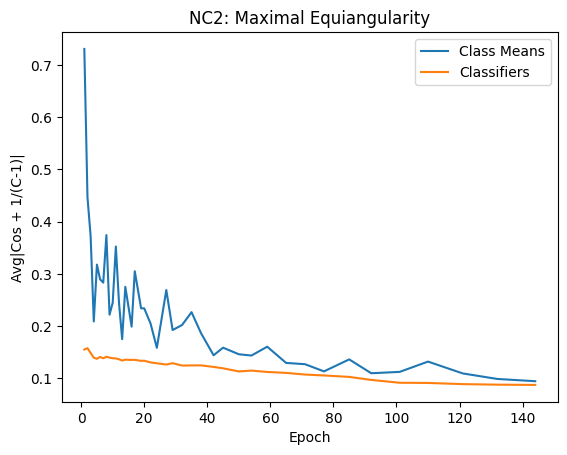

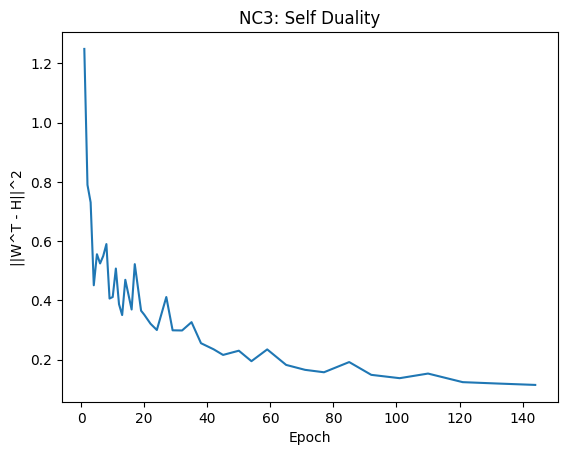

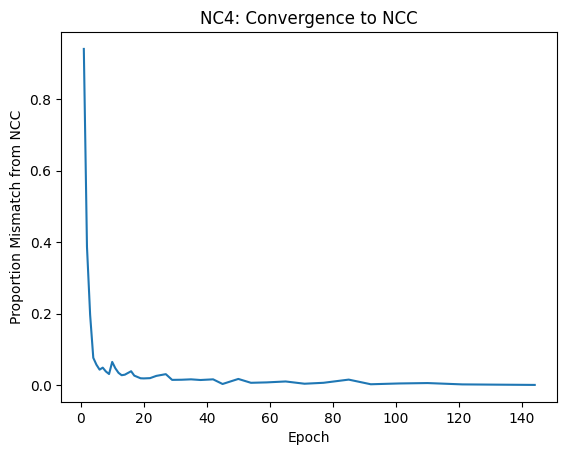

Train		Epoch: 145 [21/469 (4%)] 	Batch Loss: 0.001393 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:17,  5.77it/s]
Train		Epoch: 146 [21/469 (4%)] 	Batch Loss: 0.003616 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.39it/s]
Train		Epoch: 147 [21/469 (4%)] 	Batch Loss: 0.003293 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.45it/s]
Train		Epoch: 148 [21/469 (4%)] 	Batch Loss: 0.002453 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.47it/s]
Train		Epoch: 149 [21/469 (4%)] 	Batch Loss: 0.008375 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.16it/s]
Train		Epoch: 150 [21/469 (4%)] 	Batch Loss: 0.000691 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.15it/s]
Train		Epoch: 151 [21/469 (4%)] 	Batch Loss: 0.003216 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:12,  6.18it/s]
Train		Epoch: 152 [21/469 (4%)] 	Batch Loss: 0.005498 	Batch Accuracy: 1.000000:   4%|▍   

abc1_158.png
abc2_158.png
abc3_158.png
abc4_158.png
abc5_158.png
abc6_158.png
abc7_158.png


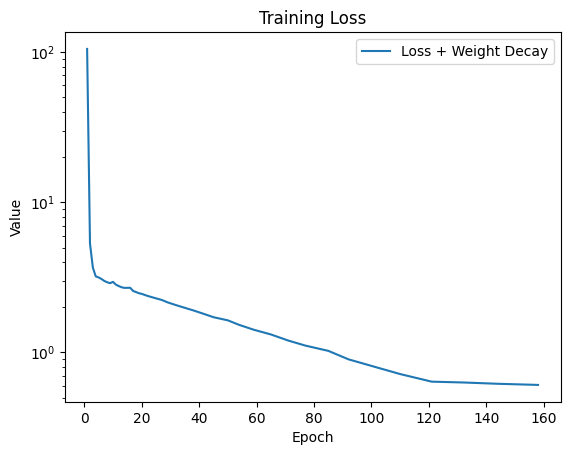

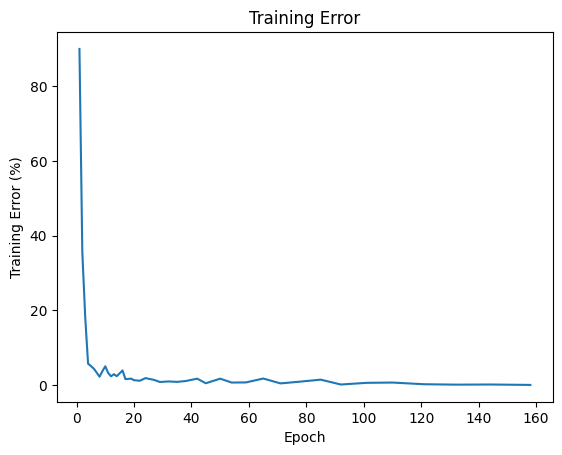

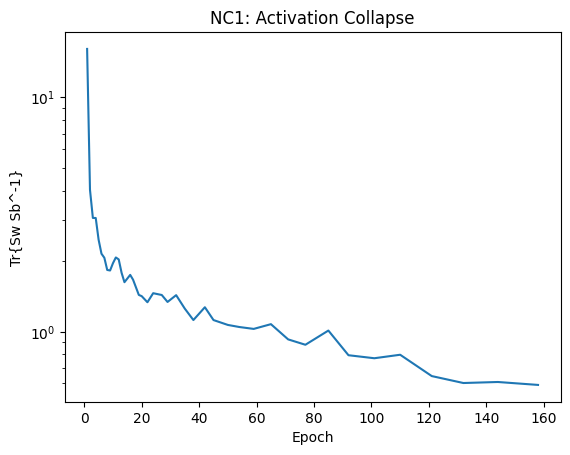

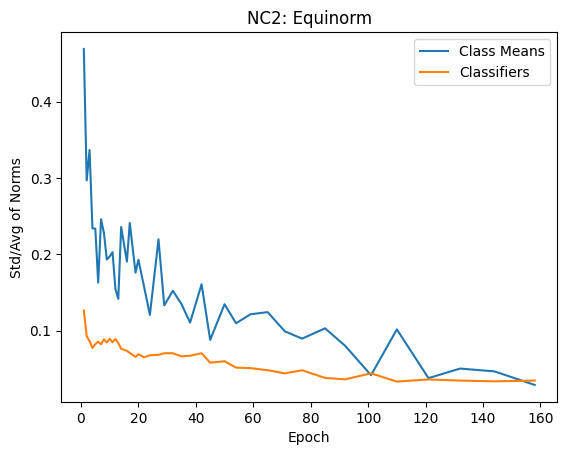

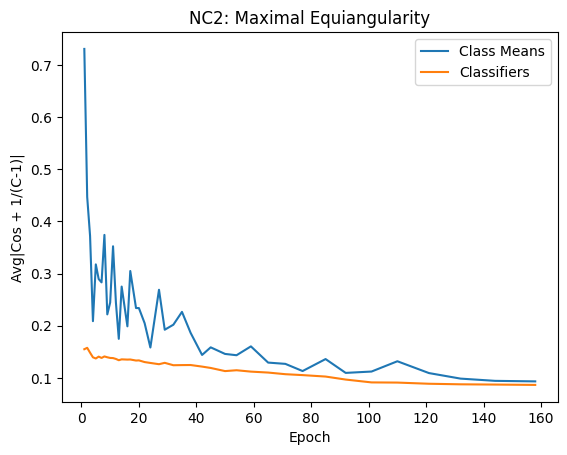

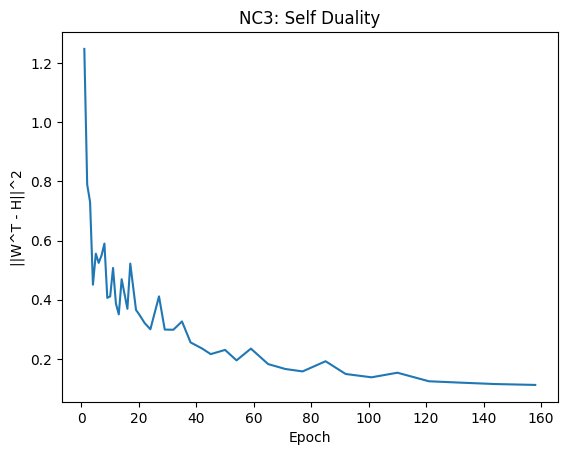

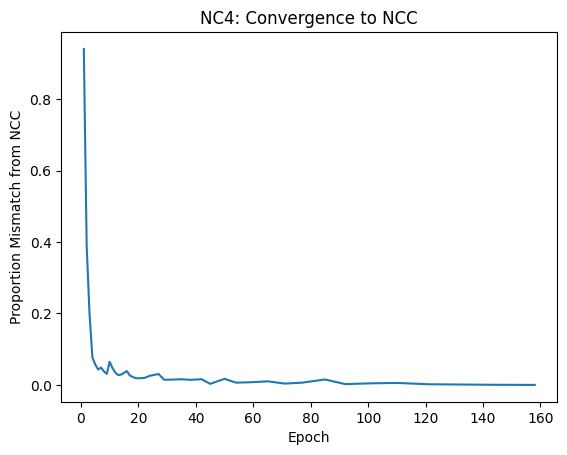

Train		Epoch: 159 [21/469 (4%)] 	Batch Loss: 0.002672 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:10,  6.34it/s]
Train		Epoch: 160 [21/469 (4%)] 	Batch Loss: 0.000749 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.24it/s]
Train		Epoch: 161 [21/469 (4%)] 	Batch Loss: 0.001174 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.29it/s]
Train		Epoch: 162 [21/469 (4%)] 	Batch Loss: 0.030671 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:03<01:11,  6.26it/s]
Train		Epoch: 163 [21/469 (4%)] 	Batch Loss: 0.001728 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.45it/s]
Train		Epoch: 164 [21/469 (4%)] 	Batch Loss: 0.001466 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:11,  6.29it/s]
Train		Epoch: 165 [21/469 (4%)] 	Batch Loss: 0.001822 	Batch Accuracy: 1.000000:   4%|▍         | 21/469 [00:03<01:09,  6.47it/s]
Train		Epoch: 166 [21/469 (4%)] 	Batch Loss: 0.002679 	Batch Accuracy: 1.000000:   4%|▍   

In [ ]:
from google.colab import files

cur_epochs = []
for epoch in range(1, epochs + 1):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()

    if epoch in epoch_list:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)

        plt.figure(1)
        plt.semilogy(cur_epochs, graphs.reg_loss)
        plt.legend(['Loss + Weight Decay'])
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Training Loss')
        print("abc1_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc1_"+str(epoch)+".png")

        plt.figure(2)
        plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
        plt.xlabel('Epoch')
        plt.ylabel('Training Error (%)')
        plt.title('Training Error')
        print("abc2_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc2_"+str(epoch)+".png")

        plt.figure(3)
        plt.semilogy(cur_epochs, graphs.Sw_invSb)
        plt.xlabel('Epoch')
        plt.ylabel('Tr{Sw Sb^-1}')
        plt.title('NC1: Activation Collapse')
        print("abc3_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc3_"+str(epoch)+".png")

        plt.figure(4)
        plt.plot(cur_epochs, graphs.norm_M_CoV)
        plt.plot(cur_epochs, graphs.norm_W_CoV)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Std/Avg of Norms')
        plt.title('NC2: Equinorm')
        print("abc4_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc4_"+str(epoch)+".png")

        plt.figure(5)
        plt.plot(cur_epochs, graphs.cos_M)
        plt.plot(cur_epochs, graphs.cos_W)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Avg|Cos + 1/(C-1)|')
        plt.title('NC2: Maximal Equiangularity')
        print("abc5_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc5_"+str(epoch)+".png")

        plt.figure(6)
        plt.plot(cur_epochs,graphs.W_M_dist)
        plt.xlabel('Epoch')
        plt.ylabel('||W^T - H||^2')
        plt.title('NC3: Self Duality')
        print("abc6_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc6_"+str(epoch)+".png")

        plt.figure(7)
        plt.plot(cur_epochs,graphs.NCC_mismatch)
        plt.xlabel('Epoch')
        plt.ylabel('Proportion Mismatch from NCC')
        plt.title('NC4: Convergence to NCC')
        print("abc7_"+str(epoch)+".png")
        plt.savefig(f"{images_dir}/"+"abc7_"+str(epoch)+".png")

        # Plot decomposition of MSE loss
        if loss_name == 'MSELoss':
          plt.figure(8)
          plt.semilogy(cur_epochs, graphs.MSE_wd_features)
          plt.semilogy(cur_epochs, graphs.LNC1)
          plt.semilogy(cur_epochs, graphs.LNC23)
          plt.semilogy(cur_epochs, graphs.Lperp)
          plt.legend(['MSE+wd', 'LNC1', 'LNC2/3', 'Lperp'])
          plt.xlabel('Epoch')
          plt.ylabel('Value')
          plt.title('Decomposition of MSE')
          print("abc8_"+str(epoch)+".png")
          plt.savefig(f"{images_dir}/"+"abc8_"+str(epoch)+".png")

        plt.show()